## Load trained models from `thetaGPU` and re-run inference with smaller batch-size

## Setup

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils.file_io as io

poptions = np.get_printoptions()
io.print_dict(poptions)

np.set_printoptions(linewidth=120, edgeitems=2, precision=6)

import json
from utils.attr_dict import AttrDict
from config import BIN_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tf.__version__: 2.4.0-dev20201016
  edgeitems: 3
  threshold: 1000
  floatmode: maxprec
  precision: 8
  suppress: False
  linewidth: 75
  nanstr: nan
  infstr: inf
  sign: -
  formatter: None
  legacy: False


## Build `Dynamics` by loading networks from `log_dir`

In [5]:
def run_inference_from_log_dir(log_dir, date_str):
    configs = io.loadz(os.path.join(log_dir, 'configs.z'))

    eps_file = os.path.join(log_dir, 'training', 'models', 'eps.z')
    eps = io.loadz(eps_file)
    #dynamics.eps = eps

    dynamics_config = configs.get('dynamics_config', None)

    dynamics_config['eps'] = eps
    dynamics_config['log_dir'] = log_dir
    dynamics_config['lattice_shape'] = (64, 16, 16, 2)
    dynamics_config['log_dir'] = log_dir
    configs.update({
        'dynamics_config': dynamics_config,
    })

    configs = AttrDict(configs)
    dynamics = build_dynamics(configs)

    xnet, vnet = dynamics._load_networks(log_dir)
    dynamics.xnet = xnet
    dynamics.vnet = vnet

    _, log_str = os.path.split(log_dir)

    timestamp = io.get_timestamp('%Y-%m-%d-%H%M')
    x = convert_to_angle(tf.random.normal(dynamics.x_shape))

    configs['run_steps'] = 1500
    configs['print_steps'] = 1
    configs['logging_steps'] = 10
    configs['md_steps'] = 100
    runs_dir = os.path.join(
        GAUGE_LOGS_DIR, 'LOADED',
        date_str, timestamp, log_str,
        'inference'
    )
    io.check_else_make_dir(runs_dir)
    dynamics, run_data, x, x_arr = inference(dynamics, args=configs, x=x,
                                             runs_dir=runs_dir, make_plots=True)
    return dynamics, run_data, x, x_arr

In [6]:
from pathlib import Path
from dynamics.gauge_dynamics import build_dynamics
from config import GAUGE_LOGS_DIR
import utils.file_io as io
from utils.inference_utils import run as inference
from utils.inference_utils_dev import run as inference_dev
from dynamics.gauge_dynamics import convert_to_angle
from config import PLOTS_DIR
from utils.plotting_utils import plot_data


base_dir = os.path.abspath('/Users/saforem2/DLHMC/thetaGPU/training/')
date_strs = ['2020_11_17', '2020_11_19', '2020_11_20', '2020_11_21']
date_dirs = [os.path.join(base_dir, i) for i in date_strs]
for date_dir in date_dirs:
    head, date_str = os.path.split(date_dir)
    date_dir = Path(date_dir)
    log_dirs = [x for x in date_dir.rglob('*L16_b*') if x.is_dir()] 
    timestamp = io.get_timestamp('%Y-%m-%d-%H%M') 
    dynamics_dict = {}
    run_data_dict = {}
    for log_dir in log_dirs:
        try:
            dynamics, run_data, _, _ = run_inference_from_log_dir(log_dir, date_str)
            dynamics_dict[log_dir] = dynamics
            run_data_dict[log_dir] = run_data
        except FileNotFoundError:
            print(f'Unable to run inference for:\n  {log_dir}.\nContinuing...')
    # for key, val in run_data_dict.items():
    #     if 'thetaGPU' in str(key):
    #         key = str(key).split('/')
    #         key = '/'.join([
    #             i for i in key if i.startswith('2020_') or i.startswith('L')
    #         ]) 
    #     out_dir = os.path.join(PLOTS_DIR, 'LOADED',
    #                            f'inference_plots_{timestamp}', str(key))
    #     #out_dir = os.path.join(key, f'new_plots')
    #     plot_data(val, therm_frac=0.2, out_dir=out_dir)

#log_dir = os.path.abspath(
#    '/Users/saforem2/DLHMC/thetaGPU/training/2020_11_17'
#    '/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs'
#    '/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj'
#)

Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj.
Continuing...
Using separate (x, v)-networks for each LF step!!
Loading xNet0 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet0...
2020-11-24 00:10:08 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet0 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet0...
2020-11-24 00:10:09 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.


2020-11-24 00:10:22 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet8...
2020-11-24 00:10:22 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet9 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet9...
2020-11-24 00:10:24 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet9 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/log

2020-11-24 00:12:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/v'), name='VNet0/v', description="created by layer 'VNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet0/t'), name='VNet0/t', description="created by layer 'VNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet0/x'), name='XNet0/x', description="created by layer 'XNet0/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:45 WARNING:5170:4

2020-11-24 00:12:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet1/t'), name='XNet1/t', description="created by layer 'XNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:45 WARNING:5170:4

2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet2/t'), name='XNet2/t', description="created by layer 'XNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet2/x'), name='XNet2/x', description="created by layer 'XNet2/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet2/v'), name='XNet2/v', description="created by layer 'XNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:46 WARNING:5170:4

2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:46 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:46 WARNING:5170:4498808256

2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/x'), name='VNet4/x', description="created by layer 'VNet4/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:47 WARNING:5170:4498808256

2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/x'), name='VNet6/x', description="created by layer 'VNet6/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:47 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/v'), name='VNet6/v', description="created by layer 'VNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:47 WARNING:5170:4498808256

2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/v'), name='VNet7/v', description="created by layer 'VNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet7/t'), name='VNet7/t', description="created by layer 'VNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet7/x'), name='XNet7/x', description="created by layer 'XNet7/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:48 WARNING:5170:4

2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:48 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet8/t'), name='XNet8/t', description="created by layer 'XNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:48 WARNING:5170:4

2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet9/t'), name='XNet9/t', description="created by layer 'XNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet9/x'), name='XNet9/x', description="created by layer 'XNet9/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet9/v'), name='XNet9/v', description="created by layer 'XNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:49 WARNING:5170:4

2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:49 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet10/x'), name='VNet10/x', description="created by layer 'VNet10/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:49 WARNING:5170:4

2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/x'), name='VNet11/x', description="created by layer 'VNet11/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/v'), name='VNet11/v', description="created by layer 'VNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:50 WARNING:5170:4

2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/v'), name='VNet12/v', description="created by layer 'VNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet12/t'), name='VNet12/t', description="created by layer 'VNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/x'), name='VNet13/x', description="created by layer 'VNet13/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:50 WARNING:5170:4

2020-11-24 00:12:50 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:51 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/x'), name='VNet14/x', description="created by layer 'VNet14/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:51 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/v'), name='VNet14/v', description="created by layer 'VNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:51 WARNING:5170:4

2020-11-24 00:12:51 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/v'), name='VNet14/v', description="created by layer 'VNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:51 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet14/t'), name='VNet14/t', description="created by layer 'VNet14/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet14/x'), name='XNet14/x', description="created by layer 'XNet14/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:52 WARNI

2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet13/x'), name='XNet13/x', description="created by layer 'XNet13/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet13/v'), name='XNet13/v', description="created by layer 'XNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:52 WARNI

2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet12/v'), name='XNet12/v', description="created by layer 'XNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet12/t'), name='XNet12/t', description="created by layer 'XNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:52 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet12/x'), name='XNet12/x', description="created by layer 'XNet12/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:52 WARNI

2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet11/x'), name='XNet11/x', description="created by layer 'XNet11/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet11/v'), name='XNet11/v', description="created by layer 'XNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:53 WARNI

2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:53 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet10/x'), name='VNet10/x', description="created by layer 'VNet10/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:53 WARNING:5170:4

2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/v'), name='VNet9/v', description="created by layer 'VNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet9/t'), name='VNet9/t', description="created by layer 'VNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:54 WARNING:5170:4498808256

2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/x'), name='VNet7/x', description="created by layer 'VNet7/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:54 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/v'), name='VNet7/v', description="created by layer 'VNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:54 WARNING:5170:4498808256

2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/v'), name='VNet6/v', description="created by layer 'VNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet6/t'), name='VNet6/t', description="created by layer 'VNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:55 WARNING:5170:4

2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet5/v'), name='XNet5/v', description="created by layer 'XNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:55 WARNING:5170:4

2020-11-24 00:12:55 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet4/t'), name='XNet4/t', description="created by layer 'XNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:56 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet4/x'), name='XNet4/x', description="created by layer 'XNet4/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:12:56 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet4/v'), name='XNet4/v', description="created by layer 'XNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:56 WARNING:5170:4

2020-11-24 00:12:56 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:56 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:56 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:56 WARNING:5170:4498808256

2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/v'), name='VNet2/v', description="created by layer 'VNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet2/t'), name='VNet2/t', description="created by layer 'VNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:57 WARNING:5170:4498808256

2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/x'), name='VNet0/x', description="created by layer 'VNet0/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:57 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/v'), name='VNet0/v', description="created by layer 'VNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:12:57 WARNING:5170:4498808256

    0/1500     0.1181      -17.28      0.1739      0.1719      0.1818       4.5       0.01179     -0.8401      0.6876      401.3       543.3       405.1       403.8       546.8       407.7       0.1719      0.1444     0.006779  
    1/1500    0.09723      -13.75      0.148       0.125       0.1818       4.5       0.03438     -0.7776      0.8078      406.5       556.3       409.8       399.9       538.6       404.6      0.09375     0.09824     0.00626   
    2/1500    0.08833      -18.62      0.1509      0.1562      0.1818       4.5       -0.09395    -0.8304      0.7668      400.7       543.1       405.3       398.3       535.3       402.7       0.1406      0.1234     0.005888  
    3/1500    0.08739      -22.26      0.2138       0.25       0.1818       4.5       0.009107     -0.822      0.7323      401.5       547.1       405.6       401.8       543.1       405.6       0.1875      0.196      0.005163  
    4/1500    0.08937      -47.34      0.1752      0.1719      0.1818       4.5     

   36/1500    0.09069      -14.85      0.191       0.2188      0.1818       4.5       -0.01615    -0.7615      0.7076      395.7        537        399.7       395.5       531.2       400.2       0.1406      0.1371     0.002948  
   37/1500    0.09073      -33.01      0.1608      0.1406      0.1818       4.5      -0.001757    -0.7726      0.7049      395.5       537.5       399.6       394.2       529.7       399.1       0.1719      0.1541     0.003216  
   38/1500    0.09055      -10.55      0.1431     0.09375      0.1818       4.5       -0.02567    -0.8043      0.6878      395.6       536.2       400.2       398.3       539.8       402.9      0.04688     0.04648     0.002958  
   39/1500    0.09073      -6.993      0.1299     0.09375      0.1818       4.5      -0.002929    -0.7728      0.7006       398        541.7       402.2       397.6       535.7       402.8       0.0625     0.03848     0.001811  
   40/1500    0.08848      -29.15      0.1256     0.09375      0.1818       4.5     

   72/1500    0.08841      -19.09      0.1698      0.1562      0.1818       4.5       -0.03427    -0.8581      0.6585      394.2       532.2       398.4       391.2       523.7       395.6       0.1406      0.1253     0.001268  
   73/1500    0.09074      -21.38      0.1526      0.1719      0.1818       4.5       0.002922    -0.8498      0.7049      395.6       537.6       399.9       396.1       535.9       400.2       0.1563      0.1623    0.0004429  
   74/1500    0.08847      -18.39      0.1624      0.1562      0.1818       4.5       -0.02703    -0.8557      0.6166      398.3       544.2       403.1       393.2       528.1       397.3       0.125       0.1264    0.0009104  
   75/1500    0.08846      -15.87      0.1445      0.1562      0.1818       4.5       -0.04447    -0.8418      0.6098      396.3       541.3       400.5       393.3       530.7        398        0.1719      0.1581    0.0007337  
   76/1500    0.08299      -19.76      0.2256      0.2188      0.1818       4.5     

  108/1500    0.08168      -11.08      0.154       0.125       0.1818       4.5       0.01713     -0.8319       0.7        391.8       532.8       395.8       398.6       541.5       403.6       0.125       0.1008    0.0002172  
  109/1500    0.09063      -12.81      0.1026     0.09375      0.1818       4.5       -0.03151    -0.8002      0.6949      393.9       536.9       398.4       396.5       539.1       400.8      0.04688     0.05332    0.0002331  
  110/1500     0.0973      -8.056      0.1387      0.125       0.1818       4.5       0.09061     -0.8593      0.7052      399.3       546.2       404.4       392.2       527.5        396       0.07813     0.07368    0.0006201  
  111/1500    0.09531      -17.11      0.1062      0.1562      0.1818       4.5       0.06937     -0.8016      0.6823      393.3       533.5       397.7       396.8       537.1       401.5       0.1875      0.1446    0.0003196  
  112/1500    0.08858      -10.26      0.1985      0.2188      0.1818       4.5     

  144/1500    0.07993      -12.69      0.1019     0.09375      0.1818       4.5       0.06519     -0.7174      0.6813      395.9       537.6       400.6       394.3        531        398.6      0.07813     0.06791    3.173e-05  
  145/1500    0.08421      -10.29      0.1398      0.1719      0.1818       4.5       0.006166    -0.7432      0.663       392.1       532.7       396.8       392.8       528.8       397.6      0.07813     0.08414    0.0002931  
  146/1500     0.0815      -15.23      0.1592      0.1406      0.1818       4.5       -0.0136     -0.7956      0.646       394.2       536.3       398.9       396.1       535.2        401       0.07813     0.09051    -0.0002086 
  147/1500    0.07818      -10.55      0.1343      0.1094      0.1818       4.5       -0.04291    -0.7915      0.624       394.4       535.2       399.6       393.6       530.2       398.3      0.07812     0.08475    -3.69e-05  
  148/1500     0.0801      -7.713     0.09302     0.04688      0.1818       4.5     

  180/1500    0.08011      -7.067      0.1286      0.1094      0.1818       4.5        0.0243     -0.8031      0.5994       389        524.9       393.5       393.4       528.9       397.9      0.07813     0.07315    -0.0003833 
  181/1500    0.07432      -25.37      0.1485      0.1562      0.1818       4.5       -0.02548    -0.7878      0.6191      394.8       534.3        399        394.1       530.8       398.5       0.1563      0.1287    -0.0003633 
  182/1500    0.07627      -5.591      0.1175      0.1094      0.1818       4.5       -0.01319    -0.8293      0.7102      395.2       537.7       399.9       396.1       537.7       400.5      0.07813     0.06322    -0.0001901 
  183/1500    0.07478      -32.92       0.2        0.1562      0.1818       4.5       0.06405      -0.789      0.7367      395.1        536        399.1       397.1       536.5       400.7       0.2031      0.1706    0.0002037  
  184/1500    0.07645      -21.52      0.149       0.1562      0.1818       4.5     

  216/1500    0.08264      -17.04      0.1816      0.2188      0.1818       4.5       -0.04935    -0.8825      0.7554      391.9       533.2        396        390.6       525.6        395        0.1563      0.1637    -0.001573  
  217/1500    0.07824      -17.46      0.1141      0.1406      0.1818       4.5       -0.03811    -0.8673      0.6441      389.5       524.7       393.4       393.1       528.3       397.9       0.1094      0.1082    -0.001256  
  218/1500    0.07641      -4.813      0.1749      0.1562      0.1818       4.5       0.02173     -0.8101      0.7127      395.4       538.6       399.7       389.5        521        393.8      0.03125     0.05615    -0.0009988 
  219/1500    0.07934      -10.59      0.1305     0.09375      0.1818       4.5       -0.1001     -0.8418      0.6562      393.1       534.1       397.2       392.1       531.7       397.1      0.07813     0.05647    -0.000817  
  220/1500    0.07705      -14.09      0.1672      0.1875      0.1818       4.5     

  252/1500     0.0794      -18.88       0.15       0.1406      0.1818       4.5       0.02186     -0.8129      0.5626       392        532.5        397        394.5       530.1       398.7       0.1563      0.1412    0.0001328  
  253/1500     0.0823      -13.96      0.1237     0.07812      0.1818       4.5       -0.02062    -0.8265      0.5749      392.7       533.2       397.6       393.7       530.7       398.5      0.09375     0.07967    -0.0007363 
  254/1500    0.07763      -20.68      0.1525      0.1406      0.1818       4.5       -0.01714     -0.844      0.6731      391.5       531.5        396        389.2       521.4       393.7       0.1094      0.126     -0.0008687 
  255/1500     0.0753      -12.93      0.1429      0.125       0.1818       4.5       0.03985     -0.8476      0.6386      390.5       530.2        395         391        528.3       395.5      0.09375      0.0928    -0.0009635 
  256/1500    0.08672      -31.44      0.1418      0.1406      0.1818       4.5     

  288/1500    0.08835      -5.797      0.1341      0.1562      0.1818       4.5       -0.05528    -0.9081      0.743       394.3        535         399        393.8       531.7       398.5      0.04688     0.06498    0.0006837  
  289/1500    0.08373      -21.91      0.1243      0.1406      0.1818       4.5       0.01472     -0.8431      0.676       392.9       533.2       397.4       394.6        533        399.6       0.1094      0.1272      0.0011   
  290/1500    0.08381      -8.276      0.1191      0.1094      0.1818       4.5       0.02675     -0.8753      0.7056      395.2       536.3       399.5       393.9       527.6       398.3       0.0625     0.06616    0.0006207  
  291/1500    0.08232      -6.858      0.1164      0.125       0.1818       4.5       -0.04089    -0.8324      0.6282      392.9       533.6       397.8       399.8       543.1       404.6      0.09375     0.08647     0.001139  
  292/1500    0.07777      -20.68      0.1553      0.1875      0.1818       4.5     

  324/1500    0.07708      -15.31      0.1116      0.1562      0.1818       4.5       0.03149     -0.8311      0.5951      393.4       531.1       397.8       394.3       530.3       398.7      0.09375     0.09228     0.000994  
  325/1500    0.07688      -6.16       0.1459      0.1406      0.1818       4.5       0.04972     -0.8752      0.7283      394.4       535.1        399         396        536.6       400.3       0.0625     0.06811     0.001089  
  326/1500    0.08282      -10.84      0.1414      0.125       0.1818       4.5       -0.04363     -0.916      0.6446      394.2       533.7       398.7       397.5       538.4       402.3      0.09375      0.1145    0.0008573  
  327/1500    0.07841      -7.232      0.188       0.1875      0.1818       4.5        0.0321     -0.8469      0.6395      396.8       542.5       401.7       393.2       528.1       397.7      0.07813     0.09766    0.0006269  
  328/1500    0.07929      -12.22      0.1427      0.1406      0.1818       4.5     

  360/1500     0.0955      -17.95      0.2036      0.2188      0.1818       4.5       -0.04181    -0.8141      0.6598      394.3        536        398.5       393.3       527.6       397.7       0.1406      0.1543    0.0006919  
  361/1500    0.09382      -31.65      0.1434      0.1562      0.1818       4.5      0.0009629    -0.8518      0.7429      389.5       524.6       393.4       397.3       536.9       401.6       0.1562      0.1594    0.0008304  
  362/1500    0.09118      -5.485      0.1344      0.1406      0.1818       4.5       -0.06904    -0.8354      0.6777      394.4       535.5       399.2       398.4       538.5       403.4      0.09375     0.07993     0.001264  
  363/1500    0.08515      -8.575      0.1286     0.09375      0.1818       4.5       0.02417      -0.885      0.6866      393.7       534.5       398.4       393.9       529.6       398.1      0.03125     0.03609     0.001693  
  364/1500    0.08417      -6.48       0.118      0.09375      0.1818       4.5     

  396/1500    0.09796      -64.21      0.1818      0.1406      0.1818       4.5       0.03065     -0.7843      0.7222      392.4       531.9       396.9       390.9       526.4       395.5       0.2187      0.2294    -0.0009095 
  397/1500     0.1024      -14.47      0.1434      0.1094      0.1818       4.5       -0.04465    -0.8427      0.6679      393.5       537.4       397.4       389.1       522.4       393.6       0.0625     0.05887    -0.0008589 
  398/1500    0.09906      -8.647      0.1434      0.1406      0.1818       4.5       0.03007     -0.8423      0.6415      393.3       532.8       397.6       389.3       520.7       394.5       0.0625     0.05671    -0.001107  
  399/1500    0.09523      -15.1       0.1303      0.1406      0.1818       4.5       0.02801     -0.8041      0.6347      393.4       534.5       397.7       390.8       523.5       395.5       0.1094      0.1056    -0.0008193 
  400/1500    0.09513      -19.27      0.1655      0.1406      0.1818       4.5     

  433/1500     0.1097      -12.13      0.2166      0.2031      0.1818       4.5       0.05925     -0.8054      0.6978      390.3        529         395        392.1        526        396.1       0.1094      0.1104    -0.001463  
  434/1500     0.1008      -29.67      0.1961      0.2344      0.1818       4.5       -0.01363    -0.7929      0.7377      390.6       527.5       394.6       392.9       530.4       397.2       0.1563      0.1421    -0.001892  
  435/1500     0.1091      -7.139      0.1015      0.1094      0.1818       4.5       -0.01371    -0.8017      0.7096      392.4       532.7       397.2       393.8       531.4       399.1      0.04688      0.0473    -0.001628  
  436/1500    0.09886      -6.996      0.1395      0.1094      0.1818       4.5       0.08496     -0.8263      0.7462      390.3       526.6       394.8        391        527.6       394.9      0.04688     0.05308    -0.0008781 
  437/1500    0.09716      -35.01      0.2094      0.1719      0.1818       4.5     

  469/1500     0.1043      -8.856     0.09622      0.125       0.1818       4.5       -0.04789    -0.7298      0.653       391.3       531.6       395.4       393.2       529.3       397.3       0.1094      0.1019    -0.0002181 
  470/1500     0.1206      -16.84      0.1142     0.09375      0.1818       4.5       -0.01213    -0.8075      0.6504      393.7       535.1       397.9       390.9       525.7       395.4       0.0625     0.07576    -0.000593  
  471/1500     0.1118      -15.94      0.1493      0.1094      0.1818       4.5       -0.02357    -0.8718      0.7273      396.1       542.2       400.9       390.7       526.8        395        0.0625     0.06943    -0.001301  
  472/1500     0.1397      -12.93      0.1779      0.2031      0.1818       4.5       0.02561     -0.8406      0.7203      393.1       535.3       397.5        391        524.1       395.8      0.07813      0.1109    -0.0006298 
  473/1500     0.1252      -17.75      0.2352       0.25       0.1818       4.5     

  506/1500     0.1053      -17.83      0.1635      0.2188      0.1818       4.5       0.03406     -0.8288      0.6299      395.5       541.1       399.6       395.5       535.8       400.2      0.09375      0.1036    -0.0004565 
  507/1500     0.1087      -40.63      0.1887      0.2188      0.1818       4.5       0.005427     -0.855      0.6753      392.6       533.3       396.3       391.5       526.4       395.3       0.2812      0.2455    -0.001462  
  508/1500     0.1072      -10.13      0.1394      0.2031      0.1818       4.5       -0.02486    -0.8773      0.6144      392.8       533.7       397.5       394.2       533.9       399.2       0.1719      0.1524    -0.001083  
  509/1500    0.09804      -7.513      0.1485      0.125       0.1818       4.5       -0.06976    -0.8107      0.5485      392.4       534.4       396.8       392.4       527.2        397       0.09375     0.09069    -0.001164  
  510/1500     0.1026      -8.265      0.1021     0.07812      0.1818       4.5     

  542/1500     0.1017      -5.484     0.08685     0.04688      0.1818       4.5       -0.03026    -0.8653      0.6505      394.3       536.6       399.3        392        525.7       397.2      0.03125     0.02791    -0.0005713 
  543/1500    0.09876      -25.46      0.1477      0.1875      0.1818       4.5       0.06936     -0.8775      0.7488      394.6        538        399.7       392.2       527.4       397.5       0.2344      0.2252    -4.47e-05  
  544/1500     0.1019      -24.2       0.1914      0.1562      0.1818       4.5       -0.02289    -0.7524      0.7106      394.6       537.6        399        395.3       536.4       399.4       0.1562      0.1305    0.0007639  
  545/1500     0.1051      -8.047      0.1283      0.125       0.1818       4.5       0.06682     -0.8397      0.701       395.4       536.9       399.9       397.7       538.7       402.1      0.09375      0.1007     0.001044  
  546/1500     0.107       -7.309     0.09788      0.1406      0.1818       4.5     

  578/1500     0.1298      -10.15     0.06838     0.07812      0.1818       4.5       -0.02143    -0.8623      0.6789      396.9       540.4       401.5       396.5       536.1       400.8       0.0625     0.05764    -0.0001826 
  579/1500     0.1265      -7.49       0.1222      0.1094      0.1818       4.5       -0.02152    -0.8564      0.6627       392        530.1       396.7        395         534        399.5      0.04688     0.05547    0.0001288  
  580/1500     0.1247      -15.57      0.1874      0.125       0.1818       4.5       0.001442    -0.7559      0.695       396.7       537.5        401        391.9       525.6       395.6       0.1094      0.0995    -6.461e-05 
  581/1500     0.1348      -13.47      0.1545      0.125       0.1818       4.5       -0.02801    -0.8294      0.716       391.9       529.7       395.8       393.2        530        397.4      0.07812     0.08446    0.0003784  
  582/1500     0.131       -6.687      0.1719      0.1719      0.1818       4.5     

  614/1500     0.1329      -22.89      0.1252      0.1406      0.1818       4.5       -0.03777     -0.817      0.6871      391.3       528.6       395.8       396.4       535.3       401.3       0.1875      0.1531     0.00194   
  615/1500     0.1227      -6.395      0.138       0.1406      0.1818       4.5       -0.04725    -0.8046      0.6742      394.7       535.5       399.5       397.7       535.8       402.3       0.0625     0.06904     0.001729  
  616/1500     0.1257      -20.01      0.1973      0.1875      0.1818       4.5       -0.02438    -0.8024      0.7167      399.4       546.1       404.1       397.3       537.4       401.3       0.1719      0.157      0.001843  
  617/1500     0.1179      -39.72      0.1916      0.2344      0.1818       4.5       0.07858     -0.7692      0.6921      394.8       535.9       398.9       394.4       529.6       398.8       0.2656      0.2573    0.0009651  
  618/1500     0.1373      -11.12      0.1349      0.125       0.1818       4.5     

  651/1500     0.1427      -3.466     0.07133      0.1094      0.1818       4.5       0.04223     -0.8932      0.6816      397.2        544        402.2       390.9       524.4       395.7       0.0625     0.05653    -0.001785  
  652/1500     0.1406      -12.28      0.1009     0.09375      0.1818       4.5       0.003359    -0.8689      0.6382      392.6       533.7       397.4       393.7       533.6       398.2      0.09375     0.09857    -0.001394  
  653/1500     0.1395      -9.548     0.08608     0.07812      0.1818       4.5       0.004479    -0.8892      0.5834      392.5       532.5       397.1       391.6       527.8       396.2       0.1094     0.07684    -0.001599  
  654/1500     0.1266      -18.76      0.137       0.1094      0.1818       4.5       0.04469     -0.8466      0.7271      392.5       534.3       397.1       392.9        531         397       0.07813     0.07572    -0.0009715 
  655/1500     0.1333      -23.63      0.1413      0.1875      0.1818       4.5     

  687/1500     0.1128      -16.41      0.1076     0.07812      0.1818       4.5      -0.002181    -0.7919      0.6474      386.9       522.1       392.2       392.7       530.6       397.2      0.09375     0.09945    -0.001961  
  688/1500     0.1115      -10.54      0.117       0.125       0.1818       4.5       -0.02492    -0.8128      0.7243      388.1       522.5       393.3        392        526.3       396.8      0.09375     0.08846    -0.001207  
  689/1500     0.1116      -33.48      0.161       0.2031      0.1818       4.5      -5.986e-05   -0.8535      0.7005      395.1       538.9       399.4       388.2       520.5        393        0.2188      0.2025    -0.0007475 
  690/1500     0.1075      -11.57      0.1069      0.125       0.1818       4.5       0.01648     -0.8556      0.6053      386.3        519        391.5       393.1       530.5       397.6       0.1094      0.0908     -0.00125  
  691/1500     0.103       -35.32      0.1605      0.1875      0.1818       4.5     

  724/1500     0.1032      -22.56      0.1791      0.1562      0.1818       4.5       0.008565    -0.8153      0.6559      397.5       542.2       401.8       394.2       530.3       398.7       0.1875      0.1523     0.001254  
  725/1500     0.1006      -14.68      0.1251      0.1406      0.1818       4.5       -0.06003    -0.8241      0.6188      393.1       530.9       397.4       396.1       534.3       400.2       0.125       0.1099    0.0008048  
  726/1500     0.1015      -6.103      0.1234      0.1094      0.1818       4.5       -0.01889    -0.8124      0.6594      395.5       539.6       400.7       393.9       527.9       398.7      0.04688     0.05352     0.001141  
  727/1500     0.099       -28.37      0.1878      0.2031      0.1818       4.5       -0.05166    -0.8852      0.5828      397.3       542.8       401.1       396.8       536.1       401.1       0.2656      0.2205    -0.0001865 
  728/1500    0.09813      -28.1       0.1382      0.1406      0.1818       4.5     

  762/1500    0.09026      -16.31      0.1584      0.1406      0.1818       4.5       0.03048     -0.8508      0.5912      396.6       542.6        401        395.1       533.5       399.7       0.1406      0.1337    -0.000367  
  763/1500    0.08935      -29.61      0.1035      0.1094      0.1818       4.5       -0.04114    -0.7654      0.6133      391.1       530.6       395.5       392.7       530.2       397.4       0.1563      0.149     -0.0005874 
  764/1500     0.1017      -13.89      0.1503      0.1562      0.1818       4.5       -0.06083    -0.8095      0.6126      395.7       539.9       400.8       393.5       529.7       398.5       0.1406      0.1161    -0.0003509 
  765/1500     0.099       -17.67      0.1391      0.125       0.1818       4.5       0.04608      -0.922      0.6236      394.9       539.1       399.6        390        522.8        395        0.1094     0.09626    0.0004794  
  766/1500     0.0993      -22.18      0.104      0.09375      0.1818       4.5     

  798/1500     0.1045      -9.157     0.09955      0.1562      0.1818       4.5       -0.01078    -0.7436      0.6616      387.5       525.2       391.7       393.2       530.2        397        0.1562      0.1412    -0.001519  
  799/1500     0.1039      -32.21      0.1288      0.125       0.1818       4.5       0.009437    -0.7863      0.742       391.4       532.7       396.3       393.6        529        398.1       0.1406      0.1361    -0.0007179 
  800/1500     0.0968      -21.57      0.1432      0.1719      0.1818       4.5       -0.01542    -0.7413      0.6857      391.7        534        396.3        396        535.9        401       0.07813      0.1052    -5.629e-05 
  801/1500    0.09181      -56.89      0.1765      0.1562      0.1818       4.5       -0.03776    -0.7983      0.7095       394        533.1       397.9        395        532.8        399        0.2812      0.2327    0.0002059  
  802/1500    0.08735      -19.16      0.1487      0.2344      0.1818       4.5     

  834/1500    0.09116      -29.93      0.1676      0.1406      0.1818       4.5       -0.09521    -0.7331      0.6868      394.6       538.2       398.8       396.1       536.7        401        0.1563      0.149     -0.0007866 
  835/1500    0.09201      -21.01      0.1968      0.1875      0.1818       4.5       -0.03057     -0.741      0.6585      394.4        535        398.8       393.4       528.4       398.3       0.1094      0.1184    -0.0002666 
  836/1500    0.08819      -7.467      0.153       0.1719      0.1818       4.5       -0.04836    -0.8683      0.681       391.2       527.7       395.8        393        530.3       398.2      0.07813      0.0815    0.0001901  
  837/1500    0.08664      -20.76      0.1622      0.1406      0.1818       4.5       0.03911     -0.8345      0.7015      390.1        527        395.3       394.4       530.3       399.9       0.1719      0.1529    -0.0001099 
  838/1500    0.08464      -7.557     0.09215     0.07812      0.1818       4.5     

  870/1500    0.09062      -21.97      0.1404      0.1875      0.1818       4.5       -0.03676    -0.7952      0.7029      392.5       531.1        397        393.9       530.6        398        0.2031      0.211     -0.001021  
  871/1500    0.08548      -8.078      0.1039      0.1094      0.1818       4.5        0.1013     -0.7774      0.6438      397.6       543.2       402.7       395.2       533.3       399.6      0.04688     0.06058    -0.0005038 
  872/1500     0.0875      -15.58      0.1959      0.1719      0.1818       4.5        0.0203     -0.8151      0.7861      393.8       534.9       398.2       394.6       534.4       399.1       0.125       0.1205    -3.418e-07 
  873/1500    0.09853      -17.75      0.1727      0.1562      0.1818       4.5       -0.02582    -0.8088      0.6522      394.1       537.1       397.7       394.4       533.2       399.8       0.1406      0.1378    -0.0006436 
  874/1500    0.09247      -12.32      0.1548      0.1406      0.1818       4.5     

  908/1500    0.09898      -19.53      0.1485     0.09375      0.1818       4.5      -0.006488    -0.8369      0.7385      395.6        539        400.3        395        531.9       399.6       0.125       0.112     0.0008477  
  909/1500    0.09455      -13.44      0.1717      0.2031      0.1818       4.5       -0.01289    -0.8532      0.7361      391.8       529.7       396.6       394.4       530.4       398.9       0.125       0.1266    0.0002547  
  910/1500    0.09283      -7.666      0.1157      0.125       0.1818       4.5       0.06103     -0.8391      0.6191      394.9       536.5       400.8       395.2       536.3       399.9       0.0625      0.0604    -0.0001702 
  911/1500    0.09249      -25.08      0.1484      0.1094      0.1818       4.5       -0.00951    -0.8282      0.6841      395.4       537.5       400.1       396.8       537.5       401.1       0.1719      0.144     -0.0003971 
  912/1500    0.09646      -12.22      0.1387      0.1094      0.1818       4.5     

  945/1500    0.09707      -16.49      0.2063      0.2188      0.1818       4.5       0.007809     -0.823      0.7036      393.9        535        398.2       394.8       531.5       398.1       0.125       0.1364     -0.00109  
  946/1500    0.08917      -16.58      0.1086      0.125       0.1818       4.5        0.0744     -0.8489      0.7188      389.3       525.5       394.3       391.8       530.5       396.5       0.1406      0.1367    -0.0008773 
  947/1500    0.09202      -7.347     0.07475     0.07812      0.1818       4.5      -0.008739    -0.7535      0.7895      391.3       528.6        396        389.6       521.8       394.1      0.09375     0.06646    -0.0007521 
  948/1500    0.09025      -10.94      0.163       0.1875      0.1818       4.5       -0.06536    -0.7666      0.6586      392.7       533.9       396.8       396.1       538.7       400.8       0.1719      0.1556    -0.0004369 
  949/1500    0.09162      -13.95      0.1112      0.1094      0.1818       4.5     

  981/1500    0.09386      -19.6       0.1606      0.1406      0.1818       4.5       0.004902    -0.7729      0.7332      396.4       537.6       400.7        394        530.8       398.3       0.1406      0.1415     0.001548  
  982/1500    0.08592      -13.44      0.1793      0.2188      0.1818       4.5       0.03414     -0.6832      0.6725      394.9       534.7       399.3       396.9       538.3       401.4       0.1406      0.1521     0.001962  
  983/1500    0.08892      -11.47      0.1764      0.1562      0.1818       4.5       -0.0376     -0.6949      0.7044      393.8        535        397.9       396.7        534        401.5      0.04688     0.06737     0.001519  
  984/1500    0.09392      -6.057      0.1183      0.1094      0.1818       4.5       -0.01622    -0.7847      0.6766      396.2       538.5       400.7       394.1       531.4       398.4      0.07813     0.06447     0.001185  
  985/1500    0.08945      -7.535      0.1868      0.1875      0.1818       4.5     

 1014/1500    0.09494      -12.06      0.1208     0.07812      0.1818       4.5       -0.08376    -0.8438      0.601       394.8        538        399.2       395.7       535.5       400.6      0.04688     0.04968    0.0006337  
 1015/1500    0.09261      -25.9       0.1635      0.125       0.1818       4.5      -0.008991    -0.8916      0.628       393.9       532.6       398.3       392.8        529        396.7       0.1094      0.1078    0.0007403  
 1016/1500    0.09312      -14.72      0.1694      0.1875      0.1818       4.5       0.01755     -0.8567      0.6677      393.3       532.1       397.3       393.7       530.4       398.3       0.1406      0.117      0.000682  
 1017/1500    0.09635      -8.293      0.1075     0.09375      0.1818       4.5       0.02509     -0.7734      0.6139      391.8       528.2       396.5       395.7       536.3       400.5      0.07813      0.0761    0.0005775  
 1018/1500    0.09405      -18.8       0.1302      0.1562      0.1818       4.5     

 1050/1500     0.1076      -4.902     0.09666     0.09375      0.1818       4.5       -0.00152    -0.8252      0.6425      393.5       534.2       398.1       394.2       530.3       399.4       0.0625     0.05737     0.001436  
 1051/1500     0.0974      -18.21      0.199       0.2188      0.1818       4.5         0.13      -0.7688      0.6279      395.1       537.2       399.6       396.6       534.6        401        0.1875      0.1783     0.001698  
 1052/1500    0.09801      -7.147     0.08993      0.1094      0.1818       4.5       0.04108     -0.8458      0.6863      395.6       538.8       400.6        398        539.5       402.3      0.09375      0.1116     0.001762  
 1053/1500    0.09593      -7.31      0.07935      0.1094      0.1818       4.5       0.003861     -0.866      0.5681      400.2       546.6       405.4       396.8        537        401.8      0.07812     0.08163     0.001844  
 1054/1500    0.09373      -7.722      0.086       0.1094      0.1818       4.5     

 1088/1500    0.09551      -3.387      0.1419      0.1562      0.1818       4.5        0.042      -0.7493      0.6053      396.7        541        401.1       393.9       530.5        398       0.03125     0.04707    -0.0003421 
 1089/1500    0.09142      -8.545      0.1109      0.1094      0.1818       4.5       0.004472    -0.8281      0.6455      399.8       547.7        404        395.3       533.5        400        0.1094      0.1034    -0.0001568 
 1090/1500    0.09227      -17.87     0.09175      0.125       0.1818       4.5       -0.01829    -0.8208      0.6732      395.2       540.8       399.4       394.8       532.9       399.7       0.1562      0.1345    -0.0001826 
 1091/1500     0.117       -25.1       0.1615      0.2031      0.1818       4.5       -0.02092    -0.7863      0.7164      388.9       523.8       392.3       394.9       534.1       399.3       0.2031      0.1904    -5.266e-05 
 1092/1500    0.09601      -17.53      0.151       0.125       0.1818       4.5     

 1124/1500    0.09107      -12.57      0.1382      0.125       0.1818       4.5       -0.04021     -0.797      0.7072      392.7       534.3       397.2       392.5        527         397        0.1094      0.1028    -0.0001842 
 1125/1500    0.09228      -8.079     0.09089      0.0625      0.1818       4.5       -0.02059    -0.8214      0.6823       394        533.9        398        390.6       522.3        396       0.07812     0.07399    2.098e-05  
 1126/1500     0.093       -18.78      0.1293      0.1406      0.1818       4.5      -0.007021    -0.8394      0.6951      393.1       533.4       397.7       396.5       537.1       401.4       0.1563      0.141     0.0005196  
 1127/1500    0.09966      -14.97      0.1728      0.2031      0.1818       4.5       -0.01918    -0.7654      0.6926      396.9       539.8       401.4       394.5        534        398.7       0.1406      0.1356    0.0002643  
 1128/1500    0.09556      -5.84       0.1018      0.125       0.1818       4.5     

 1160/1500     0.1026      -10.51      0.141       0.125       0.1818       4.5       0.05989     -0.7955      0.6456      392.9        532        398.1       395.1       533.7       400.2      0.09375     0.09006    0.0006179  
 1161/1500     0.1122      -5.692     0.08426     0.09375      0.1818       4.5       0.004451    -0.8279      0.6371      394.6        533        399.5       395.9       531.5       400.3      0.07813      0.0707     0.000646  
 1162/1500     0.1098      -23.42      0.1099     0.07812      0.1818       4.5       -0.02698     -0.88       0.5456      393.8       535.2       398.9       393.5       528.9       398.2       0.125       0.1122    0.0006859  
 1163/1500      0.1        -11.3       0.1143      0.1094      0.1818       4.5       0.02585     -0.7693      0.5645      395.5       541.4        401        395.9       533.7       401.4      0.09375      0.0769      0.0013   
 1164/1500     0.1006      -33.05      0.1736      0.1719      0.1818       4.5     

 1197/1500    0.09361      -11.48      0.131       0.1406      0.1818       4.5       0.02195     -0.7894      0.761       393.2       533.6       397.7       397.4       536.7        402        0.1094      0.1121     0.001466  
 1198/1500    0.09346      -16.67      0.2061       0.25       0.1818       4.5       0.04169      -0.748      0.6935      394.9       536.7       398.9       395.2       531.6       399.2       0.1875      0.1838    0.0001677  
 1199/1500    0.08857      -11.42      0.1181      0.1406      0.1818       4.5       -0.04355    -0.8286      0.6891      393.1       532.7       397.7       395.1       535.7       399.4      0.07813     0.08118    0.0002627  
 1200/1500    0.08994      -21.7       0.1203      0.1094      0.1818       4.5       0.006568    -0.7747      0.7196      391.7       528.3       395.6       393.3       529.1       397.5       0.1094      0.1091    0.0008509  
 1201/1500     0.0995      -17.55      0.2144      0.2031      0.1818       4.5     

 1233/1500    0.09529      -9.681      0.1343      0.1094      0.1818       4.5      -0.002864    -0.8232      0.6412      394.8       536.9       400.4       396.7       536.5       401.1       0.0625     0.06342    -0.0001311 
 1234/1500    0.08965      -13.16      0.1382      0.1562      0.1818       4.5       0.05974     -0.7375      0.721       390.9       529.3       395.3        391        525.9       395.1       0.1563      0.1203    0.0002427  
 1235/1500    0.09336      -13.91      0.1472      0.125       0.1818       4.5       0.02155     -0.8651      0.7026       394        534.5       398.3       396.4       535.5       401.1      0.07813     0.08362    6.948e-05  
 1236/1500    0.09156      -14.2       0.1059      0.1406      0.1818       4.5       -0.01756     -0.781      0.656       394.6       533.9       399.4       393.8       532.4       399.2       0.1094      0.1233    0.0005832  
 1237/1500     0.0895      -16.88      0.1535      0.1406      0.1818       4.5     

 1269/1500     0.1006      -27.42      0.177       0.1875      0.1818       4.5       -0.01931    -0.8356      0.7123      393.7       536.7       398.5        392         527        396.3       0.1563      0.1719     0.001052  
 1270/1500    0.09353      -22.78      0.1678      0.1562      0.1818       4.5       0.01603     -0.7863       0.68       395.3       537.6       400.2       393.8       530.7       398.3       0.1406      0.1298    0.0007776  
 1271/1500    0.09484      -7.244      0.1251      0.125       0.1818       4.5       0.01413     -0.8328      0.6561      395.4       537.6       399.9       396.8       538.2       401.8      0.09375     0.09019     0.000908  
 1272/1500    0.09311      -6.96       0.1254      0.125       0.1818       4.5       0.01094     -0.7734      0.6584      394.7       536.5       399.3       394.4       531.7       399.3      0.03125     0.04457    0.0008683  
 1273/1500    0.09396      -5.753     0.06726     0.04688      0.1818       4.5     

 1305/1500     0.1001      -10.62     0.09391     0.07812      0.1818       4.5       -0.01182    -0.8298      0.6755      392.9       534.3       396.8       393.6       530.8       397.7      0.09375     0.08628    -0.002178  
 1306/1500     0.1142      -12.32      0.1791       0.25       0.1818       4.5       0.06766     -0.7603      0.6765      388.1       524.8       392.3       392.7       529.6       396.3       0.1406      0.1447    -0.002792  
 1307/1500     0.1025      -13.73      0.1316      0.125       0.1818       4.5       -0.01457    -0.8452      0.6489      390.3       528.9       394.6        386        515.4       390.9       0.1094      0.1027     -0.00224  
 1308/1500     0.1232      -14.15      0.1624      0.1719      0.1818       4.5       0.03112     -0.7715      0.6516      393.5       535.1       398.4       389.9       524.8       394.3       0.1562      0.1403    -0.001927  
 1309/1500     0.1126      -12.32      0.123       0.1094      0.1818       4.5     

 1341/1500     0.1196      -11.6       0.1735      0.2344      0.1818       4.5        0.1623      -0.855      0.6625      391.5       533.2       396.4       391.5        526        395.7       0.1406      0.1402     -0.00144  
 1342/1500     0.1228      -10.53      0.1298      0.1094      0.1818       4.5      -9.394e-05   -0.7955      0.6846      389.9        529        393.5       390.8       523.4       395.6      0.07813     0.09174    -0.0008798 
 1343/1500     0.1358      -7.147     0.08396      0.0625      0.1818       4.5       0.009355    -0.8104      0.7132      391.1       530.8       395.8        392        529.9       396.9      0.01562     0.02629    -0.0005214 
 1344/1500     0.1353      -16.66      0.1567      0.1406      0.1818       4.5       -0.01998    -0.8485      0.7459      391.1       527.4       395.5       394.3       529.7       398.8       0.125       0.1369    -1.118e-05 
 1345/1500     0.1259      -8.459      0.1063     0.09375      0.1818       4.5     

 1377/1500     0.1157      -20.93      0.1401      0.1406      0.1818       4.5       -0.01316    -0.7727      0.6687      391.3       531.5       395.9       392.2        528        396.8       0.1562      0.1283    -0.002598  
 1378/1500     0.1194      -8.645      0.131       0.125       0.1818       4.5       -0.03142    -0.6704      0.6423      392.1       532.7       396.7       389.3       521.4       394.2       0.0625     0.05853    -0.002182  
 1379/1500     0.1202      -13.83      0.1397      0.1406      0.1818       4.5       0.003096    -0.7137      0.7382       393         534        397.1       394.5       535.7       398.9       0.1406      0.1375    -0.001317  
 1380/1500     0.1167      -11.76      0.102      0.09375      0.1818       4.5       0.03626      -0.75       0.6741      397.3       543.2       401.9       391.6       526.9        397       0.09375     0.09384    -0.001497  
 1381/1500     0.1209      -14.02      0.1419      0.1562      0.1818       4.5     

 1414/1500     0.1054      -14.8       0.1783      0.1406      0.1818       4.5        0.0216     -0.8226      0.6465      398.1       542.2       402.2       394.8       531.9       399.6      0.09375     0.09374     0.001448  
 1415/1500     0.1036      -9.079      0.1216      0.1562      0.1818       4.5       0.03248     -0.8642      0.6038      395.1       536.9        400         394        529.3       399.1      0.09375      0.0844     0.001181  
 1416/1500     0.1014      -1.955      0.1008      0.1094      0.1818       4.5       0.04299     -0.8743      0.5911      395.6       536.3       400.4       394.6       532.3       399.1      0.01563     0.02615     0.001096  
 1417/1500     0.1086      -19.65      0.1399      0.1719      0.1818       4.5       -0.05904    -0.8121      0.6154      395.6       537.8       399.6       397.2        537         402        0.1719      0.1695    0.0007502  
 1418/1500      0.1        -10.05     0.09891     0.09375      0.1818       4.5     

 1450/1500     0.1072      -18.03      0.1675      0.1406      0.1818       4.5       -0.04394    -0.8274      0.6548      390.9       527.6       395.1       393.2       529.1       397.3       0.1406      0.1315    -0.0002323 
 1451/1500     0.1122      -23.13      0.1611      0.1719      0.1818       4.5       -0.03595    -0.8073      0.5562      394.5       536.5       399.6       395.1       532.1       400.5       0.1719      0.1934    0.0001678  
 1452/1500     0.1164      -17.12      0.1045     0.07812      0.1818       4.5       -0.01365     -0.826      0.6426      394.2       535.7       399.1        393        529.5       397.5      0.03125     0.03867    0.0001143  
 1453/1500     0.1185      -30.67      0.1445      0.1719      0.1818       4.5       -0.07478    -0.7105      0.6056      397.9       541.5       402.6       395.2       533.2       400.3       0.2031      0.1954    -0.0001642 
 1454/1500     0.1181      -16.74      0.1397      0.1406      0.1818       4.5     

 1487/1500     0.103       -29.43      0.1674      0.1406      0.1818       4.5       0.05655     -0.8331      0.664       397.7       541.8       402.2       397.9       537.4       402.3       0.2188      0.1851     0.000875  
 1488/1500     0.1056      -6.022      0.1178     0.09375      0.1818       4.5       0.04921     -0.8455      0.7118      396.6       538.5       401.1       395.8       533.3       400.6      0.04688     0.05352    0.0005667  
 1489/1500     0.1033      -16.23      0.1826      0.2188      0.1818       4.5       -0.05123    -0.8869      0.6645      389.3       523.4       393.5       391.8       525.3       396.7       0.1563      0.1444    0.0006511  
 1490/1500    0.09707      -4.91      0.06699     0.03125      0.1818       4.5      -0.002177    -0.8151      0.7468      393.6       536.5       398.3        397        537.8       401.6      0.01563     0.01361    0.0008032  
 1491/1500     0.1004      -14.44      0.1545      0.1562      0.1818       4.5     

Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/traceplots/Hf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/traceplots/Hf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeMod

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/traceplots/dq_sin_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/traceplots/charges_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/traceplots/plaqs_traceplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0010/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps0182-2020-11-24-0010/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf15_eps005-2020-11-18-1828.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/inference_hmc/L16_b1024__lf15_eps015-2020-11-18-2137.
Continuing...
Using separate (x, v)-networks for each LF step!!
Loading xNet0 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/trai

2020-11-24 00:22:33 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet8...
2020-11-24 00:22:34 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet8...
2020-11-24 00:22:35 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet9 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/Gauge

2020-11-24 00:24:04 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:04 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/x'), name='VNet0/x', description="created by layer 'VNet0/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:04 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/v'), name='VNet0/v', description="created by layer 'VNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:04 WARNING:5170:4498808256

2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/v'), name='VNet1/v', description="created by layer 'VNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:05 WARNING:5170:4498808256

2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/v'), name='VNet3/v', description="created by layer 'VNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:05 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet3/t'), name='VNet3/t', description="created by layer 'VNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:05 WARNING:5170:4498808256

2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet4/x'), name='XNet4/x', description="created by layer 'XNet4/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet4/v'), name='XNet4/v', description="created by layer 'XNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:06 WARNING:5170:4

2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet5/v'), name='XNet5/v', description="created by layer 'XNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:06 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:06 WARNING:5170:4

2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:07 WARNING:5170:4

2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/x'), name='VNet7/x', description="created by layer 'VNet7/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/v'), name='VNet7/v', description="created by layer 'VNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:07 WARNING:5170:4498808256

2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/v'), name='VNet8/v', description="created by layer 'VNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:07 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:08 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:08 WARNING:5170:4498808256

2020-11-24 00:24:08 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:08 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/v'), name='VNet9/v', description="created by layer 'VNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:08 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet9/t'), name='VNet9/t', description="created by layer 'VNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:08 WARNING:5170:4498808256

2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:09 WARNING:5170:4

2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet7/v'), name='XNet7/v', description="created by layer 'XNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet7/x'), name='XNet7/x', description="created by layer 'XNet7/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:09 WARNING:5170:4

2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:09 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:10 WARNING:5170:4

2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/x'), name='VNet5/x', description="created by layer 'VNet5/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:10 WARNING:5170:4498808256

2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:10 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:10 WARNING:5170:4498808256

2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/v'), name='VNet2/v', description="created by layer 'VNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet2/t'), name='VNet2/t', description="created by layer 'VNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:11 WARNING:5170:4498808256

2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:11 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:11 WARNING:5170:4

2020-11-24 00:24:12 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet0/v'), name='XNet0/v', description="created by layer 'XNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:24:12 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:24:12 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet0/x'), name='XNet0/x', description="created by layer 'XNet0/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:24:12 WARNING:5170:4

    0/1500    0.05023      -9.342      0.119       0.125       0.1932       4.5       0.02925     -0.5267      0.3316      404.9       450.4       409.5       410.5       460.9        417       0.07813     0.09206     0.009407  
    1/1500    0.05322      -9.948      0.1527      0.125       0.1932       4.5      0.0009518    -0.5357      0.3611      403.2       448.1       408.6       404.4       451.2       410.7       0.0625     0.07918     0.009227  
    2/1500    0.04963      -9.784      0.1407      0.1094      0.1932       4.5       -0.0115     -0.5449       0.29       402.4       447.9       407.2       403.8       451.1       409.9      0.04688     0.04824     0.008872  
    3/1500    0.04856      -11.63      0.1085      0.1094      0.1932       4.5       -0.01245    -0.4581      0.3305      406.3       454.9       411.7       403.3       450.7       409.5       0.1094     0.09617     0.009324  
    4/1500    0.04721      -14.9       0.1085      0.1094      0.1932       4.5     

   38/1500    0.05292      -3.131     0.02837     0.03125      0.1932       4.5       -0.01116    -0.5714       0.39       398.4       444.8       404.5       398.7       446.6       405.7      0.01562      0.0284     0.004556  
   39/1500    0.05543      -1.475     0.06162      0.0625      0.1932       4.5       -0.04587    -0.5867      0.4266      399.7       447.3       406.9       400.8       448.8       407.9      0.01563     0.01044     0.004413  
   40/1500    0.05557      -12.32      0.1002      0.1094      0.1932       4.5       -0.0183     -0.5279      0.3928       397         444        403.6       394.8       441.2       402.2       0.0625     0.08352     0.003862  
   41/1500    0.05477      -13.4      0.08217     0.07812      0.1932       4.5       -0.00582    -0.6086      0.4137      402.9       450.9       409.6        396        442.3       402.5       0.1094     0.08634     0.004004  
   42/1500    0.05701      -6.182      0.1188      0.1094      0.1932       4.5     

   75/1500     0.0479      -4.53       0.1071      0.1094      0.1932       4.5       -0.04241    -0.5961      0.415        401        449.5       407.3       395.9       441.9        402        0.0625      0.0561     0.002559  
   76/1500    0.04833      -8.507     0.08525     0.09375      0.1932       4.5       -0.01866    -0.5653      0.3242      397.6       444.1       403.8       392.7        437        399.2      0.07812     0.08685     0.002454  
   77/1500    0.04994      -1.604     0.04351     0.01562      0.1932       4.5      -0.005788    -0.5272      0.3063      392.4        437        399.4       392.9       438.1       399.3     1.118e-08   0.0002257    0.00271   
   78/1500    0.04926      -6.668      0.1173      0.125       0.1932       4.5      -0.006022    -0.5192      0.3738       398        446.5       404.2       401.2       449.6       407.7       0.1094     0.08919     0.002144  
   79/1500    0.05084      -3.666      0.1163     0.09375      0.1932       4.5     

  113/1500    0.05885      -1.521     0.06567     0.09375      0.1932       4.5       0.03377     -0.5832      0.298       394.8       440.8       401.1       393.2        439        399.8      0.03125     0.03425    -4.292e-05 
  114/1500    0.06543      -1.069     0.04009     0.01562      0.1932       4.5       0.003829     -0.571      0.3008      394.9       441.5       401.6       391.5        436        397.5     9.313e-09   0.0004319   5.425e-05  
  115/1500    0.06036      -9.734      0.132       0.1094      0.1932       4.5       -0.02969    -0.5815      0.3229      394.9       440.6       399.9       394.3       440.1       400.3      0.07813     0.06903    0.0001125  
  116/1500     0.0612      -7.811     0.07564      0.1094      0.1932       4.5       0.003424    -0.4828      0.3397      394.5       441.1       400.8        395        439.5       401.2      0.07813     0.06325    -7.202e-05 
  117/1500    0.05965      -3.759      0.1084      0.125       0.1932       4.5     

  150/1500    0.04996      -1.843     0.05695     0.04688      0.1932       4.5      -0.006211    -0.5917      0.3342      394.3       439.6       400.6       396.9       444.2       403.2      0.01562     0.01329     0.001474  
  151/1500    0.05199      -9.009     0.09698     0.07812      0.1932       4.5       -0.0196     -0.6393      0.4252      398.3       445.8       404.8       393.7        440        400.4       0.0625     0.06045     0.001482  
  152/1500    0.04833      -2.129     0.03564     0.04688      0.1932       4.5       -0.01997    -0.6322      0.272       393.9       439.3       400.5        396        443.7       402.8      0.01563     0.01406     0.001407  
  153/1500    0.05335      -1.805     0.08202      0.1094      0.1932       4.5       -0.03629    -0.5976      0.3129      393.6       438.4       399.5        396         443        402.4      0.04688     0.04773     0.001264  
  154/1500    0.05342      -2.587     0.08231     0.07812      0.1932       4.5     

  188/1500    0.05877      -3.632     0.07613     0.07812      0.1932       4.5       -0.05832    -0.6435      0.337       392.3       437.4       398.6       394.8       443.4       402.2      0.01563     0.02831     0.001471  
  189/1500    0.05048      -3.795     0.04721     0.03125      0.1932       4.5       -0.03384    -0.6155      0.3203      397.4        445        403.6       396.2       445.5       403.1      0.01562     0.00551     0.002071  
  190/1500    0.04929     -0.7501     0.03309     0.01562      0.1932       4.5       -0.01305    -0.6171      0.3041      397.9       445.2        405        396.7       444.6       403.6     6.519e-09    0.003348    0.002184  
  191/1500     0.0488      -5.253     0.09576      0.1094      0.1932       4.5       -0.01332    -0.5831      0.3302      395.5       441.9        401        399.3       448.6       406.8      0.03125      0.0361     0.002073  
  192/1500    0.05125      -5.288     0.05489     0.07812      0.1932       4.5     

  225/1500    0.04917      -3.773     0.06563     0.04688      0.1932       4.5       0.01569     -0.5857      0.337       399.4       446.1       405.8       399.7       448.8       406.4      0.01563     0.01545     0.002749  
  226/1500    0.05247      -4.182     0.09685     0.04688      0.1932       4.5       0.01614      -0.564      0.4095      399.7       447.6       406.2        398        446.8       404.3      0.03125     0.03157     0.002419  
  227/1500    0.05127      -1.463     0.06981      0.1094      0.1932       4.5       0.004522    -0.5495      0.3592      393.8       439.1       399.7        400        449.2       406.4      0.03125     0.04165     0.003209  
  228/1500    0.05102      -2.331     0.05661     0.03125      0.1932       4.5       -0.01074    -0.6242      0.3709      394.7       440.4       401.7       397.1       446.3       404.3      0.01563     0.01699     0.003039  
  229/1500    0.04991      -3.284     0.07077     0.04688      0.1932       4.5     

  263/1500    0.06094      -7.605     0.08754      0.125       0.1932       4.5       0.008175    -0.5562      0.4572      398.6       446.2       405.3       394.6       440.5        401        0.1094     0.09479     0.003238  
  264/1500    0.05893      -17.44      0.1005      0.1094      0.1932       4.5       0.01267     -0.6859      0.5052      395.2       440.8       401.2       397.3       445.1       403.8      0.07813      0.0875     0.003239  
  265/1500    0.05964      -1.911     0.01848     0.03125      0.1932       4.5      -0.008567    -0.6758      0.4534      397.1       444.4       404.4       398.4       446.3       405.8      1.66e-08    0.005221    0.003422  
  266/1500    0.05914      -3.872     0.09024      0.1094      0.1932       4.5       0.01251     -0.5889      0.4036      396.1       442.5       402.2       397.5       445.6       404.3      0.03125     0.04923     0.003752  
  267/1500    0.06117      -5.845     0.05581      0.0625      0.1932       4.5     

  299/1500    0.06139      -5.426      0.1028      0.1094      0.1932       4.5       0.02592     -0.5914      0.3695      392.6       436.8        398         394        440.9       400.6       0.0625      0.0619    0.0006988  
  300/1500    0.06288      -1.124     0.08905      0.1094      0.1932       4.5       -0.01565    -0.6493      0.4203      397.1       445.2       403.9       394.6       441.2       401.5      0.03125     0.04474    0.0009298  
  301/1500    0.06116      -7.067      0.107       0.1406      0.1932       4.5       -0.02733    -0.5963      0.412       394.1       439.6       400.8       394.7       440.4        401       0.04688     0.07234     0.001014  
  302/1500    0.05699      -2.584     0.07511     0.07812      0.1932       4.5       -0.0131     -0.6017      0.3435      395.7       442.2       402.8       395.9       441.8       402.1      0.03125     0.04304    0.0009795  
  303/1500    0.06432      -6.51      0.06493      0.1094      0.1932       4.5     

  338/1500    0.06236      -6.521     0.08455      0.0625      0.1932       4.5       -0.01909    -0.6477      0.3982      398.3       447.3       405.2       399.8        450        406.7       0.0625      0.0559     0.003451  
  339/1500    0.06301     -0.6189     0.07788     0.07812      0.1932       4.5       0.01889     -0.6824      0.3752      394.7        441         402         398        447.5       404.8     4.818e-08     0.0117     0.002869  
  340/1500    0.06242      -4.167     0.07216     0.03125      0.1932       4.5      -0.006127    -0.6661      0.4372      396.4       443.2       403.1       395.6       442.3       402.3      0.01563     0.01853     0.003246  
  341/1500    0.07025      -1.875     0.05609      0.0625      0.1932       4.5       0.01271     -0.6013      0.397        394        439.6        401        395.7       444.3       403.5      0.01563     0.02572     0.003086  
  342/1500    0.06847      -3.399     0.08445     0.07812      0.1932       4.5     

  375/1500    0.06504      -1.063     0.06648     0.07812      0.1932       4.5       -0.05072    -0.4969      0.3489      395.2       440.8       401.8       393.1       438.8       399.5      0.01563     0.02903     0.001921  
  376/1500    0.06439      -7.066     0.08203      0.0625      0.1932       4.5       -0.02352    -0.4905      0.3755      396.5       441.7        403         395        441.8       401.4      0.03125     0.04616     0.00201   
  377/1500    0.06637      -5.673      0.1179      0.1094      0.1932       4.5       -0.05636    -0.5704      0.4307      395.3       440.9       401.4       398.1       445.3       405.1       0.0625     0.05479     0.001929  
  378/1500    0.06999      -5.515     0.06179     0.09375      0.1932       4.5       -0.05345    -0.5186      0.397       395.1       439.7       402.8       401.2       452.1       408.3      0.04688     0.05145     0.001756  
  379/1500    0.06759      -2.599     0.07672     0.09375      0.1932       4.5     

  411/1500    0.06744      -3.112     0.08253      0.0625      0.1932       4.5       0.01756     -0.5624      0.4333      391.5       437.1       397.2       390.8       436.4       396.9      0.01563     0.01944    -0.0005339 
  412/1500    0.06583      -5.961      0.115       0.125       0.1932       4.5       0.04615     -0.5339      0.326       393.1       438.4       399.1       394.2       440.6       400.5      0.09375     0.07906     1.69e-05  
  413/1500    0.06401      -3.801      0.1669      0.125       0.1932       4.5       0.06483     -0.5813      0.3799      394.9       440.8       401.2       393.5       439.4       399.5      0.03125     0.03917    -0.0002634 
  414/1500    0.06567      -4.524     0.07794     0.09375      0.1932       4.5       0.008412    -0.5935      0.4718      392.7       438.5        399        395.2       443.6       402.1       0.0625     0.07011    -0.0009239 
  415/1500    0.06775      -6.728     0.08336     0.09375      0.1932       4.5     

  447/1500    0.06796      -2.928     0.05496     0.03125      0.1932       4.5       -0.03122    -0.6145      0.3906      397.6       446.4       404.1       393.5       440.7       400.1      0.04688     0.04214     0.000504  
  448/1500    0.06608      -1.823     0.05802     0.04688      0.1932       4.5       -0.01426    -0.5856      0.4084      395.4       442.8       402.1       391.6       437.8       398.1      0.03125     0.02669    -1.081e-06 
  449/1500    0.06847      -3.465     0.06373     0.09375      0.1932       4.5       0.03076     -0.5728      0.3614      392.5       438.7       398.7       397.8       445.3       404.6      0.04688     0.05701    -0.0007194 
  450/1500    0.07499      -3.651     0.06096      0.0625      0.1932       4.5      -0.009356    -0.6363      0.3317      391.1       437.3       397.8       395.1       442.4        402       0.03125     0.02725    -0.0004495 
  451/1500    0.07642      -1.883     0.05766      0.0625      0.1932       4.5     

  483/1500    0.06748      -1.832     0.07016      0.1094      0.1932       4.5      -0.001237    -0.5643      0.4586      392.2       435.7       398.9       389.1       434.1       395.4      0.04688     0.04333     0.00016   
  484/1500    0.06758      -4.046      0.0896     0.07812      0.1932       4.5       -0.03283    -0.5448      0.4192      393.5       437.5       399.2        396        443.5        403       0.04688      0.0379    0.0002311  
  485/1500    0.06762      -12.09     0.04164      0.0625      0.1932       4.5       0.03695     -0.6152      0.4268      392.7       438.2       399.5       396.8       444.4       403.9       0.0625     0.06144    0.0002931  
  486/1500    0.06804      -1.128     0.07981     0.09375      0.1932       4.5       0.02383     -0.5857      0.4607      393.2        439        399.9       395.6       443.4       402.2     5.254e-08    0.01645    0.0001307  
  487/1500    0.07027      -4.214     0.06264      0.0625      0.1932       4.5     

  519/1500    0.07009      -3.541     0.07099     0.09375      0.1932       4.5       0.01389     -0.5797      0.2968      397.9       447.6       404.6       393.3       439.4       399.8       0.0625     0.05573    -0.0003131 
  520/1500    0.06616      -2.556     0.07418     0.09375      0.1932       4.5      -0.008727    -0.6376      0.3138      391.9       435.7       398.2       391.6       437.2       398.2      0.03125     0.02653    -7.499e-05 
  521/1500    0.08195      -7.789      0.0661     0.04688      0.1932       4.5       0.005287    -0.6099      0.3622      394.7       439.8        401        395.5       441.8       402.2       0.0625      0.061     -0.0001132 
  522/1500     0.0853      -8.931      0.1569      0.1875      0.1932       4.5       -0.04931    -0.5554      0.4294      394.5       439.9       400.6       390.9       435.3       396.7      0.09375     0.08113    -0.0005873 
  523/1500     0.0901      -1.564     0.05882      0.0625      0.1932       4.5     

  555/1500    0.07694     -0.9949     0.06827     0.04688      0.1932       4.5       -0.04361    -0.6491      0.4372      397.9        447        404.5       395.9       442.6       402.6      0.01562     0.01114     0.001448  
  556/1500    0.06662      -1.518     0.07991     0.07812      0.1932       4.5       0.02752     -0.5844      0.4675       395        441.4       402.1       395.8       442.8       402.5      0.01563     0.01335     0.000833  
  557/1500    0.06884      -6.425      0.1135      0.1562      0.1932       4.5       -0.03703    -0.7506      0.4754      393.8       438.3       399.7       395.1        443        402.2       0.0625      0.0683     0.001368  
  558/1500    0.06747      -5.563     0.09156     0.09375      0.1932       4.5       0.06049     -0.6147      0.4073      394.6       440.1       401.4       394.5       440.8       400.5       0.0625     0.06415     0.001885  
  559/1500    0.06984      -1.179      0.0914     0.09375      0.1932       4.5     

  591/1500    0.06942      -3.649     0.08082     0.07812      0.1932       4.5      -0.005099    -0.6841      0.4653      397.1       444.7       404.5       394.2       439.4       400.3      0.01563      0.0297    0.0009428  
  592/1500    0.06811      -1.274     0.04415     0.03125      0.1932       4.5       -0.02777    -0.6199      0.3669      395.5       442.4       402.2       394.8       441.3       401.9      0.03125      0.0303     0.00132   
  593/1500    0.06533      -1.193     0.05839     0.04688      0.1932       4.5       0.01448     -0.7623      0.4229      390.5       434.1       397.2       391.9       437.1       397.6     2.506e-08    0.007447    0.001168  
  594/1500    0.06769      -5.637     0.04808     0.03125      0.1932       4.5       -0.03667    -0.6982      0.4842       397        444.6       403.7       394.9       442.3       401.4      0.03125     0.03515     0.001494  
  595/1500     0.0659      -2.838     0.09863     0.09375      0.1932       4.5     

  627/1500    0.07191      -4.414     0.07185      0.0625      0.1932       4.5       0.05031     -0.5285      0.4146      395.9       443.1        403        394.6       441.3       401.3      0.03125     0.02832    -0.001357  
  628/1500    0.07099      -3.68      0.05691     0.09375      0.1932       4.5       -0.0156     -0.5631      0.3037      392.5       439.2       398.9       390.7        436        396.8      0.03125     0.04926    -0.0009693 
  629/1500    0.06724      -2.962      0.1275      0.1094      0.1932       4.5       -0.01142    -0.5529      0.3924      393.2       438.5       399.6       391.8       436.4       397.7      7.57e-08    0.01444    -0.001138  
  630/1500    0.06875      -1.462     0.05349      0.0625      0.1932       4.5        0.0184     -0.5542      0.3595      391.4       436.3       398.3       393.9       440.7       401.1      0.01563      0.0204    -0.0008639 
  631/1500    0.06697      -2.22      0.06885     0.09375      0.1932       4.5     

  663/1500    0.06971      -5.248     0.08947      0.0625      0.1932       4.5       0.02938     -0.5461      0.3766      395.9       442.8       402.6       393.2       438.2        399       0.04688     0.04533    -0.001023  
  664/1500    0.06847      -2.289     0.08921     0.07812      0.1932       4.5       -0.03677     -0.612      0.3434      390.2       435.1       396.4       395.6       442.2       401.8      0.01563     0.02054    -0.001182  
  665/1500    0.06819      -1.613     0.04585     0.04688      0.1932       4.5       -0.00415    -0.6019      0.3161      393.2        441         400        390.5       437.5       396.6      0.01563     0.01864    -0.000892  
  666/1500    0.06866     -0.4658     0.03277     0.03125      0.1932       4.5       0.01102     -0.5237      0.3198      395.8        443        403.3       393.2       439.3       400.9     3.201e-08    0.004517   -0.0007186 
  667/1500    0.06727      -2.741     0.07119     0.07812      0.1932       4.5     

  699/1500    0.06951     -0.5912     0.03048      0.0625      0.1932       4.5       -0.01987    -0.4801      0.3818      392.5       438.6       399.5       392.6       439.4       400.6     2.947e-08    0.002692   -0.0001076 
  700/1500    0.07039      -1.963     0.05791      0.0625      0.1932       4.5       -0.05384    -0.5682      0.3987      395.1       440.9       402.5       395.9       443.8       402.4      0.03125     0.02614    -5.666e-05 
  701/1500    0.06996      -2.397     0.04381     0.04688      0.1932       4.5       0.00326     -0.5806      0.3167      392.3       436.9       399.6       393.8       441.3        401       0.01563     0.02374    -0.0006482 
  702/1500    0.06933     -0.6173     0.03757     0.07812      0.1932       4.5      -0.0009704   -0.5857      0.3981      394.9       441.4       402.4       394.2       441.9       402.1      0.03125     0.03463     -0.00102  
  703/1500    0.06868      -1.282     0.05251     0.04688      0.1932       4.5     

  735/1500    0.06918     -0.9688     0.04581      0.0625      0.1932       4.5       -0.01133    -0.6348      0.397       390.4        436         397        390.4       435.2       397.6      0.03125     0.03161    -0.001331  
  736/1500    0.06836      -2.924     0.07737     0.09375      0.1932       4.5       0.07832     -0.5723      0.3601      389.6       433.2        396        391.9       439.6       399.3       0.0625     0.06161    -0.001508  
  737/1500     0.0687      -3.805     0.05035     0.04688      0.1932       4.5      -0.001914    -0.5821      0.4429      396.3       443.8       402.8       392.2       439.2       399.9      0.04688     0.03723    -0.000972  
  738/1500    0.07107      -6.39       0.1077     0.07812      0.1932       4.5       -0.01367    -0.5879      0.4181      393.4       439.3       399.5       391.2       438.9        398       0.04687     0.04984    -0.0009318 
  739/1500    0.07156      -5.966     0.08073     0.07812      0.1932       4.5     

  771/1500    0.06736      -2.233     0.05963      0.1094      0.1932       4.5       -0.02568     -0.565      0.4192      392.8       438.4       399.2       394.7       441.1       401.4      0.04688     0.05186    -0.0009544 
  772/1500    0.06742      -1.291      0.1091      0.1094      0.1932       4.5       -0.02457    -0.5928      0.3326      391.8       437.9       398.3       391.5       435.2       397.7      4.12e-08    0.02842    7.454e-05  
  773/1500    0.06989      -9.126      0.1267      0.125       0.1932       4.5       0.00278      -0.593      0.3516      394.7        441        400.9       393.7       439.7       400.5       0.0625     0.07611    0.0009118  
  774/1500    0.07073      -4.379      0.1536      0.1562      0.1932       4.5       -0.03975    -0.5962      0.3556       393        438.2       399.3       397.9        445        404.4      0.04688     0.06767     0.001355  
  775/1500    0.06922      -3.171     0.07563      0.0625      0.1932       4.5     

  807/1500    0.06997      -7.704     0.08441     0.09375      0.1932       4.5       0.03826     -0.6945      0.4679      397.9       446.6       405.1       395.7       442.6       401.4      0.09375      0.0843     0.002818  
  808/1500     0.0708       -8.5       0.0954     0.09375      0.1932       4.5       0.06767     -0.6618      0.3764      394.3       440.7       400.2       398.8       448.5       405.4      0.09375     0.09022     0.003097  
  809/1500    0.06783      -2.137     0.03719     0.03125      0.1932       4.5      -0.008294    -0.6856      0.4229      394.9       441.3       401.4       397.1        445        404.2     1.765e-08    0.001253    0.002812  
  810/1500    0.06614      -2.852     0.06478      0.0625      0.1932       4.5       0.04387     -0.6458      0.5427       395        441.5       402.6       396.2       440.8       402.1      0.03125     0.03505     0.00323   
  811/1500     0.063       -1.918     0.04544     0.04688      0.1932       4.5     

  844/1500    0.06652     -0.6416     0.05125      0.0625      0.1932       4.5      -0.003972    -0.6656      0.4597      392.7       436.2       399.2       397.4       446.4       404.8      0.01563      0.0203    0.0004114  
  845/1500    0.06703      -5.026     0.09835     0.09375      0.1932       4.5       -0.04631    -0.6271      0.4301      394.2       439.6       400.8       396.2       442.5       402.4      0.04688     0.05446    -8.304e-05 
  846/1500    0.06521      -1.94      0.07582      0.1406      0.1932       4.5       -0.02026    -0.6155      0.389       394.9       441.4       401.8       395.5       443.4       401.9       0.0625     0.06413    0.0001779  
  847/1500    0.06504      -9.498      0.1277      0.125       0.1932       4.5       0.01136     -0.5589      0.3512      393.6       438.4        399        390.7       434.9       396.9      0.07813      0.0701    0.0003659  
  848/1500    0.06565      -2.009      0.0512     0.07812      0.1932       4.5     

  880/1500    0.06334      -3.081     0.05705     0.03125      0.1932       4.5       -0.01616    -0.6057      0.424       390.1       436.2       396.8       391.8       439.1        398       0.01563     0.01798    -0.001639  
  881/1500    0.06377      -1.275     0.05173     0.04688      0.1932       4.5       -0.02128    -0.6897      0.4279      389.8       433.8       396.6       391.5       438.6        397       0.01563      0.0153    -0.001642  
  882/1500    0.06317      -8.191     0.08045      0.0625      0.1932       4.5      -0.009347    -0.6171      0.378        391        436.5        398        390.4       433.7       396.1       0.0625     0.06412    -0.001246  
  883/1500    0.06093      -5.668     0.05255     0.04688      0.1932       4.5       -0.01263     -0.544      0.3797      393.4       440.3       399.7       392.4        438        399.4       0.0625     0.05579    -0.001283  
  884/1500    0.06118      -6.073     0.09554     0.09375      0.1932       4.5     

  919/1500    0.06665      -1.801     0.05715     0.04688      0.1932       4.5       -0.01235    -0.5972      0.389       393.7       438.8       400.3        389        434.6       396.1      0.01562     0.01791    -0.001504  
  920/1500    0.06274      -2.046     0.03484      0.0625      0.1932       4.5      -0.009012    -0.6334      0.3703      396.1       443.1       403.1       392.3        438        398.7      0.03125     0.04093    -0.001365  
  921/1500    0.06163      -12.58      0.1118     0.07812      0.1932       4.5        0.0585     -0.6003      0.4241      393.4       439.6        400        388.7       433.1       395.5      0.07813     0.07793     -0.00125  
  922/1500    0.06352      -1.85       0.1215      0.125       0.1932       4.5       -0.02346    -0.5596      0.4226      395.9       441.6       401.8       392.6       439.3       399.4      0.01563     0.03302    -0.0007149 
  923/1500     0.0656      -4.838     0.06576     0.07812      0.1932       4.5     

  957/1500    0.06173      -3.227     0.06638     0.07812      0.1932       4.5       0.005542    -0.6338      0.4053      393.4       438.9       399.3       390.9        435        397.6      0.03125     0.02868    -0.000816  
  958/1500    0.05846      -3.399     0.04706     0.03125      0.1932       4.5       -0.0118     -0.6065      0.3352      394.7       441.1       400.8       393.4       440.6       400.8      0.03125     0.03308    -0.001092  
  959/1500    0.06085      -4.419     0.09091      0.1094      0.1932       4.5       -0.05849     -0.559      0.2896      391.5       436.6       397.4        393        441.5        400       0.04688     0.04962    -0.001233  
  960/1500     0.0622      -4.333     0.06401     0.04688      0.1932       4.5       0.003476    -0.5842      0.3641      389.2       432.4       395.6       392.3       437.9       399.4      0.03125     0.02987     -0.00138  
  961/1500    0.06054      -2.364     0.08107     0.07812      0.1932       4.5     

  994/1500    0.06791      -1.733     0.04181     0.01562      0.1932       4.5       0.006997    -0.5776      0.4213      390.2       433.7       396.8       392.4       439.5        399       0.01562     0.01317    0.0003579  
  995/1500     0.0678      -4.124      0.1161      0.125       0.1932       4.5       0.009266    -0.6414      0.3319      395.3       442.1       401.7       392.1       438.2       398.3      0.03125     0.04004    3.257e-06  
  996/1500    0.06343      -11.54     0.04606     0.01562      0.1932       4.5       0.00342     -0.7069      0.4077      394.3       440.5       401.6       393.5       439.4       400.6      0.04688     0.03949    0.0002445  
  997/1500    0.06128      -1.411      0.1089      0.1094      0.1932       4.5       0.01967     -0.5416      0.4462      395.1       441.3       401.5       393.1       438.3       399.4      0.01563     0.02376    -0.0001782 
  998/1500    0.05881      -6.432      0.1373      0.1875      0.1932       4.5     

 1028/1500     0.065       -4.948     0.08038     0.07812      0.1932       4.5       -0.02945    -0.7031      0.289       395.3       441.6       401.3       396.6       444.2       403.1      0.03125     0.04529    0.0001493  
 1029/1500    0.05988      -2.513     0.04775     0.03125      0.1932       4.5       0.005806     -0.589      0.276       398.5       448.3       405.8       390.7       435.3       397.2      0.01563     0.02258    6.973e-05  
 1030/1500    0.05771      -3.517      0.1008      0.125       0.1932       4.5      -0.004338    -0.6181      0.3676       391        435.6       397.2       393.6       441.1       399.8       0.0625     0.07538    -0.0004248 
 1031/1500    0.05976      -4.283     0.09221     0.09375      0.1932       4.5       -0.01593    -0.5476      0.3902       394        441.2       400.5       392.7       440.3       400.3      0.04688     0.04926    -0.0004679 
 1032/1500    0.06193      -1.822     0.08334     0.09375      0.1932       4.5     

 1065/1500    0.06492      -1.811     0.07373     0.09375      0.1932       4.5       -0.03665    -0.5363      0.3774      393.5       439.6       400.4       392.3       437.7       398.5      0.03125     0.03603     0.000492  
 1066/1500    0.06554      -2.695     0.07623      0.0625      0.1932       4.5       0.01099     -0.5933      0.4742      394.6       441.7       401.6       393.1       440.2       400.6      0.01562     0.02273    0.0009709  
 1067/1500    0.06379      -11.46     0.07884     0.09375      0.1932       4.5       -0.02007    -0.6263      0.3497      396.2       444.3       402.8       393.6       439.6       400.5       0.125       0.1022     0.001088  
 1068/1500    0.05909      -8.262     0.09882      0.0625      0.1932       4.5       -0.02453     -0.554      0.4169       395        440.4       401.4       397.4       445.7       404.2      0.04688     0.05141    0.0009032  
 1069/1500    0.06194      -16.69      0.1308      0.1719      0.1932       4.5     

 1102/1500    0.06852      -4.41      0.06155      0.0625      0.1932       4.5      -0.007185    -0.5895      0.3685      394.3        442        401.4       391.8       436.8       398.6      0.04688     0.06086    -0.0008456 
 1103/1500     0.0722      -1.374     0.03301      0.0625      0.1932       4.5        0.0133     -0.5421      0.4159      392.2        438        398.9       395.4       442.4       401.7      0.01563     0.02616    -0.0009965 
 1104/1500     0.0679      -6.636      0.1284      0.1406      0.1932       4.5       -0.01022    -0.6529      0.4391      393.4       439.4        400        395.2       442.2       401.3       0.0625     0.08164     -0.00138  
 1105/1500    0.06989      -14.23      0.1145      0.1094      0.1932       4.5       0.07443     -0.5763      0.3465      389.9       433.6       395.9       393.9       440.3       400.1      0.07812      0.0811    -0.0006385 
 1106/1500    0.06655      -4.439      0.1146      0.1406      0.1932       4.5     

 1140/1500    0.06677      -3.772     0.08565      0.0625      0.1932       4.5       0.01093     -0.5368       0.43       396.4       444.6       402.3       392.2        438        398.8       0.0625     0.04953    -0.001056  
 1141/1500    0.06632      -16.49     0.08798     0.07812      0.1932       4.5       -0.03111    -0.6059      0.3762      392.3       437.7       399.2       393.4       441.3       400.5      0.07812     0.08706    -0.0006574 
 1142/1500    0.07968      -1.686     0.03997     0.03125      0.1932       4.5       0.003469    -0.5845      0.3816      392.6       438.8       398.7       391.9       438.9       399.2      0.01562     0.01378    -0.0007783 
 1143/1500    0.07169     -0.2045     0.03521     0.04688      0.1932       4.5       -0.04106    -0.5566      0.2587      392.4       437.9       399.3       393.3       439.8       400.2     4.141e-08    0.007416   -0.0004112 
 1144/1500    0.06732      -1.322     0.04954     0.03125      0.1932       4.5     

 1176/1500    0.06722      -5.268      0.102       0.1094      0.1932       4.5      -0.0006293   -0.5646      0.3576      386.6       430.1       393.3       394.2       442.4       400.2      0.04688     0.04526    -0.002687  
 1177/1500    0.06612     -0.5404      0.0454      0.0625      0.1932       4.5      -0.005582    -0.5358      0.3551      391.4       437.9       398.7       390.2       434.9       396.9      3.92e-08    0.01421    -0.003308  
 1178/1500    0.06525      -7.412     0.09042      0.0625      0.1932       4.5       -0.00926    -0.5953      0.4432      389.4        435        395.8       390.9       437.2       397.9      0.04688     0.04925    -0.003434  
 1179/1500    0.06628      -3.866      0.1084      0.1094      0.1932       4.5       0.04117     -0.5916      0.3833      393.3       441.1       399.6       391.2       437.5       397.8      0.04688      0.056     -0.003282  
 1180/1500    0.06393     -0.9613     0.03013        0         0.1932       4.5     

 1213/1500    0.07337      -12.11     0.06883      0.0625      0.1932       4.5       -0.04928    -0.5906      0.3397      389.9       435.2       396.6       390.7       437.3       397.6       0.0625      0.0633     -0.00262  
 1214/1500    0.06858      -1.131     0.06164      0.0625      0.1932       4.5       -0.0146     -0.5177      0.3847      388.9       434.3       395.5       392.2       438.4       399.1      0.01563     0.02644    -0.002833  
 1215/1500    0.06593      -1.059     0.04468     0.04688      0.1932       4.5       0.04197     -0.6533      0.4143      387.7       431.7       394.7       390.2       437.2       396.8      0.01563      0.0124    -0.003291  
 1216/1500    0.06719      -1.981      0.0852     0.07812      0.1932       4.5       0.01967     -0.5288      0.3348      388.6       432.4       395.4       387.9       432.9       394.2      0.01563      0.026     -0.003367  
 1217/1500    0.06894      -1.096     0.05085     0.03125      0.1932       4.5     

 1251/1500    0.06812      -2.549     0.04459     0.01562      0.1932       4.5       0.009859    -0.6202      0.4422      393.9        440         401        391.3       437.4       397.4      0.01563     0.01227    -0.001207  
 1252/1500    0.06753      -11.12     0.07645     0.07812      0.1932       4.5       0.03544     -0.5973      0.3535      387.2       430.8       394.9       395.7       444.5       402.3      0.07813     0.06211    -0.001347  
 1253/1500    0.06475      -12.85     0.07503     0.07812      0.1932       4.5        0.052       -0.496      0.3958      392.6       439.4       399.4       393.4       440.9       400.1      0.07812     0.08333    -0.001185  
 1254/1500     0.0647     -0.6681      0.0151     0.01562      0.1932       4.5       -0.01657     -0.674      0.4717      394.8        442         402        393.4       440.4       400.1      0.01562     0.007723   -0.001487  
 1255/1500    0.06519      -2.448     0.03508     0.01562      0.1932       4.5     

 1287/1500     0.0679      -6.326     0.08096      0.0625      0.1932       4.5       0.007893    -0.6674      0.3978      390.7       435.5       396.8       393.8       440.6        400       0.04688     0.03602     -0.00192  
 1288/1500    0.07126      -1.851     0.05379     0.04688      0.1932       4.5       -0.01237     -0.57       0.343        392        438.1       398.7       393.6       441.2       400.6      0.03125     0.01916    -0.002411  
 1289/1500    0.07016      -16.05      0.1144      0.125       0.1932       4.5       -0.03893    -0.5841      0.4103      392.1       437.9        398        392.8       439.1       399.2       0.1094      0.1057    -0.002442  
 1290/1500    0.07105     -0.4973     0.02518     0.04688      0.1932       4.5       0.007248    -0.6001      0.4177      392.4       437.9        400        392.6       438.7       399.5     1.211e-08    0.009553    -0.00199  
 1291/1500    0.07131      -4.917      0.1277      0.1406      0.1932       4.5     

 1323/1500    0.07237      -3.677     0.06773      0.0625      0.1932       4.5       0.02619     -0.5906      0.4493      393.4       438.8       400.3       391.5       436.7       398.3      0.04687     0.04849    0.0001326  
 1324/1500    0.06917      -5.587     0.09122     0.09375      0.1932       4.5       -0.01865     -0.502      0.4492       395        441.7       401.5       396.2       444.9       402.9       0.0625     0.05985    5.316e-05  
 1325/1500    0.07276     -0.7973     0.06168      0.0625      0.1932       4.5      0.0006385    -0.5106      0.4327      395.2       443.4       403.2       394.5       442.5       401.3      0.01563      0.0186     0.000258  
 1326/1500    0.07138     -0.9066     0.09596      0.1094      0.1932       4.5       0.01988     -0.6938      0.439       395.1       440.8       402.1       396.2       443.3       402.7      0.01563      0.0304    -4.967e-06 
 1327/1500    0.07031      -7.394     0.09342      0.125       0.1932       4.5     

 1359/1500    0.06843      -10.7       0.1326      0.125       0.1932       4.5       -0.05332    -0.5793      0.3513      391.7       436.1        398        393.6       440.3       400.4       0.0625     0.06237    -6.875e-05 
 1360/1500    0.07238      -4.099      0.038      0.03125      0.1932       4.5      -0.008083    -0.5174      0.2762      393.9       438.7       400.7       394.8       440.8       401.1      0.03125      0.0299    -9.535e-05 
 1361/1500    0.07136      -4.845      0.1411      0.1562      0.1932       4.5       -0.06393    -0.5274      0.3452      395.6       442.6       401.4       393.1       440.4        399        0.0625     0.07889    -0.0003493 
 1362/1500    0.07245      -2.081      0.1083      0.1094      0.1932       4.5       -0.02333    -0.5706      0.3919       394        439.6       400.2       391.7       436.1       398.4      0.04688     0.03862    -0.0003971 
 1363/1500    0.07127      -1.786     0.09399      0.1094      0.1932       4.5     

 1395/1500    0.06802      -6.077      0.1177      0.1094      0.1932       4.5       -0.01143    -0.6378      0.4468       391        436.4       397.2       396.3       442.7       402.6       0.0625     0.07835    -0.0001159 
 1396/1500    0.06927      -4.408      0.1114     0.07812      0.1932       4.5       -0.01123    -0.6313      0.4023       393        438.7       399.4       393.7       442.5       400.7      0.04688     0.05035    -0.0005116 
 1397/1500    0.06705      -1.903      0.0634     0.04688      0.1932       4.5       -0.02147    -0.6359      0.4321      391.3       437.3       397.5       394.5       441.4       401.8      0.01563     0.01633    -0.0002487 
 1398/1500    0.06738      -2.767     0.05975      0.0625      0.1932       4.5       0.01541     -0.7398      0.5103      392.1       437.6       399.3        394        440.8       400.4      0.01563     0.02744    -0.0003764 
 1399/1500    0.06711      -3.25      0.08193     0.09375      0.1932       4.5     

 1431/1500    0.06823      -1.953      0.0672      0.0625      0.1932       4.5       -0.03787    -0.5548      0.4051      390.4       435.3        397        392.9        439        400.2      0.01563     0.01943    0.0002933  
 1432/1500    0.06657      -8.991     0.08591     0.07812      0.1932       4.5       0.04523     -0.5498      0.4643      391.4       435.5       398.2       395.8       444.2       402.4       0.0625     0.06753    0.0004129  
 1433/1500    0.06492      -1.021     0.04791     0.03125      0.1932       4.5       0.03322     -0.5374      0.413       395.8       443.6       403.2       394.2       442.1       401.3     3.725e-09    0.006675   0.0004156  
 1434/1500    0.06597      -5.548     0.09078     0.07812      0.1932       4.5       -0.01364    -0.6145      0.3533      399.8       446.9       405.8       394.9       443.4       401.5       0.0625     0.05164    5.614e-05  
 1435/1500     0.0644      -2.403     0.03619     0.04688      0.1932       4.5     

 1467/1500    0.06755      -2.635     0.03958     0.04688      0.1932       4.5       0.01288     -0.5663      0.335       387.9       431.4       394.9       389.1       434.9        396       0.03125      0.0321    -0.002264  
 1468/1500    0.06606      -2.395     0.07147      0.0625      0.1932       4.5       -0.01493    -0.6054      0.3986      387.7        432        394.3       392.2       439.8       399.1      0.03125     0.03207    -0.002705  
 1469/1500    0.06448      -5.554      0.143       0.1406      0.1932       4.5       0.01379     -0.5103      0.4019      391.6       438.1       398.4       386.7       430.4       392.5      0.07813     0.07597    -0.002027  
 1470/1500    0.06374      -1.64       0.0565      0.0625      0.1932       4.5       0.03214      -0.616      0.3553       391        436.3       398.4       392.3       437.7       399.6      0.01563     0.02182    -0.001556  
 1471/1500    0.06758      -2.536     0.06014      0.0625      0.1932       4.5     

Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/traceplots/accept_prob_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/traceplots/accept_mask_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/traceplots/sumlogdet_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_combined/traceplots/Hwf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_combined/traceplots/Hwf_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_combined/traceplots/Hwb_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_combined/traceplo

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0022/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps0193-2020-11-24-0022/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf10_eps005-2020-11-18-1515.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf10_eps005-2020-11-19-0117.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta4_lf10/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/inference_hmc/L16_b1024__lf10_eps015-2020-11-18-1741.
C

2020-11-24 00:31:18 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet7 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet7...
2020-11-24 00:31:19 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet8...
2020-11-24 00:31:19 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/log

2020-11-24 00:31:31 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet16 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet16...
2020-11-24 00:31:31 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet16 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet16...
2020-11-24 00:31:32 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet17 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qc

2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet0/x'), name='XNet0/x', description="created by layer 'XNet0/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet0/v'), name='XNet0/v', description="created by layer 'XNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:30 WARNING:5170:4

2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet1/t'), name='XNet1/t', description="created by layer 'XNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/x'), name='VNet1/x', description="created by layer 'VNet1/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:30 WARNING:5170:4498808256

2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/v'), name='VNet2/v', description="created by layer 'VNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet2/t'), name='VNet2/t', description="created by layer 'VNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:31 WARNING:5170:4498808256

2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet3/t'), name='VNet3/t', description="created by layer 'VNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/x'), name='VNet4/x', description="created by layer 'VNet4/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:31 WARNING:5170:4498808256

2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:32 WARNING:5170:4

2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:32 WARNING:5170:4

2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet7/x'), name='XNet7/x', description="created by layer 'XNet7/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet7/v'), name='XNet7/v', description="created by layer 'XNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:33 WARNING:5170:4

2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet8/t'), name='XNet8/t', description="created by layer 'XNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/x'), name='VNet8/x', description="created by layer 'VNet8/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:33 WARNING:5170:4498808256

2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/v'), name='VNet9/v', description="created by layer 'VNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet9/t'), name='VNet9/t', description="created by layer 'VNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:34 WARNING:5170:4498808256

2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet10/v'), name='VNet10/v', description="created by layer 'VNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet10/t'), name='VNet10/t', description="created by layer 'VNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/x'), name='VNet11/x', description="created by layer 'VNet11/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:34 WARNING:5170:4

2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/x'), name='VNet12/x', description="created by layer 'VNet12/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/v'), name='VNet12/v', description="created by layer 'VNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet12/t'), name='VNet12/t', description="created by layer 'VNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:34 WARNING:5170:4

2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/v'), name='VNet13/v', description="created by layer 'VNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet13/x'), name='XNet13/x', description="created by layer 'XNet13/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:35 WARNI

2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet14/x'), name='XNet14/x', description="created by layer 'XNet14/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet14/v'), name='XNet14/v', description="created by layer 'XNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet14/t'), name='XNet14/t', description="created by layer 'XNet14/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:35 WARNI

2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet15/v'), name='XNet15/v', description="created by layer 'XNet15/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet15/t'), name='XNet15/t', description="created by layer 'XNet15/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet15/x'), name='XNet15/x', description="created by layer 'XNet15/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:36 WARNI

2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet16/x'), name='XNet16/x', description="created by layer 'XNet16/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet16/v'), name='XNet16/v', description="created by layer 'XNet16/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet16/t'), name='XNet16/t', description="created by layer 'XNet16/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:36 WARNI

2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet17/v'), name='XNet17/v', description="created by layer 'XNet17/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet17/t'), name='XNet17/t', description="created by layer 'XNet17/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet17/x'), name='VNet17/x', description="created by layer 'VNet17/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:37 WARNING:5170:4

2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet18/x'), name='VNet18/x', description="created by layer 'VNet18/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet18/v'), name='VNet18/v', description="created by layer 'VNet18/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet18/t'), name='VNet18/t', description="created by layer 'VNet18/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:37 WARNING:5170:4

2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet19/v'), name='VNet19/v', description="created by layer 'VNet19/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet19/t'), name='VNet19/t', description="created by layer 'VNet19/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet19/x'), name='VNet19/x', description="created by layer 'VNet19/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:38 WARNING:5170:4

2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet18/x'), name='VNet18/x', description="created by layer 'VNet18/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet18/v'), name='VNet18/v', description="created by layer 'VNet18/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet18/t'), name='VNet18/t', description="created by layer 'VNet18/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:38 WARNING:5170:4

2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet17/v'), name='VNet17/v', description="created by layer 'VNet17/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet17/t'), name='VNet17/t', description="created by layer 'VNet17/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet17/x'), name='XNet17/x', description="created by layer 'XNet17/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:38 WARNI

2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet16/x'), name='XNet16/x', description="created by layer 'XNet16/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet16/v'), name='XNet16/v', description="created by layer 'XNet16/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet16/t'), name='XNet16/t', description="created by layer 'XNet16/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:39 WARNI

2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet15/v'), name='XNet15/v', description="created by layer 'XNet15/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet15/t'), name='XNet15/t', description="created by layer 'XNet15/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet15/x'), name='XNet15/x', description="created by layer 'XNet15/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:39 WARNI

2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet14/x'), name='XNet14/x', description="created by layer 'XNet14/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet14/v'), name='XNet14/v', description="created by layer 'XNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet14/t'), name='XNet14/t', description="created by layer 'XNet14/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:40 WARNI

2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet13/v'), name='XNet13/v', description="created by layer 'XNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet13/t'), name='XNet13/t', description="created by layer 'XNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/x'), name='VNet13/x', description="created by layer 'VNet13/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:40 WARNING:5170:4

2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/x'), name='VNet12/x', description="created by layer 'VNet12/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/v'), name='VNet12/v', description="created by layer 'VNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet12/t'), name='VNet12/t', description="created by layer 'VNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:41 WARNING:5170:4

2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/v'), name='VNet11/v', description="created by layer 'VNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet11/t'), name='VNet11/t', description="created by layer 'VNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet10/x'), name='VNet10/x', description="created by layer 'VNet10/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:41 WARNING:5170:4

2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/v'), name='VNet9/v', description="created by layer 'VNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:41 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet9/t'), name='VNet9/t', description="created by layer 'VNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:41 WARNING:5170:4498808256

2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:42 WARNING:5170:4

2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet7/v'), name='XNet7/v', description="created by layer 'XNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:42 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet7/x'), name='XNet7/x', description="created by layer 'XNet7/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:42 WARNING:5170:4

2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:43 WARNING:5170:4

2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/x'), name='VNet5/x', description="created by layer 'VNet5/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:43 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:43 WARNING:5170:4498808256

2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:44 WARNING:5170:4498808256

2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/v'), name='VNet2/v', description="created by layer 'VNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet2/t'), name='VNet2/t', description="created by layer 'VNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:44 WARNING:5170:4498808256

2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:44 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:44 WARNING:5170:4

2020-11-24 00:34:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet0/v'), name='XNet0/v', description="created by layer 'XNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:34:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:34:45 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet0/x'), name='XNet0/x', description="created by layer 'XNet0/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:34:45 WARNING:5170:4

    0/1500    0.09797      -70.77      0.2406      0.2344      0.1518       4.5       0.001821    -0.6997      0.5002       404        585.2        408         404        590.7       408.4       0.3438      0.3193     0.006721  
    1/1500     0.1022      -18.13      0.124       0.125       0.1518       4.5      -0.006721    -0.6428      0.5822      402.3       581.9       406.2       403.2       587.7       408.1       0.125       0.127      0.006269  
    2/1500    0.09647      -31.76      0.1841      0.1875      0.1518       4.5       0.08042     -0.5996      0.5721      397.2       571.3       401.6       404.2       589.4       408.7       0.2656      0.2477     0.006265  
    3/1500    0.09739      -26.02      0.1442      0.1875      0.1518       4.5       0.02843     -0.5794      0.5414      403.6       589.2       407.7        401        583.2       405.9       0.1875      0.1916     0.007287  
    4/1500    0.09543      -26.4       0.1698      0.1875      0.1518       4.5     

   38/1500     0.1033      -17.65      0.1338      0.1562      0.1518       4.5       0.004503    -0.6958      0.554       395.1       568.5       398.6       397.7       581.7       403.1       0.1875      0.1575     0.001668  
   39/1500     0.1012      -40.87      0.188       0.1719      0.1518       4.5      -0.006284    -0.7607      0.5183      397.7       577.6       401.9       396.7       576.2       401.1       0.1719      0.1701     0.001077  
   40/1500     0.0961      -23.27      0.1585      0.1562      0.1518       4.5       0.00105     -0.6712      0.5248      393.5       570.9       397.5       390.2        563        394.7       0.1563      0.1571     0.001377  
   41/1500    0.09497      -45.19      0.2031      0.1875      0.1518       4.5       -0.03824    -0.6077      0.4702      394.9       574.7        399        394.9       573.8       399.5       0.2188      0.2247     0.002418  
   42/1500    0.09378      -17.09      0.1717      0.1562      0.1518       4.5     

   75/1500     0.1159      -6.342      0.1337      0.125       0.1518       4.5       -0.01205    -0.6444      0.5527      392.9       567.5        397        396.6       578.6       401.2       0.0625     0.05976    0.0007523  
   76/1500     0.1026      -23.72      0.184       0.1875      0.1518       4.5      -0.007322    -0.5673      0.4337      394.9       573.9       399.4       393.2       570.2       397.4       0.1094      0.1153     0.001215  
   77/1500     0.1116      -40.14      0.1256      0.1562      0.1518       4.5       0.02262     -0.5318      0.5721      396.7       576.3       401.6       394.4       567.7       399.3       0.2188      0.1986     0.001708  
   78/1500     0.116       -21.17      0.117      0.09375      0.1518       4.5       0.04258     -0.6418      0.5515       391        561.7       395.6       393.2       569.3       397.5       0.0625     0.07696     0.001227  
   79/1500     0.1018      -14.57      0.1197      0.125       0.1518       4.5     

  112/1500     0.1217      -26.22      0.1146      0.1094      0.1518       4.5       -0.01507    -0.6421      0.498       392.2       567.5       397.2       392.8       570.4       397.1       0.1406      0.1329    -0.0002637 
  113/1500    0.09372      -28.06      0.1069      0.125       0.1518       4.5       -0.01997    -0.6576      0.535       394.5       571.1       399.3        394        570.6        399        0.1875      0.1829     0.000145  
  114/1500    0.09377      -7.022      0.1285      0.1094      0.1518       4.5      -0.002196    -0.6572      0.5533      393.8       570.7       398.9       394.2       570.7       399.1       0.0625     0.05944    -0.0001763 
  115/1500    0.09557      -19.4       0.2009      0.1875      0.1518       4.5       -0.01162    -0.5986      0.6065      391.6       565.9       396.4       393.5       572.6       398.3       0.1719      0.1516    -0.001044  
  116/1500     0.1053      -33.81      0.1053      0.1094      0.1518       4.5     

  149/1500     0.1062      -18.87      0.1251      0.1094      0.1518       4.5       -0.03472    -0.6904      0.5014      391.6       565.5        396        393.1       572.8       397.7      0.07813     0.08322    -0.0005665 
  150/1500     0.1054      -16.18      0.1168     0.09375      0.1518       4.5       0.01689     -0.6133      0.5719      392.6       568.6       397.5       392.6       572.3       396.8      0.09375     0.08579    -0.0009336 
  151/1500     0.1094      -14.27      0.156       0.2031      0.1518       4.5      -0.001448    -0.6455      0.4833      394.2       571.8       398.9       389.3       560.3       393.7       0.1719      0.1724    -0.001127  
  152/1500     0.1134      -21.13      0.1442      0.1719      0.1518       4.5       0.02012     -0.6515      0.4765      388.9       560.7       393.1       389.7       564.5       394.9       0.1406      0.1416    -0.001372  
  153/1500     0.1114      -36.42      0.1298      0.1094      0.1518       4.5     

  186/1500     0.1276      -17.66      0.1986      0.1875      0.1518       4.5       0.03261     -0.5811       0.54       396.2       575.3        401        394.6       570.6       399.2       0.1406      0.1217    0.0006508  
  187/1500     0.123       -9.709      0.1161      0.1094      0.1518       4.5       -0.02881    -0.6607      0.5307      393.2       567.3       398.4       397.5       579.7       402.3      0.09375     0.09235    0.0006629  
  188/1500     0.1269      -36.69      0.1984      0.1875      0.1518       4.5      -0.0001253   -0.6731      0.4305      394.5       572.3       399.4       392.9       568.8       397.6       0.2188      0.2035    -0.0001347 
  189/1500     0.1231      -28.41      0.2053      0.2031      0.1518       4.5       0.04227     -0.6207      0.5133      396.5       576.7       400.8       393.8       568.7       397.9       0.1406      0.1609    -0.0001724 
  190/1500     0.1364      -36.54      0.1397      0.125       0.1518       4.5     

  222/1500     0.1424      -4.499     0.05086     0.07812      0.1518       4.5       0.02845     -0.6543      0.4203      393.4       569.5        399         395         576        400.1      0.07813     0.07172     0.001865  
  223/1500     0.1545      -34.16      0.2227       0.25       0.1518       4.5       -0.01887    -0.6355      0.4066      392.9       568.6        397        394.9       571.3       399.2       0.3438      0.2922    0.0008229  
  224/1500     0.1573      -16.93      0.1751      0.1875      0.1518       4.5       0.03118     -0.5699      0.4314      396.2       576.3       401.2       393.9       573.7       398.4       0.1406      0.1485    -0.0002077 
  225/1500     0.1476      -11.54      0.1178      0.1094      0.1518       4.5       0.01343     -0.6262      0.559        393        566.8       397.1       393.5       571.2       397.8      0.09375     0.07681    4.823e-05  
  226/1500     0.138       -17.52      0.1455      0.1406      0.1518       4.5     

  259/1500     0.1401      -15.69      0.1238      0.1562      0.1518       4.5       0.02375     -0.6284      0.5293      393.2       569.3       397.8       395.3       576.5       400.3       0.2187      0.1945    0.0001408  
  260/1500     0.136       -17.68      0.1101      0.1406      0.1518       4.5      -0.008084    -0.7532      0.5127       398         583        403.1       395.2        574        399.9       0.1406      0.1363    0.0001044  
  261/1500     0.1404      -9.058      0.1281      0.1562      0.1518       4.5      -0.007179    -0.7715      0.5418      395.7       576.2       400.2       391.2       567.3       396.2       0.1406      0.1122    -0.0007354 
  262/1500     0.1403      -30.96      0.1407      0.1406      0.1518       4.5       -0.0295     -0.7088      0.475       391.7       567.1       396.7       391.8        572        396.8       0.1562      0.1459    -0.0006172 
  263/1500     0.1395      -7.731      0.1034      0.1406      0.1518       4.5     

  295/1500     0.1471      -9.408      0.143       0.125       0.1518       4.5       -0.02796    -0.6716      0.6039      392.9       567.5       397.8       393.8       571.5       398.7      0.07813      0.0743     -0.00045  
  296/1500     0.1415      -11.24     0.07394     0.07812      0.1518       4.5       -0.02703    -0.6466      0.5165       395         574        400.4       390.9       566.4       396.1       0.0625     0.08058    -0.0001932 
  297/1500     0.139       -39.92      0.1791      0.1562      0.1518       4.5       -0.06082    -0.5859      0.5202       392        566.5       396.5       398.3       581.2       402.8       0.1719      0.1947    5.782e-05  
  298/1500     0.1397      -15.99      0.1322      0.125       0.1518       4.5       0.01869     -0.6617      0.5348      397.5       580.9       403.1       395.8       575.4       399.7       0.1094      0.101     -0.0004823 
  299/1500     0.1429      -24.29      0.1862      0.1719      0.1518       4.5     

  332/1500     0.1489      -12.37      0.1697      0.1562      0.1518       4.5       -0.01554    -0.6313      0.4989      396.4       575.6       401.1       395.7       573.8       400.3       0.125       0.1239     0.002858  
  333/1500     0.1446      -9.728      0.1135     0.09375      0.1518       4.5        0.0322     -0.7464      0.4825      398.9        582        404.4       397.9       578.9       402.1      0.03125     0.03441     0.002772  
  334/1500     0.1378      -9.132     0.09321     0.07812      0.1518       4.5      3.126e-05    -0.6059      0.4738      400.1       581.2       404.8        396        573.2       401.4       0.0625     0.05067     0.002734  
  335/1500     0.1429      -9.413      0.1349      0.125       0.1518       4.5       0.04376     -0.6666      0.4661      398.2       580.3       402.8       395.1        573        399.9       0.0625     0.06878     0.002836  
  336/1500     0.1375      -12.37      0.1125     0.09375      0.1518       4.5     

  368/1500     0.1441      -4.432      0.084      0.07812      0.1518       4.5       0.02198     -0.6629      0.4695      392.7       568.7       397.7       393.4       571.4       398.5      0.01563     0.01709    -0.001344  
  369/1500     0.1434      -9.579     0.09217      0.0625      0.1518       4.5       -0.04845    -0.5956      0.5916      394.6       571.6       398.7       393.6       571.6       398.1       0.0625     0.05597    -0.001716  
  370/1500     0.1427      -7.384      0.1175      0.125       0.1518       4.5      -0.006651    -0.6829      0.4774      392.3       569.2       397.2       389.4       562.3       394.4       0.1094     0.09408    -0.002209  
  371/1500     0.1435      -11.39      0.1157      0.125       0.1518       4.5       0.05611     -0.6861      0.3806      391.9        569        396.4       392.2       569.4       396.8      0.04688     0.07154    -0.002157  
  372/1500     0.1487      -21.57      0.1282      0.125       0.1518       4.5     

  404/1500     0.1489      -22.51     0.08019     0.03125      0.1518       4.5       -0.00977    -0.6696      0.5196      389.6       561.2       394.2       391.7       569.3       396.7      0.07813     0.06322    -0.0009641 
  405/1500     0.1492      -13.86      0.1231      0.1094      0.1518       4.5       0.006242    -0.6266      0.5064      395.4        574        400.9       391.1       567.3       395.9      0.07813     0.08088    -0.0004536 
  406/1500     0.1555      -19.99      0.1613      0.1094      0.1518       4.5       -0.03087    -0.6203      0.4773      393.4       567.9       397.9       394.5       575.5       399.3       0.1094      0.1037     -0.00131  
  407/1500     0.1452      -13.52      0.1118      0.1562      0.1518       4.5       0.01887     -0.6468      0.4944      396.8       578.1       401.4       393.8       570.9       399.1       0.1875      0.1547    -0.000444  
  408/1500     0.1388      -26.05      0.1354      0.125       0.1518       4.5     

  441/1500     0.1477      -25.42      0.1753      0.1719      0.1518       4.5        0.089      -0.7494      0.6419      398.4       581.8        403        394.6       572.1       399.1       0.1875      0.168      0.001078  
  442/1500     0.1443      -8.805     0.08962      0.0625      0.1518       4.5       0.03646     -0.6776      0.5616      392.1       566.8       397.1       392.4       569.3       397.2       0.0625      0.0466     0.00166   
  443/1500     0.1466      -10.96     0.08231     0.07812      0.1518       4.5       0.02974     -0.6852      0.5494      393.3       566.9       397.5       394.3       571.7       398.8      0.04688     0.03475     0.001666  
  444/1500     0.1443      -33.57      0.1463      0.125       0.1518       4.5       -0.02126    -0.6994      0.5054      396.7       575.6       400.9       393.4       568.2       398.6       0.1562      0.143      0.002169  
  445/1500     0.1502      -11.26     0.06855     0.04688      0.1518       4.5     

  477/1500     0.143       -12.48      0.1611      0.1719      0.1518       4.5       0.05083     -0.5985      0.5322      391.7       566.5       396.4       393.6       569.1       397.9       0.125       0.1139    0.0007243  
  478/1500     0.1414      -10.7       0.1161      0.1094      0.1518       4.5       0.01031     -0.6229      0.5862      395.7       573.8       401.1       394.6       571.9       399.8       0.1094     0.09952    -1.922e-05 
  479/1500     0.1459      -13.66      0.1721      0.1562      0.1518       4.5        0.111      -0.6683      0.5311      391.2       561.9       395.6       394.3       575.2       399.3      0.09375     0.07503    -0.0005338 
  480/1500     0.1419      -14.55     0.09838     0.07812      0.1518       4.5        0.0543      -0.662      0.531       392.3       566.6       396.9       393.9       574.6       398.3      0.09375     0.08808    -0.0002882 
  481/1500     0.1409      -10.33      0.1425      0.125       0.1518       4.5     

  514/1500     0.1464      -12.08     0.07352     0.09375      0.1518       4.5       0.005961     -0.689      0.4507      391.2       568.1       396.3        394        573.9       399.6       0.1094     0.09716    -0.0002273 
  515/1500     0.1439      -15.3      0.09752      0.125       0.1518       4.5       -0.04134    -0.6435      0.5448      389.4       557.8       394.1       395.6       575.1       400.4       0.1094      0.1139    -0.000813  
  516/1500     0.1419      -18.46      0.148       0.125       0.1518       4.5       0.08973     -0.6635      0.5905      393.4       569.9       398.2        392        563.9       396.6       0.1094     0.09625    -0.0009612 
  517/1500     0.145       -11.87      0.0743     0.09375      0.1518       4.5       -0.03722    -0.7012      0.4375      394.5       572.6       399.7       392.1       567.7       397.1       0.1094      0.103     -0.0008272 
  518/1500     0.142       -15.46      0.1506      0.1719      0.1518       4.5     

  550/1500     0.1337      -14.39      0.1596      0.125       0.1518       4.5       0.007062    -0.7196      0.5267      393.9       573.7       398.5       391.8       566.3       395.6       0.1094     0.08861    -0.0002295 
  551/1500     0.1332      -15.8       0.172       0.1406      0.1518       4.5       -0.03609    -0.7117      0.4148       395        574.6       399.5       391.3       566.4       395.8       0.1094      0.1075    -0.0007172 
  552/1500     0.1426      -21.21      0.1309      0.1406      0.1518       4.5       -0.04749    -0.6955      0.4311      390.7       565.2        395        397.9       584.9       403.5       0.125       0.1155    -0.0008691 
  553/1500     0.1494      -15.1       0.1322      0.1094      0.1518       4.5       0.03813     -0.6751      0.4633      389.1       560.3       393.4       395.5       576.3       400.1      0.09375     0.08341    -0.001538  
  554/1500     0.1479      -7.499     0.09553     0.09375      0.1518       4.5     

  587/1500     0.1283      -11.69      0.1074     0.07812      0.1518       4.5       0.02627     -0.7107      0.4908      393.3       572.9       398.1       394.2       573.8       398.5      0.07812     0.07547    -0.001619  
  588/1500     0.1378      -12.52      0.1249     0.09375      0.1518       4.5       -0.01848    -0.5614      0.494       388.5       560.5       393.6       397.4       581.6       402.4      0.09375     0.07697    -0.002001  
  589/1500     0.136       -13.3       0.1253      0.125       0.1518       4.5       -0.06596    -0.7128      0.4649      394.4       571.6       399.2       392.9       569.5       397.2       0.125       0.1066    -0.002149  
  590/1500     0.1326      -5.107      0.1068      0.1094      0.1518       4.5      -0.004137    -0.6425      0.5781      394.3       574.5       398.9       389.9       562.2       394.4      0.03125     0.03761    -0.001509  
  591/1500     0.1295      -16.82      0.1166      0.125       0.1518       4.5     

  623/1500     0.1272      -14.48      0.1179     0.09375      0.1518       4.5      -0.008152    -0.5533      0.4878      394.3        570        398.8       395.3       575.5       400.3       0.1094     0.09352    0.0001291  
  624/1500     0.1342      -26.73      0.1289      0.1562      0.1518       4.5       0.01136     -0.6538      0.4912      394.3       570.7       399.5       393.9       571.1       398.4       0.1875      0.173     -0.0004483 
  625/1500     0.1267      -19.71      0.1207      0.125       0.1518       4.5       -0.02936    -0.6433      0.4131      395.4       573.7       399.9        394        572.7       399.3       0.1406      0.1365    -0.0006529 
  626/1500     0.1303      -26.43      0.1313      0.1562      0.1518       4.5       0.03414      -0.698      0.5306      390.5       562.6       395.6       392.1       568.3       396.7       0.2031      0.2047    -0.0002985 
  627/1500     0.1338      -27.61     0.09307     0.07812      0.1518       4.5     

  659/1500     0.1358      -13.09      0.1241      0.1094      0.1518       4.5       0.04388      -0.622      0.5313       397        577.4       401.7       396.4        576        401.6       0.125       0.1186    0.0007624  
  660/1500     0.1324      -10.63      0.1068      0.1406      0.1518       4.5       -0.01888    -0.7456      0.4759      393.4       571.5       398.5       393.9       574.3       398.8       0.125       0.1008    9.546e-07  
  661/1500     0.1304      -10.78      0.1208      0.125       0.1518       4.5       0.003397     -0.632      0.4938       393        568.7       398.2       395.7       575.8       400.3      0.09375     0.08349    0.0008446  
  662/1500     0.1316      -10.33      0.1396      0.1719      0.1518       4.5       0.05387     -0.5864      0.5013      394.2       571.8       399.3       395.1       574.6        400       0.09375     0.09997    0.0001601  
  663/1500     0.1297      -8.157      0.1283      0.125       0.1518       4.5     

  696/1500     0.1328      -20.29      0.1332     0.09375      0.1518       4.5       -0.03279    -0.6875      0.4227      393.2       569.8       397.7       392.3       570.6       397.2       0.125      0.09696     -0.00135  
  697/1500     0.132       -15.92      0.1608      0.1719      0.1518       4.5       0.01002     -0.6476      0.5149      394.6       574.2       399.2       395.4       579.1       399.6       0.125       0.1131    -0.001639  
  698/1500     0.1292      -31.82      0.1566      0.1406      0.1518       4.5       -0.01712    -0.6257      0.4976      392.2       567.7       396.6       392.5       568.9        397        0.1719      0.1656    -0.002346  
  699/1500     0.1241      -10.83      0.1274      0.1094      0.1518       4.5       0.05714     -0.5592      0.4535      391.6       567.1       396.2       394.3       573.3       398.9      0.03125     0.05788    -0.002524  
  700/1500     0.1283      -30.9       0.1677      0.2188      0.1518       4.5     

  732/1500     0.1275      -43.02     0.09481     0.09375      0.1518       4.5       -0.06506     -0.729      0.6103      390.6       567.9       395.8       390.7       564.5       395.3       0.1406      0.1435    -0.002794  
  733/1500     0.1236      -31.2       0.1042      0.1094      0.1518       4.5        0.0333     -0.7276      0.6364      392.1       567.2        397         387        556.1       391.3       0.1563      0.1391    -0.002335  
  734/1500     0.1289      -15.22      0.1736      0.1875      0.1518       4.5       -0.01115    -0.6806      0.5318       391        565.2       395.8       392.9       570.7       397.5       0.1406      0.1361    -0.002213  
  735/1500     0.125       -17.01      0.104       0.1562      0.1518       4.5       -0.0243     -0.7656      0.5804      389.8       561.8       394.5       392.8       569.6       397.2       0.1562      0.1416    -0.002141  
  736/1500     0.121       -29.38      0.1627      0.1719      0.1518       4.5     

  769/1500     0.1338      -5.223      0.1026      0.1094      0.1518       4.5       0.02691     -0.6186      0.5368       389        559.7       393.8       393.4       570.6       397.9       0.1562      0.1424    -0.001467  
  770/1500     0.1315      -7.863      0.1163      0.1406      0.1518       4.5       -0.02948    -0.6254      0.3789      390.6       563.8       395.9       391.6       567.2       396.4       0.125       0.1085     -0.00155  
  771/1500     0.1351      -17.97      0.1595      0.1094      0.1518       4.5       -0.01414    -0.6008      0.4174      393.5       570.9       397.7       391.8       566.6        396        0.1094      0.1016    -0.001483  
  772/1500     0.1358      -20.38      0.1293      0.125       0.1518       4.5       0.01873     -0.6696      0.4612      391.8       565.5       396.2       392.6       570.5       397.3       0.125       0.1198    -0.001516  
  773/1500     0.1277      -14.17      0.1159      0.1562      0.1518       4.5     

  805/1500     0.1244      -24.86      0.1637      0.1719      0.1518       4.5       -0.02347    -0.5946      0.505       392.9       571.6       396.6       388.6       564.6       392.8       0.1406      0.1352    -0.001668  
  806/1500     0.1379      -37.7       0.1488      0.1406      0.1518       4.5       -0.03165    -0.6777      0.5552       389        562.9       392.9       393.7       573.6       398.4       0.1875      0.1831     -0.00182  
  807/1500     0.1295      -22.1       0.1615      0.1719      0.1518       4.5      -0.001844    -0.6867      0.5588      392.3       572.5        397        391.1       567.8       396.5       0.1563      0.1547    -0.001726  
  808/1500     0.1353      -13.68      0.1223      0.1094      0.1518       4.5       -0.03712    -0.6833      0.6043       393        571.3       397.2       390.4       561.4       394.7      0.09375     0.08173    -0.001487  
  809/1500     0.1259      -27.72      0.1443      0.1094      0.1518       4.5     

  842/1500     0.1267      -27.68      0.1635      0.125       0.1518       4.5       -0.02562    -0.6901      0.6054      392.2       567.3       396.3       391.2        565        395.1       0.1719      0.1474    0.0005144  
  843/1500     0.1375      -31.5       0.1765      0.1875      0.1518       4.5       0.03532     -0.7011      0.5621      392.7       564.8       397.1       394.5       573.4       399.1       0.2656      0.2586    0.0002961  
  844/1500     0.1333      -12.99     0.09493      0.0625      0.1518       4.5       0.02431     -0.7302      0.3601      395.8       577.4       401.2       394.2       572.8       399.6       0.0625      0.0554    0.0006545  
  845/1500     0.1292      -15.36      0.1827      0.1719      0.1518       4.5       -0.02415    -0.5876      0.5599      394.5       570.4       398.7       395.7       576.5       399.6      0.09375     0.09704    -0.0008511 
  846/1500     0.1308      -9.537      0.1393      0.125       0.1518       4.5     

  878/1500     0.1286      -25.51      0.1441      0.1406      0.1518       4.5        0.0182     -0.6867      0.4291      390.2       560.7       394.6       391.4       565.5       395.6       0.1406      0.1328    -0.002036  
  879/1500     0.1297      -27.45     0.09171     0.09375      0.1518       4.5       0.01359     -0.6538      0.4893      390.2       564.1       395.2       392.4       568.4       396.3       0.125       0.1048    -0.001725  
  880/1500     0.1387      -30.18      0.1621      0.1406      0.1518       4.5       0.01997     -0.7759      0.4417      392.6       570.4       397.5       392.2       570.6       396.8       0.1719      0.1535    -0.001358  
  881/1500     0.1401      -8.906     0.08688      0.1094      0.1518       4.5      -0.005769    -0.6026      0.4562      394.6       571.4       400.1       390.6        563        395.4       0.0625     0.05649    -0.001229  
  882/1500     0.1418      -11.55      0.1754      0.1562      0.1518       4.5     

  914/1500     0.1329      -17.78      0.172       0.1875      0.1518       4.5       -0.02216    -0.5936      0.4218      393.2        569        397.5       388.4       559.1       393.3       0.1719      0.1468    -0.002456  
  915/1500     0.1348      -18.44      0.1588      0.1719      0.1518       4.5       0.05435     -0.5007      0.5085      389.8       563.3       394.1        390        564.4       395.1       0.2031      0.1872    -0.002042  
  916/1500     0.1249      -4.622      0.1217      0.1094      0.1518       4.5      -0.005618    -0.6533      0.4321      390.9       564.6       395.3       389.7       561.4       394.7      0.03125     0.04161    -0.001735  
  917/1500     0.1249      -14.74      0.1518      0.125       0.1518       4.5       -0.03547    -0.5405      0.422       391.8       565.4       396.3       389.8        564        394.9      0.09375     0.08254    -0.001096  
  918/1500     0.1286      -28.37      0.1556      0.1875      0.1518       4.5     

  951/1500     0.1416      -9.76       0.1129      0.1406      0.1518       4.5       -0.01015    -0.6201      0.4851      392.6       569.5       396.9       388.6       558.8       393.3       0.1094      0.1051    -0.002576  
  952/1500     0.1416      -14.58      0.1231      0.125       0.1518       4.5       -0.03373    -0.7075      0.4334      393.2       569.5       397.8        392        571.6       396.9       0.1563      0.1334    -0.002513  
  953/1500     0.1358      -34.57      0.1142     0.09375      0.1518       4.5       0.004918    -0.7222      0.5079      390.6       563.9       395.5       389.5       564.7       394.5      0.09375     0.09804      -0.003   
  954/1500     0.1385      -40.01      0.175       0.1406      0.1518       4.5       0.02207     -0.6691      0.5681      389.1       562.5       394.1        389        563.7       393.2       0.1719      0.1568    -0.003228  
  955/1500     0.135       -11.17      0.1306      0.1094      0.1518       4.5     

  987/1500     0.1345      -11.57      0.1534      0.1562      0.1518       4.5       -0.1045      -0.75       0.5588      394.3       569.5       399.2       395.8       576.6       400.7       0.1094     0.09005     0.000204  
  988/1500     0.1339      -12.99      0.1093      0.0625      0.1518       4.5       0.08977     -0.5928      0.5362      394.9       574.3       399.8       398.3       582.8       403.1      0.04688     0.05839    0.0002917  
  989/1500     0.1305      -17.72      0.1447      0.1719      0.1518       4.5       0.004944    -0.5733      0.5796      395.7       574.8       400.5       392.8       570.7       397.3       0.2031      0.2034     0.001008  
  990/1500     0.1323      -15.23     0.09366     0.07812      0.1518       4.5       0.007934    -0.6555      0.5076      399.2        586        404.4       393.9        573        398.7      0.07813     0.04861     0.001121  
  991/1500     0.1406      -25.59      0.1807      0.1719      0.1518       4.5     

 1020/1500     0.1359      -14.99      0.1261      0.125       0.1518       4.5       -0.01473    -0.5772      0.5416      390.2       564.2       394.9       393.3       569.2       398.3       0.125       0.1104    -0.001019  
 1021/1500     0.1299      -9.487      0.1176      0.1719      0.1518       4.5       -0.0752     -0.6168      0.5275      392.9       567.4       397.1       391.7       567.2       396.1       0.1719      0.1616    -0.001884  
 1022/1500     0.1312      -21.1       0.1385      0.1562      0.1518       4.5       -0.03584    -0.6784      0.4746       391        564.5       395.6       394.2       572.4       398.9       0.2031      0.1758    -0.002051  
 1023/1500     0.1477      -11.33      0.115      0.09375      0.1518       4.5       0.01059     -0.7052      0.5296      389.8       561.6       394.3       391.3       567.5       396.4       0.1406      0.1213    -0.001434  
 1024/1500     0.1492      -6.036      0.1042     0.07812      0.1518       4.5     

 1056/1500     0.1367      -22.48      0.1583      0.1719      0.1518       4.5        0.015      -0.6878      0.403       393.2       568.7       398.2       392.3       567.1       397.3       0.2031      0.1646    -0.0001502 
 1057/1500      0.13       -26.96      0.1153      0.125       0.1518       4.5       -0.03561    -0.7096      0.4771      392.9       566.3       397.4       394.6       578.4       399.3       0.1875      0.1766    -0.0003012 
 1058/1500     0.1339      -16.04      0.1412     0.09375      0.1518       4.5       0.03012     -0.6258      0.357       397.3       580.3       402.9        393        570.6       397.4      0.03125     0.04111    -0.0009105 
 1059/1500     0.1299      -13.17      0.1557      0.1406      0.1518       4.5       -0.02354    -0.7126      0.4513      391.7       568.2       396.1       393.6       571.9       398.3       0.1094     0.09964    -0.0008432 
 1060/1500     0.1372      -20.96      0.1554      0.1406      0.1518       4.5     

 1092/1500     0.136       -18.71      0.1282      0.1406      0.1518       4.5       -0.06097    -0.6204      0.4071      397.1        579        402.3       392.7       567.8       397.9       0.1875      0.171      0.001222  
 1093/1500     0.1358      -11.66      0.1052      0.125       0.1518       4.5       0.002847    -0.6596      0.5132      393.1       567.8       397.9       395.5       575.7       400.7       0.1094     0.09638    0.0007099  
 1094/1500     0.1418      -10.11      0.1421      0.1719      0.1518       4.5       -0.05064    -0.5835      0.5888       392        566.3       396.3        394        569.5       398.5      0.07813     0.07229    0.0002892  
 1095/1500     0.1403      -13.32      0.1754      0.2031      0.1518       4.5       -0.06451    -0.6135      0.4368      395.6       572.7       399.8       393.9       570.9       399.5       0.1562      0.1612    -0.0001737 
 1096/1500     0.1326      -12.28      0.1182      0.125       0.1518       4.5     

 1129/1500     0.1378      -5.892      0.1108      0.1094      0.1518       4.5       -0.03579    -0.6516      0.4816      388.1       556.7       392.8       395.7       577.5       400.3       0.0625     0.06056    -0.0004541 
 1130/1500     0.132       -14.29      0.1143     0.07812      0.1518       4.5        0.0125     -0.7162      0.5251      391.4       564.8       396.6       395.6        574        400.6      0.04688     0.04178    -0.0006117 
 1131/1500     0.1357      -13.61      0.1117      0.1562      0.1518       4.5       0.01727     -0.6269      0.4793      394.4       574.9       398.9       392.2       567.9        397        0.125       0.1213    -0.0006376 
 1132/1500     0.1286      -20.69      0.1828      0.2031      0.1518       4.5       -0.04653    -0.6178      0.441       394.7       572.1       399.3       395.7       576.8        400        0.125       0.134     -0.001108  
 1133/1500     0.1377      -18.92      0.175       0.1562      0.1518       4.5     

 1165/1500     0.1337      -15.73      0.1438      0.1094      0.1518       4.5       0.02026     -0.6862      0.5709      395.2       573.9        400        393.2        570         397       0.04688     0.05052    -0.0001785 
 1166/1500     0.1224      -43.65      0.2075      0.1719      0.1518       4.5       0.01221     -0.6585      0.4843      393.5       570.9       398.2       394.9       572.7       399.2        0.25       0.2295    0.0004186  
 1167/1500     0.1311      -5.496     0.08684     0.07812      0.1518       4.5       -0.01598    -0.6454      0.5885      395.5       574.7       400.7       393.5       571.6       398.7      0.04688     0.04724    0.0006858  
 1168/1500     0.1341      -22.27      0.1335      0.1719      0.1518       4.5       0.002441    -0.6597      0.5598      392.8       568.1       397.1       395.6       574.9        400        0.2031      0.188      0.001071  
 1169/1500     0.1406      -7.391     0.09963      0.0625      0.1518       4.5     

 1202/1500     0.1435      -5.804      0.1097     0.07812      0.1518       4.5       -0.04052    -0.6393      0.5142      393.4       569.6       397.6       392.6       567.5       397.6      0.04687     0.04398    -2.91e-05  
 1203/1500     0.1391      -15.96      0.1523      0.1719      0.1518       4.5       -0.05803    -0.6577      0.5516      393.1       569.3        398        394.2        574        398.4       0.1406      0.1197    -0.0002635 
 1204/1500     0.1365      -9.178     0.05711     0.03125      0.1518       4.5       -0.02592    -0.6102      0.4984      395.1       573.6       400.4       386.8       557.3       391.6      0.03125     0.01887    -0.0005791 
 1205/1500     0.1338      -9.605      0.1102      0.125       0.1518       4.5       -0.01007    -0.6698      0.5185      392.5       568.5       397.5       392.9       570.8       397.9       0.125       0.123     -0.0002223 
 1206/1500     0.1335      -29.88      0.1464      0.125       0.1518       4.5     

 1238/1500     0.1316      -21.82      0.1427      0.1562      0.1518       4.5       -0.01504    -0.5979      0.4642      394.6       572.5       399.6       392.8       570.1       397.3       0.1406      0.1412    0.0004332  
 1239/1500     0.1302      -13.88      0.202       0.2188      0.1518       4.5       0.01646      -0.653      0.4676      392.8       566.6       397.6       395.5       576.8       400.1       0.1875      0.1723     0.000895  
 1240/1500     0.1327      -8.278     0.07321     0.07812      0.1518       4.5      -0.004029    -0.6271      0.6009      397.2       579.5       402.1       392.8       568.2       397.8      0.04688     0.06446    0.0008396  
 1241/1500     0.133       -12.8       0.101       0.125       0.1518       4.5       -0.06858    -0.6167      0.5333      396.1       576.3       401.5       392.5       566.1       398.1       0.1563      0.1349     0.001414  
 1242/1500     0.1321      -8.857      0.1172      0.1562      0.1518       4.5     

 1274/1500     0.1375      -21.72      0.1525      0.125       0.1518       4.5       -0.00214     -0.63       0.6066      389.9       562.1       393.6       395.1       575.1       400.1       0.1719      0.1483    -0.000142  
 1275/1500     0.1364      -13.04      0.1983      0.1875      0.1518       4.5       0.006155    -0.6433      0.6338      395.3       575.4       399.7       390.3        564        395.5      0.09375     0.09957    -0.0006757 
 1276/1500     0.135       -9.126      0.147       0.1719      0.1518       4.5       -0.01546    -0.6955      0.5744      392.1       568.3        397         393        569.5       398.1       0.125       0.1121    -0.0006319 
 1277/1500     0.1318      -21.17      0.1602      0.125       0.1518       4.5        0.0574     -0.7384      0.651       392.5       569.9       396.8       391.1       567.6       395.4       0.125       0.1267    -0.0008529 
 1278/1500     0.131       -29.74      0.1465      0.125       0.1518       4.5     

 1311/1500     0.1308      -5.933      0.1236      0.125       0.1518       4.5       -0.08145    -0.6893      0.5078       392         570         397        392.7       575.3       397.7      0.07813     0.06324    -0.003014  
 1312/1500     0.1249      -3.614      0.112       0.1094      0.1518       4.5       -0.01222    -0.6877      0.5496      390.2        565         394        389.8       565.6       394.6      0.04688     0.06015    -0.002697  
 1313/1500     0.1256      -33.21      0.1449      0.125       0.1518       4.5       0.03775     -0.6713      0.5926       391         565        396.4       389.6        564        394.3       0.1406      0.1408    -0.003331  
 1314/1500     0.1282      -6.291     0.09713      0.1094      0.1518       4.5       -0.0746     -0.6577      0.445       390.4       564.5       394.5       390.5       568.5       395.7      0.04688     0.05366    -0.002685  
 1315/1500     0.1274      -19.87      0.201       0.2188      0.1518       4.5     

 1347/1500     0.1305      -27.82      0.1943      0.1562      0.1518       4.5       -0.02997    -0.6046      0.4299      394.4       571.4       398.4        393        569.7       397.6       0.2031      0.1884    -0.001363  
 1348/1500     0.1388      -31.78      0.1608      0.1875      0.1518       4.5      -0.002487    -0.5946      0.4649      389.7       559.7        394        391.6       567.6       396.3       0.2188      0.1863    -0.001156  
 1349/1500     0.1302      -6.312     0.09333     0.07812      0.1518       4.5       0.02892     -0.6573      0.5968      391.7       569.3       396.7       397.4       581.2       402.4      0.03125     0.03219    -0.001446  
 1350/1500     0.1312      -9.644      0.1567      0.1875      0.1518       4.5        0.0387     -0.6211      0.5076      391.2       566.6       395.6       390.7        566        394.7       0.125       0.1093    -0.001645  
 1351/1500     0.1302      -14.33      0.1416      0.1562      0.1518       4.5     

 1384/1500     0.1349      -13.99      0.1562      0.1875      0.1518       4.5      -0.009627    -0.6173      0.497       392.7       569.1       396.6       393.5       574.6        398       0.07813      0.1017    -0.002232  
 1385/1500     0.1315      -63.5       0.2128      0.2188      0.1518       4.5       0.09764      -0.614      0.4694      391.4       565.2       395.3       390.3       565.8        395        0.3437      0.3306    -0.002603  
 1386/1500     0.1322      -14.19      0.1112      0.1719      0.1518       4.5       0.003509    -0.7034      0.4989      391.7       565.1       396.4       392.9       573.6       397.7       0.1563      0.1547    -0.001718  
 1387/1500     0.1322      -13.32      0.128       0.1719      0.1518       4.5      -0.005229    -0.6454      0.5357      396.6       577.9        402        390.7       565.8       394.8       0.1875      0.1732     -0.00258  
 1388/1500     0.1317      -13.09      0.1211      0.1094      0.1518       4.5     

 1420/1500     0.1359      -16.43      0.1332      0.125       0.1518       4.5       -0.03999    -0.7269      0.4985      389.5       557.3       393.9        392        569.4       397.8       0.1094      0.1144    -0.0009743 
 1421/1500     0.1348      -9.167      0.1142      0.1562      0.1518       4.5       0.06169      -0.648      0.5894      390.2       563.5       394.8       394.4       573.7       400.1       0.1094      0.124     -0.001093  
 1422/1500     0.1283      -12.5       0.1256     0.09375      0.1518       4.5       0.01905     -0.6745      0.5564      392.4       566.5       397.2       393.6       571.6       398.8       0.0625     0.06711    -0.001085  
 1423/1500     0.1208      -19.19     0.09968      0.1562      0.1518       4.5      -0.001205    -0.6427      0.4781      390.8       562.3       395.3       394.9       575.9       399.9       0.1094      0.111     -0.001395  
 1424/1500     0.1398      -19.25      0.1914      0.1562      0.1518       4.5     

 1457/1500     0.1297      -18.92     0.09935     0.07812      0.1518       4.5       0.04089     -0.7059      0.5339      390.2       566.9       394.5       390.3       567.3       395.4      0.07813     0.08518    -0.002724  
 1458/1500     0.132       -15.31      0.1402      0.1406      0.1518       4.5       -0.07049    -0.5981      0.5005      389.9       563.8       394.2       388.1       560.4       393.3       0.1094     0.09467    -0.002908  
 1459/1500     0.1251      -43.56      0.164       0.1562      0.1518       4.5       -0.02779    -0.5728      0.4704      392.4       567.9       396.4        391        565.9        396         0.25       0.2335    -0.003261  
 1460/1500     0.1251      -18.97      0.1059      0.1094      0.1518       4.5       -0.01684    -0.6763      0.414       387.7       558.7       392.5        391        570.3       395.9       0.1563      0.1513     -0.00334  
 1461/1500     0.1289       -6.9       0.1034      0.1094      0.1518       4.5     

 1493/1500     0.1271      -19.79      0.1336      0.125       0.1518       4.5       0.01527     -0.5557      0.4426      392.6       571.1       397.1       392.7       568.3       397.5       0.1563      0.159     -0.001788  
 1494/1500     0.1343      -16.72      0.1212      0.125       0.1518       4.5       0.01403     -0.7069      0.4861      390.2       563.5        395        390.7       566.4       395.4       0.1406      0.1192    -0.001583  
 1495/1500     0.1257      -36.43      0.2329      0.2188      0.1518       4.5       0.01942      -0.547      0.4955      393.5       571.1       397.2       395.7       575.1       400.1        0.25       0.2337    -0.0008912 
 1496/1500     0.1274      -20.46      0.1259     0.09375      0.1518       4.5       0.004071    -0.6686      0.4175      395.1       576.6       399.7       391.3       565.4       396.2       0.0625     0.06221     -0.00129  
 1497/1500     0.1369      -16.47      0.1684      0.1719      0.1518       4.5     

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/traceplots/Hb_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/traceplots/Hb_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/traceplots/Hb_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/traceplots/logdetsf_mid_traceplot.png.
Saving fi

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_17/2020-11-24-0031/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf20_eps0152-2020-11-24-0031/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_17/t16x16_beta45_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf20_eps005-2020-11-20-0330.
Continuing...
Using separate (x, v)-networks for each LF step!!
Loading xNet0 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet0...
2020-11-24 00:46:52 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet0 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t

2020-11-24 00:47:04 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet8...
2020-11-24 00:47:05 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet8...
2020-11-24 00:47:06 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet9 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd

2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/x'), name='VNet0/x', description="created by layer 'VNet0/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/v'), name='VNet0/v', description="created by layer 'VNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet0/t'), name='VNet0/t', description="created by layer 'VNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:26 WARNING:5170:4498808256

2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:26 WARNING:5170:4

2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet2/v'), name='XNet2/v', description="created by layer 'XNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet2/t'), name='XNet2/t', description="created by layer 'XNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet2/x'), name='XNet2/x', description="created by layer 'XNet2/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:27 WARNING:5170:4

2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet3/x'), name='XNet3/x', description="created by layer 'XNet3/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:27 WARNING:5170:4

2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet4/t'), name='XNet4/t', description="created by layer 'XNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/x'), name='VNet4/x', description="created by layer 'VNet4/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:27 WARNING:5170:4498808256

2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/x'), name='VNet6/x', description="created by layer 'VNet6/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:28 WARNING:5170:4498808256

2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/x'), name='VNet7/x', description="created by layer 'VNet7/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/v'), name='VNet7/v', description="created by layer 'VNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet7/t'), name='VNet7/t', description="created by layer 'VNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:28 WARNING:5170:4498808256

2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:29 WARNING:5170:4

2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet9/v'), name='XNet9/v', description="created by layer 'XNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet9/t'), name='XNet9/t', description="created by layer 'XNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet9/x'), name='XNet9/x', description="created by layer 'XNet9/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:29 WARNING:5170:4

2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet10/x'), name='XNet10/x', description="created by layer 'XNet10/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:30 WARNI

2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet11/v'), name='XNet11/v', description="created by layer 'XNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/x'), name='VNet11/x', description="created by layer 'VNet11/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:30 WARNING:5170:4

2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/x'), name='VNet12/x', description="created by layer 'VNet12/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/v'), name='VNet12/v', description="created by layer 'VNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet12/t'), name='VNet12/t', description="created by layer 'VNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:31 WARNING:5170:4

2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/v'), name='VNet13/v', description="created by layer 'VNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/x'), name='VNet14/x', description="created by layer 'VNet14/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:31 WARNING:5170:4

2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/x'), name='VNet14/x', description="created by layer 'VNet14/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/v'), name='VNet14/v', description="created by layer 'VNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet14/t'), name='VNet14/t', description="created by layer 'VNet14/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:32 WARNING:5170:4

2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/v'), name='VNet13/v', description="created by layer 'VNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet13/x'), name='XNet13/x', description="created by layer 'XNet13/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:32 WARNI

2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet12/x'), name='XNet12/x', description="created by layer 'XNet12/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet12/v'), name='XNet12/v', description="created by layer 'XNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet12/t'), name='XNet12/t', description="created by layer 'XNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:32 WARNI

2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet11/v'), name='XNet11/v', description="created by layer 'XNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet11/x'), name='XNet11/x', description="created by layer 'XNet11/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:33 WARNI

2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet10/x'), name='XNet10/x', description="created by layer 'XNet10/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:33 WARNI

2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet9/v'), name='XNet9/v', description="created by layer 'XNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet9/t'), name='XNet9/t', description="created by layer 'XNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:34 WARNING:5170:4498808256

2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/x'), name='VNet8/x', description="created by layer 'VNet8/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/v'), name='VNet8/v', description="created by layer 'VNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:34 WARNING:5170:4498808256

2020-11-24 00:49:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet7/t'), name='VNet7/t', description="created by layer 'VNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/x'), name='VNet6/x', description="created by layer 'VNet6/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/v'), name='VNet6/v', description="created by layer 'VNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:35 WARNING:5170:4498808256

2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:35 WARNING:5170:4

2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet4/x'), name='XNet4/x', description="created by layer 'XNet4/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet4/v'), name='XNet4/v', description="created by layer 'XNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet4/t'), name='XNet4/t', description="created by layer 'XNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:36 WARNING:5170:4

2020-11-24 00:49:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet3/x'), name='XNet3/x', description="created by layer 'XNet3/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 00:49:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:36 WARNING:5170:4

2020-11-24 00:49:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet2/v'), name='XNet2/v', description="created by layer 'XNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet2/t'), name='XNet2/t', description="created by layer 'XNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:37 WARNING:5170:4498808256

2020-11-24 00:49:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/x'), name='VNet1/x', description="created by layer 'VNet1/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/v'), name='VNet1/v', description="created by layer 'VNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 00:49:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 00:49:37 WARNING:5170:4498808256

2020-11-24 00:49:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet0/t'), name='VNet0/t', description="created by layer 'VNet0/t'"), but it was called on an input with incompatible shape (64, 2).
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    step         dt         loss    accept_prob accept_mask     eps         beta     sumlogdet   sumlogdetf  sumlogdetb  Hwf_start    Hwf_mid     Hwf_end    Hwb_start    Hwb_mid     Hwb_end        dq        dq_sin      plaqs    
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    0/1500    0.07346      -3.364      0.9075      0.8906     0.04999        5        0.02009     0.04282     0.00498      396.6       397.5       396.6       396.6       397.9       396.6      0.03125      0.1432     0.003145  
    1/1500     0.0712      -3.065      0.8866      0.8906     0.04999        5        0.01559     0.04107     0.001879     397.5       398.5       397.6       396.2       397.7       396.3      0.01563      0.1183     0.001483  
    2/1500    0.06893      -3.518      0.8956      0.8906     0.04999        5        0.02111     0.04039     0.005925      394        395.6        394        393.9       395.3        394      3.765e-07     0.1299     0.000451  
    3/1500    0.06939      -4.621      0.9047      0.9531     0.04999        5        0.01393     0.04715    -0.001177      393        394.4        393         395        396.4       395.1      0.01563      0.1498     0.002105  
    4/1500    0.07081      -3.625      0.9168      0.9062     0.04999        5      

   36/1500    0.09137      -4.807      0.8953      0.8906     0.04999        5        0.01521     0.03812     0.004291     398.3       399.7       398.3       397.1       398.8       397.1      3.97e-07     0.1595    0.0008038  
   37/1500    0.07234      -6.07       0.9044      0.9219     0.04999        5         0.0263     0.03858     0.007861     389.5       390.8       389.5       394.1       395.5       394.2      0.01563      0.1753    0.0009808  
   38/1500     0.0783      -2.284      0.8819      0.9062     0.04999        5        0.02217     0.03496     0.003092     393.6       395.3       393.6       393.7       395.2       393.7     4.183e-07     0.1153     0.002067  
   39/1500    0.08124      -5.708      0.9115      0.9062     0.04999        5        0.02021     0.04033     0.004551     396.2       397.2       396.2        397        398.4        397       0.01563      0.1794     0.002522  
   40/1500    0.07227      -5.921      0.9052      0.9375     0.04999        5      

   72/1500    0.08274      -4.16       0.9085      0.8906     0.04999        5        0.01798     0.04174     0.00218      393.1       394.8       393.1       392.4        394        392.4     4.747e-07     0.145     0.0007301  
   73/1500    0.07186      -7.506      0.8979      0.9688     0.04999        5        0.03154     0.04565     0.001177      397        398.1        397         393        394.8       393.1      0.03125      0.2078     0.001641  
   74/1500    0.07144      -5.206      0.9236      0.875      0.04999        5        0.02167     0.04702    -0.003594     397.9       399.2       397.8       397.3        399        397.3     3.566e-07     0.1711     0.002529  
   75/1500    0.07593      -5.727      0.8945      0.875      0.04999        5        0.02719     0.05152    -0.001581     396.4       397.4       396.5       395.8       397.4       395.9      0.01563      0.1751     0.001206  
   76/1500    0.08528      -5.317      0.9199      0.9219     0.04999        5      

  108/1500    0.08068      -5.087      0.9074      0.9219     0.04999        5         0.0298     0.03962     0.003934     394.1       395.5       394.1       393.6       395.6       393.7     4.005e-07     0.1792    0.0008402  
  109/1500    0.08128      -5.211      0.9113      0.9219     0.04999        5        0.02131     0.04258     0.009483     391.3       392.6       391.3       392.5       394.1       392.5     4.644e-07     0.1551     0.001988  
  110/1500    0.07313      -5.76       0.9059      0.875      0.04999        5        0.01135     0.03617     0.005878     394.9       396.2       394.9       396.2       397.6       396.2      0.04688      0.1719    0.0008768  
  111/1500     0.0732      -3.371      0.8912      0.8906     0.04999        5        0.02283     0.04218     0.002664     390.8        392        390.9       392.1       393.4       392.1     4.272e-07     0.1344     0.001157  
  112/1500    0.08116      -3.956      0.9016      0.875      0.04999        5      

  144/1500    0.08877      -4.069      0.9247      0.9219     0.04999        5        0.02538     0.04489     0.004316     394.1       395.4       394.1       391.4       393.2       391.4      0.01563      0.1498    -0.0001809 
  145/1500    0.08907      -4.791      0.8919      0.8906     0.04999        5        0.008518    0.03914    -0.002679     390.7       392.2       390.8       391.7       393.5       391.7      0.03125      0.146     -0.0007845 
  146/1500    0.08562      -2.977      0.9406      0.9531     0.04999        5        0.02971     0.04575     0.006632     393.6       394.8       393.6       390.3       392.1       390.3     3.814e-07     0.1297    -0.003016  
  147/1500    0.08408      -2.171      0.9025      0.9062     0.04999        5        0.02007     0.03994    -0.0002334    390.9       392.6        391        384.4       386.3       384.5     3.168e-07     0.1181    -0.002895  
  148/1500    0.08504      -4.056      0.9218      0.8906     0.04999        5      

  180/1500    0.07891      -2.773      0.9131      0.9688     0.04999        5        0.02056     0.04718    -0.002704     393.4       394.4       393.4       396.1       397.3       396.2     4.802e-07     0.1336     0.001666  
  181/1500    0.07261      -3.269      0.911         1        0.04999        5        0.01793     0.04422    -0.002993     396.3       397.3       396.4       393.2       394.9       393.3      0.01563      0.1438     0.001417  
  182/1500    0.07089      -3.536      0.9067      0.8906     0.04999        5        0.01359     0.04729    -0.009914     397.2       398.4       397.2        396        397.9        396      3.832e-07     0.1408     0.001024  
  183/1500    0.07627      -4.454      0.9016      0.8906     0.04999        5        0.02154     0.05367    -0.0004497    394.6       395.5       394.6        396        397.7       396.1      0.01563      0.1571     0.002226  
  184/1500    0.07424      -3.981      0.9307      0.9844     0.04999        5      

  216/1500     0.0782      -3.858      0.8935      0.9375     0.04999        5        0.00829     0.03817     -0.00314     390.6       392.1       390.6       390.6       392.3       390.6     4.859e-07     0.149      -0.00169  
  217/1500    0.08115      -3.083      0.8999      0.9219     0.04999        5        0.01566     0.04437     0.003996     388.4       390.1       388.4       393.5       395.5       393.6     4.325e-07     0.1322    -0.001568  
  218/1500    0.07909      -3.075      0.9077      0.9531     0.04999        5        0.01456     0.03832     0.002026     390.5       391.9       390.5        392        393.8        392       3.81e-07     0.1426    -0.002155  
  219/1500    0.07733      -3.762      0.904       0.8125     0.04999        5        0.01769      0.0413     0.004576     389.1       390.6       389.2       388.9       390.9       388.9     3.667e-07     0.1312    -0.001232  
  220/1500    0.07804      -4.315      0.8953      0.8125     0.04999        5      

  254/1500    0.08926      -3.548      0.9109      0.9531     0.04999        5        0.02081     0.04255     0.003503      391        392.2       391.1       390.7       392.5       390.7      0.01563      0.1387     0.001015  
  255/1500    0.08791      -2.709      0.8927      0.9062     0.04999        5        0.01996     0.04273     0.003395     393.4       394.9       393.4       395.3       396.9       395.3     4.553e-07     0.1214     0.001648  
  256/1500    0.09156      -2.983      0.9065      0.9219     0.04999        5        0.02035     0.04185    0.0003951     394.1       395.2       394.1       393.8       395.4       393.8     4.415e-07     0.1193    5.956e-05  
  257/1500    0.08937      -4.108      0.919       0.875      0.04999        5        0.02011     0.03957    -0.0008993    392.7       393.7       392.7       394.6       396.1       394.6     4.276e-07     0.1374    0.0005214  
  258/1500    0.08939      -4.239      0.9011      0.9219     0.04999        5      

  291/1500     0.1041      -5.249      0.8914      0.8594     0.04999        5        0.01671     0.04113    0.0007563     392.8       394.2       392.8       393.5       395.5       393.5     4.116e-07     0.1714    0.0004035  
  292/1500     0.1161      -4.477      0.8859      0.8594     0.04999        5         0.0184     0.04258     0.001109     394.1       395.4       394.1       392.1       393.8       392.2     4.065e-07     0.1542    0.0003703  
  293/1500     0.1264      -3.05        0.91       0.8281     0.04999        5        0.01823     0.04585     0.004086     393.1       394.3       393.1       389.8       391.5       389.8     3.545e-07     0.1258    0.0004459  
  294/1500     0.1068      -3.934      0.9012      0.8906     0.04999        5        0.01815     0.05189     0.002106     394.2       395.5       394.2       390.6       392.5       390.7     3.805e-07     0.1528     0.001255  
  295/1500     0.1098      -4.234      0.9001      0.9375     0.04999        5      

  327/1500     0.0963      -2.869      0.908       0.9062     0.04999        5        0.02574     0.04039    -0.0009757    394.9       396.4       394.9        396        397.6       396.1     4.021e-07     0.1188     0.001512  
  328/1500    0.09462      -4.831      0.9109      0.9219     0.04999        5         0.0153      0.0412    -0.001341     398.9       400.1       398.9       397.5       398.9       397.5      0.03125      0.1616     0.002204  
  329/1500    0.09352      -4.547      0.8917      0.9375     0.04999        5        0.01475     0.04108    0.0003491     395.8       396.9       395.8        398        399.5        398       0.01563      0.1643     0.002008  
  330/1500    0.09281      -4.253      0.8961      0.875      0.04999        5        0.01939     0.04694    -0.001642      392        393.4        392        395.5       397.3       395.6      0.01563      0.136      0.002221  
  331/1500    0.09779      -3.918      0.888       0.875      0.04999        5      

  365/1500    0.09535      -3.855      0.9046      0.875      0.04999        5        0.01119     0.04767    -0.004808     391.7       393.2       391.7        391        392.7       391.1      0.01563      0.149     0.0007854  
  366/1500    0.09401      -3.407      0.9233      0.9844     0.04999        5        0.02252     0.04737    -0.005611     395.8        397        395.8       392.5        394        392.5      0.01563      0.1543    -0.0002088 
  367/1500     0.1002      -4.569      0.8942      0.8906     0.04999        5        0.02562     0.05061    -0.008131     396.1       397.3       396.2       394.4       396.2       394.5      0.01563      0.1575    -0.0001545 
  368/1500     0.1088      -4.502      0.9293      0.8594     0.04999        5         0.0268     0.05003    0.0006565     389.9       391.4       389.9       391.6       393.4       391.6      0.01563      0.1351    -0.0005147 
  369/1500     0.1045      -3.626      0.8782      0.9062     0.04999        5      

  402/1500     0.1041      -5.837      0.8856      0.9062     0.04999        5        0.01532     0.04088     0.001621     397.7       399.3       397.8       393.6       395.1       393.6      0.01563      0.1799    0.0009439  
  403/1500     0.1013      -3.892      0.898       0.8438     0.04999        5         0.0304     0.04724     0.001973     395.3       396.9       395.4       396.7       398.3       396.8      0.01563      0.1377    0.0007128  
  404/1500     0.1002      -2.754      0.8872      0.9219     0.04999        5        0.02185     0.04076     0.001389     394.3       395.5       394.4       391.1        393        391.1     4.009e-07     0.1224    0.0002931  
  405/1500     0.1022      -3.561      0.9207      0.9219     0.04999        5        0.01652     0.04199    0.0003939     395.8       397.2       395.8       393.6       395.3       393.6     3.595e-07     0.1407    0.0003674  
  406/1500     0.1012      -4.669      0.8869      0.9062     0.04999        5      

  439/1500    0.09835      -3.063      0.9216      0.9062     0.04999        5        0.01763     0.04129     0.004151     392.9       394.1       392.8       392.9       394.9        393      3.618e-07     0.132     0.0009534  
  440/1500    0.09819      -3.139      0.8943      0.9375     0.04999        5        0.02334     0.04511     0.003129     391.1       392.5       391.2       394.8        396        394.8     3.873e-07     0.1456    0.0006314  
  441/1500     0.1028      -2.92       0.8911      0.8281     0.04999        5        0.01574     0.04248     -0.00124     392.6       393.6       392.6       394.5       396.2       394.6     3.857e-07     0.1249    -0.000429  
  442/1500     0.1025      -3.823      0.9135      0.8438     0.04999        5        0.01819     0.04126     0.001543     392.8       394.2       392.8       392.4       394.3       392.4      3.52e-07     0.1315    -0.001579  
  443/1500     0.1032      -3.38       0.8913      0.8438     0.04999        5      

  476/1500     0.1022      -5.002      0.9189      0.9062     0.04999        5         0.0115      0.044     -0.0008394    388.8       390.2       388.8       391.9       393.6        392       0.04688      0.1456    -0.001781  
  477/1500    0.09969      -3.77       0.9026      0.9375     0.04999        5        0.02398     0.04232     0.002099     391.8       393.3       391.8       391.3       392.9       391.4      0.01563      0.1467    -0.0003819 
  478/1500     0.1031      -3.796      0.8742      0.8438     0.04999        5        0.02288     0.04493     -0.00097     391.2       392.8       391.2       388.4       390.5       388.5      0.01563      0.1288    -0.001632  
  479/1500     0.1009      -6.559      0.927       0.9531     0.04999        5         0.017      0.04427     0.002712     388.6       390.2       388.7       393.1       394.9       393.1      0.04688      0.1887     0.000636  
  480/1500    0.09959      -3.773      0.8777      0.9531     0.04999        5      

  512/1500    0.09938      -4.557      0.9074      0.9062     0.04999        5        0.02485     0.04347     0.002976     396.4       397.4       396.5       393.7       395.3       393.7     4.514e-07     0.1434     0.001656  
  513/1500     0.1013      -3.664      0.9043      0.9219     0.04999        5         0.0184     0.04079     0.001387     397.1       398.2       397.1       394.5       395.9       394.5     3.688e-07     0.1525     0.002417  
  514/1500     0.1012      -3.729      0.9008      0.8906     0.04999        5        0.01577     0.04128    0.0006357     393.7       394.9       393.8       394.7       396.4       394.7     3.837e-07     0.1411     0.002924  
  515/1500     0.1009      -4.039      0.8905      0.8906     0.04999        5        0.02263      0.0436     0.002609     399.2       400.4       399.3       394.5       395.8       394.6      0.01563      0.1406     0.002874  
  516/1500    0.09969      -2.54       0.9126      0.8594     0.04999        5      

  548/1500    0.09791      -3.627      0.9119      0.9062     0.04999        5        0.02464     0.04725    -0.006502     392.7       394.1       392.8       389.9       391.9        390       0.01563      0.1346    -0.001157  
  549/1500    0.09603      -3.382      0.9106      0.9062     0.04999        5        0.02581     0.04773    -0.0004933    392.2       393.7       392.3       389.4        391        389.4     4.282e-07     0.1476    6.221e-05  
  550/1500    0.09805      -3.684      0.9364      0.9844     0.04999        5        0.02801     0.04862    -0.004953     393.7        395        393.7       392.1       393.4       392.1      0.01563      0.1602     -0.00105  
  551/1500    0.09622      -3.564      0.9131      0.9531     0.04999        5        0.01139      0.0499    -0.005791     389.3        391        389.4       387.1       388.9       387.2     4.337e-07     0.147     -0.003329  
  552/1500    0.09484      -3.016      0.9254      0.9375     0.04999        5      

  584/1500     0.1031      -3.743      0.8966      0.875      0.04999        5        0.02576     0.04415     0.00338      392.7       394.2       392.8       389.4       391.2       389.5      0.01563       0.15     -0.0007943 
  585/1500     0.1009      -4.717      0.9055      0.9375     0.04999        5        0.01896     0.04332     0.008672      391        392.3        391        388.6       390.4       388.6      0.03125      0.1628    -0.0006712 
  586/1500    0.09463      -4.513      0.8995      0.9531     0.04999        5        0.02496     0.04248     0.005347      393        394.2        393         393        394.6       393.1      0.03125      0.1431     0.001025  
  587/1500    0.09553      -6.732      0.9338      0.9219     0.04999        5        0.02765     0.04462     0.005439     391.1       391.9       391.1       391.8       393.5       391.8      0.01563      0.1842    0.0009594  
  588/1500    0.09572      -5.39       0.8869      0.7812     0.04999        5      

  621/1500    0.09346      -4.279      0.8986      0.8281     0.04999        5         0.0122     0.04782    5.758e-05     390.2       391.8       390.3       396.9       398.6        397      3.543e-07     0.1299    0.0003422  
  622/1500    0.09589      -4.07       0.9254      0.8438     0.04999        5        0.02191     0.04461    -0.004495     397.3       398.8       397.3        395        396.8        395       0.01563      0.1389    0.0002828  
  623/1500    0.09306      -4.092      0.9123      0.9219     0.04999        5         0.0248     0.04614    -0.005583     392.3       393.4       392.4       390.8       392.5       390.8      0.03125      0.1521    -0.0004049 
  624/1500    0.09541      -2.936      0.906       0.8594     0.04999        5        0.01943      0.0471    -0.001791     389.1       390.5        389        394.2       396.2       394.2      0.01563      0.1272    -0.0007651 
  625/1500    0.09838      -3.946      0.9107      0.9219     0.04999        5      

  657/1500    0.09723      -4.423      0.9044      0.8594     0.04999        5        0.02388     0.04445     0.002071     391.5        393        391.6       389.6       391.6       389.6     3.719e-07     0.1573    0.0009432  
  658/1500    0.09931      -4.755      0.9077      0.9375     0.04999        5        0.02071     0.04224     0.001578     394.8       396.1       394.9       397.2       398.6       397.3      0.03125      0.1611    0.0007926  
  659/1500    0.09255      -3.077      0.8984      0.9219     0.04999        5        0.01171     0.04471     -0.00087     396.3       397.5       396.3       394.4       395.9       394.4     3.733e-07     0.1335    0.0006827  
  660/1500    0.09646      -4.073      0.9334      0.9062     0.04999        5        0.02844     0.04668     0.006666     392.5       393.8       392.5       393.7       395.2       393.7      0.01563      0.1317    -5.607e-05 
  661/1500    0.08977      -3.168      0.9097      0.9062     0.04999        5      

  693/1500    0.09282      -4.053      0.907       0.9375     0.04999        5        0.01585     0.03714     0.009672     388.7       390.2       388.7       392.2        394        392.2      0.03125       0.14     -0.002244  
  694/1500     0.0904      -4.126      0.9241      0.9062     0.04999        5        0.01972     0.03554      0.0099      391.2       392.6       391.2       392.6       394.6       392.5     3.941e-07     0.1503    -0.001333  
  695/1500    0.08895      -4.564      0.9101      0.8906     0.04999        5        0.03411     0.03797     0.01227      391.1       392.1       391.1       390.5       392.4       390.5      0.01563      0.1472    -0.0007854 
  696/1500    0.09249       -3.5       0.9049      0.9219     0.04999        5        0.02158     0.03614     0.01128      391.7        393        391.8       390.9       392.6       390.9     3.999e-07     0.1464    -0.001706  
  697/1500    0.09228      -4.694      0.918       0.9219     0.04999        5      

  729/1500     0.0939      -3.582      0.9161      0.9219     0.04999        5        0.02339     0.04333     0.004317     389.9       391.4       389.9       390.5       392.2       390.6     4.573e-07     0.1465    0.0001415  
  730/1500    0.09331      -3.086      0.9202      0.9375     0.04999        5        0.02252     0.04081     0.001448     388.8       390.2       388.9       390.9       392.8       390.9     3.888e-07     0.1389    9.095e-05  
  731/1500    0.09006      -5.532      0.9299      0.9531     0.04999        5        0.03053     0.04664     0.002614     390.8       392.1       390.8       396.2       397.6       396.2      0.03125      0.1771    -0.0006393 
  732/1500    0.09472      -4.244      0.9145      0.9219     0.04999        5        0.02048     0.04495     0.000147     391.9       393.1        392        392.3       394.2       392.3      0.01563      0.1689    -0.0003753 
  733/1500    0.09498      -5.158      0.9226      0.9375     0.04999        5      

  765/1500    0.09418      -3.819      0.891       0.9375     0.04999        5        0.02218     0.04652    -0.001083     392.9       394.6        393        393.5        395        393.6      0.01563      0.1361    6.442e-06  
  766/1500    0.09186      -4.395      0.901       0.875      0.04999        5        0.01955      0.0439     0.006636     391.6       392.8       391.6       392.6       394.3       392.7      0.01563      0.1506    0.0002698  
  767/1500    0.09375      -2.891      0.9006      0.9062     0.04999        5         0.0181     0.04628    -0.002927     395.3       396.2       395.3       390.9       392.6       390.9     4.422e-07     0.1329    0.0001098  
  768/1500     0.0923      -3.131      0.9084      0.9219     0.04999        5        0.02523     0.04537    -0.005805     392.9       394.1       392.9       394.3       396.3       394.3      0.01563      0.131     0.0003264  
  769/1500    0.09522      -4.47       0.9233      0.9219     0.04999        5      

  801/1500     0.0917      -6.077      0.9118      0.9062     0.04999        5        0.01331      0.043     0.0008191     391.6       392.9       391.7       391.6        393        391.6      0.03125      0.1809    -0.0003729 
  802/1500    0.08983      -3.602      0.9083      0.9062     0.04999        5         0.0237     0.04299     0.005167     394.7        396        394.7       389.4       391.3       389.4     4.526e-07     0.1436    -0.001029  
  803/1500     0.0896      -3.316      0.8981      0.8594     0.04999        5        0.01615     0.04862    -0.003753     389.6       391.2       389.6       392.3        394        392.3     3.693e-07     0.1186    -0.0002239 
  804/1500    0.09345      -3.911      0.9215      0.875      0.04999        5        0.02875     0.05293    -0.005284      397        398.4        397        391.9        394        391.9      0.01563      0.1603    0.0003134  
  805/1500     0.1174      -5.016      0.9042      0.9219     0.04999        5      

  837/1500     0.1017      -3.802      0.895       0.9531     0.04999        5        0.01635     0.04993    -0.005212     395.2       396.3       395.2       395.1       396.6       395.1      0.01563      0.1462     0.002377  
  838/1500    0.09119      -3.646      0.917       0.9219     0.04999        5        0.02947     0.04854    -0.008451     393.6       395.2       393.6       397.6       399.3       397.6      0.01563      0.1397    0.0009814  
  839/1500    0.08986      -5.539      0.8663      0.7656     0.04999        5        0.01649     0.04416    -0.000288     390.5        392        390.6       392.9       394.9        393       0.01563      0.1484     0.001343  
  840/1500     0.101       -3.002      0.9189      0.9062     0.04999        5        0.01709     0.04448    -0.006767     395.1       396.2       395.1       396.6       398.2       396.6      0.01563      0.123      0.001058  
  841/1500    0.09348      -3.963      0.8831      0.8281     0.04999        5      

  873/1500    0.09756      -5.761      0.9044      0.8906     0.04999        5        0.01476     0.03908     0.005467     390.8       392.6       390.9       392.5       394.1       392.6     4.304e-07     0.1615    0.0003762  
  874/1500    0.09288      -6.376      0.9195      0.9062     0.04999        5        0.02152     0.03636     0.007771     394.9        396        394.9       395.9       397.5       395.9      0.01563      0.1806    0.0007463  
  875/1500    0.09191      -4.368      0.9157      0.9531     0.04999        5         0.0233     0.03834     0.006718     392.2       393.6       392.2       395.2       396.6       395.2     4.729e-07     0.155     -0.0005999 
  876/1500    0.09357      -2.785      0.9311      0.9531     0.04999        5        0.02328     0.03709     0.005968     391.8       393.4       391.8       393.8       395.3       393.8     3.914e-07     0.1206    -0.001969  
  877/1500    0.09066      -3.444      0.9009      0.9219     0.04999        5      

  909/1500    0.09358      -3.779      0.9049      0.875      0.04999        5        0.02171     0.04363    -0.003186     389.1       390.8       389.1       388.7       390.8       388.8      0.03125      0.1343    -0.002711  
  910/1500    0.09083      -3.99       0.9041      0.8594     0.04999        5        0.01201      0.0415     0.002403     392.6       394.1       392.6       390.6       392.5       390.6      0.01563      0.1509    -0.001626  
  911/1500    0.09104      -4.158      0.8814      0.9375     0.04999        5         0.021      0.04046    -4.752e-05    388.7       390.4       388.8       391.8       393.8       391.9     4.978e-07     0.1587    -0.0002557 
  912/1500    0.09544      -4.137      0.9117      0.8906     0.04999        5        0.02563     0.04328     0.00612      393.2       394.7       393.3        391        392.7        391       0.01563      0.1575    -0.001124  
  913/1500    0.09323      -4.846      0.9003      0.9062     0.04999        5      

  945/1500    0.09101      -3.45       0.9245      0.9375     0.04999        5        0.03055     0.03615     0.004638     394.2       395.7       394.2       395.9       397.3       395.9     4.678e-07     0.1304     0.002097  
  946/1500    0.08931      -5.276      0.9072      0.9219     0.04999        5        0.02085     0.03931     0.005136     395.5       396.9       395.6       392.8       394.4       392.8      0.01563      0.1512    0.0001153  
  947/1500    0.08981      -3.397      0.9008      0.9375     0.04999        5        0.01582     0.04129    0.0009099     393.3       394.6       393.3       392.8       394.2       392.8     3.841e-07     0.1538     0.00136   
  948/1500    0.09279      -4.434      0.9081      0.9375     0.04999        5        0.02251     0.04097     0.001057     391.2       392.7       391.2       395.5       396.9       395.5      0.03125      0.1648    0.0002157  
  949/1500    0.08981      -3.445      0.9153      0.9375     0.04999        5      

  981/1500    0.08905      -4.407      0.8909      0.8906     0.04999        5         0.0247     0.04885    -0.008792     398.5       399.7       398.5       398.3       399.8       398.3      0.01563      0.149     0.0008355  
  982/1500    0.09442      -3.654      0.9126      0.9531     0.04999        5        0.03063     0.04983    -0.006196     395.6       397.1       395.6       391.5       393.3       391.5      0.01563      0.1497     0.001798  
  983/1500    0.09931      -4.256      0.924       0.9219     0.04999        5        0.02966     0.05244    -0.0006572    392.9       393.9       392.9        397        398.6        397       0.01563      0.1441     0.001358  
  984/1500    0.09959      -4.607      0.9212      0.8906     0.04999        5        0.01756     0.05272    -0.009794     394.6       396.1       394.6        396        397.3       396.1      0.01563      0.1511     0.001214  
  985/1500     0.1011      -4.402      0.9198      0.8906     0.04999        5      

 1014/1500    0.09288      -3.641      0.8956      0.8906     0.04999        5        0.02282     0.04338     0.003819     388.9       390.3       388.9       387.9       390.1       387.9      0.01563      0.1375     -0.00105  
 1015/1500     0.1063      -5.15       0.9061      0.8594     0.04999        5        0.01736     0.03878     0.008095     390.5        392        390.5       392.8       394.2       392.8      0.01563      0.1555     -0.00111  
 1016/1500     0.1093      -4.721      0.8878      0.9219     0.04999        5        0.02191     0.03805     0.009518     393.4       394.6       393.4       390.6       392.3       390.7     4.439e-07     0.1651    -0.0006972 
 1017/1500     0.1102      -6.002      0.9297      0.9531     0.04999        5        0.02499     0.03472     0.008552     389.3       390.9       389.3       392.4        394        392.4      0.01563      0.1751    -0.0003873 
 1018/1500     0.1194      -3.374      0.8866      0.9062     0.04999        5      

 1050/1500    0.09386      -3.298      0.9253      0.9062     0.04999        5        0.01556     0.04657    3.853e-05     391.5       392.9       391.5       390.8       392.2       390.8      0.04688      0.1295    -0.001039  
 1051/1500    0.09529      -4.851      0.9069      0.9062     0.04999        5         0.0228     0.04352    0.0006572     392.5        394        392.5       392.8       394.5       392.9      0.01563      0.1494    -0.0008177 
 1052/1500    0.09995      -3.589      0.9052      0.9219     0.04999        5        0.01727     0.04672     0.001003     391.3       392.6       391.3        391        392.8        391       0.01563      0.1372    -0.0007293 
 1053/1500    0.09961      -3.146      0.9072      0.9062     0.04999        5        0.02389     0.03982     0.000579     394.6       396.2       394.7       393.7       395.2       393.7      0.01563      0.1363    -8.133e-06 
 1054/1500    0.09224      -4.308      0.9093      0.875      0.04999        5      

 1086/1500    0.09741      -3.881      0.8996      0.8438     0.04999        5        0.01835     0.04048    -0.002547     387.1       388.6       387.1       386.2       387.8       386.3     3.796e-07     0.1418    -0.001088  
 1087/1500    0.09256      -3.753      0.8844      0.9062     0.04999        5        0.01815     0.03598     0.00131      386.1       387.4       386.1       390.1       392.1       390.2      4.22e-07     0.1494    -0.001337  
 1088/1500    0.09444      -2.859      0.9201      0.9219     0.04999        5        0.01559     0.03631     0.003042     389.6        391        389.6       391.6       393.4       391.5      4.78e-07     0.1264    -0.001986  
 1089/1500    0.09377      -2.632      0.9229      0.9375     0.04999        5        0.02484     0.04245     0.008695      390        391.3        390        391.4       393.3       391.4     4.137e-07     0.1236    -0.002045  
 1090/1500    0.09068      -3.381      0.9179      0.8906     0.04999        5      

 1124/1500     0.1183      -5.685      0.9101      0.9531     0.04999        5        0.02509     0.03942    0.0002342     388.8       390.4       388.8       389.3       391.3       389.3      0.01563      0.1809    -0.002348  
 1125/1500    0.09944      -6.316      0.913       0.9531     0.04999        5        0.02139     0.04332     0.008659      392        393.7        392        390.3        392        390.3      0.03125      0.1855    -0.0008402 
 1126/1500    0.09204      -5.23       0.9117      0.8594     0.04999        5        0.02439     0.04672     0.005945     391.6       393.3       391.6       392.5       394.1       392.5      0.03125      0.155     -0.001304  
 1127/1500    0.09434      -5.839      0.8963      0.875      0.04999        5        0.01925     0.03625     0.005602     389.1       390.8       389.2       390.8       392.4       390.9      0.01563      0.1727    -0.002031  
 1128/1500     0.0932      -4.981      0.9022      0.9219     0.04999        5      

 1160/1500    0.09266      -3.124      0.9165      0.9062     0.04999        5        0.02681     0.04656    8.941e-06     391.6       392.8       391.6       396.8       398.1       396.8      4.09e-07     0.1266     0.001741  
 1161/1500    0.09025      -3.579      0.904       0.8594     0.04999        5        0.01483     0.04214    -0.007427     396.6       397.8       396.6        391        392.5        391      3.882e-07     0.1453    0.0001051  
 1162/1500    0.08961      -3.608      0.8915      0.8594     0.04999        5        0.01526     0.04356    -0.001146     394.8       396.2       394.8       392.5       394.3       392.5      0.01563      0.1339    0.0003267  
 1163/1500    0.09319      -4.73       0.8857      0.9062     0.04999        5        0.01628     0.03917     0.00077      394.5       395.4       394.5       391.1       392.7       391.2      0.01563      0.1655    0.0008284  
 1164/1500    0.09356      -6.54       0.8933      0.9062     0.04999        5      

 1197/1500    0.09711      -3.328      0.919       0.9688     0.04999        5        0.01443     0.04809    -0.004829     393.4       394.7       393.4        396        397.4        396      3.964e-07     0.1437    0.0007586  
 1198/1500    0.09837      -5.59       0.891       0.8125     0.04999        5        0.01291     0.04864    -0.001834      391        392.2       391.1       395.2       396.8       395.2     3.987e-07     0.1486    0.0005246  
 1199/1500     0.1016      -6.083      0.9171      0.9375     0.04999        5        0.03154     0.04304    -0.002108     390.2       391.5       390.2       392.4       394.2       392.4      0.03125      0.1851     0.001707  
 1200/1500    0.09936      -5.115      0.9094      0.9531     0.04999        5        0.02424     0.04206    -0.002356     392.9       393.8       392.9       397.1       398.6       397.1      0.04688      0.1639    0.0007505  
 1201/1500    0.09387      -3.322      0.9061      0.875      0.04999        5      

 1233/1500    0.09553      -4.172      0.8735      0.9062     0.04999        5        0.01416      0.0431     0.001217     391.3       392.5       391.4       391.7       393.8       391.8      0.01563      0.1446    -0.0009957 
 1234/1500    0.09154      -2.964      0.8793      0.8125     0.04999        5        0.01761     0.04246     0.003631     387.5       388.7       387.5       392.8       394.6       392.8      0.01563      0.1199    -0.001555  
 1235/1500    0.09361      -4.673      0.9147      0.9062     0.04999        5        0.01837     0.04406    -0.0001908    389.1       390.4       389.2       388.5       390.6       388.5     4.422e-07     0.1582    -0.002914  
 1236/1500    0.09256      -6.181      0.8794      0.9062     0.04999        5        0.02465     0.04537    2.876e-06     390.9       392.6        391        390.2       392.8       390.3      0.01563      0.1758     -0.00189  
 1237/1500    0.09236      -4.474      0.9082      0.8594     0.04999        5      

 1269/1500    0.09784      -3.411      0.8964      0.8438     0.04999        5        0.01105     0.03575     0.003866     394.4       395.8       394.4        391        392.9        391      3.533e-07     0.1311    0.0007818  
 1270/1500     0.1045      -3.107      0.887       0.875      0.04999        5        0.02475      0.0427     0.007165     395.2       396.2       395.3       394.9       396.8        395      3.929e-07     0.1315     0.001325  
 1271/1500     0.1003      -3.777      0.8885      0.9375     0.04999        5        0.01811     0.04223    5.737e-05     391.4       392.7       391.4       396.1       397.8       396.1      0.01563      0.1555     0.001065  
 1272/1500    0.09084      -4.568      0.8977      0.8281     0.04999        5        0.02885     0.04264     0.003521     393.2       394.4       393.2       390.5       392.4       390.5      0.01563      0.1507     0.001107  
 1273/1500    0.09026      -4.892      0.8926      0.8906     0.04999        5      

 1305/1500    0.09425      -4.509      0.9139      0.9375     0.04999        5        0.03158     0.04522     0.004487     394.2       395.4       394.2       389.9       391.6       389.9     4.136e-07     0.1447    -0.0007008 
 1306/1500     0.1001      -5.953      0.9224      0.9219     0.04999        5        0.01309     0.03782     0.006299     392.4       393.8       392.4       392.4       393.9       392.4      0.01563      0.1729    -0.001396  
 1307/1500     0.0929      -6.513      0.9138      0.8906     0.04999        5        0.01786     0.04368     0.005963     392.9       394.6       392.9       391.3       393.2       391.3      0.03125      0.159     -0.001907  
 1308/1500    0.09343      -3.709      0.9089      0.9531     0.04999        5        0.02106     0.03537     0.005005     387.5       389.2       387.6       388.3       390.1       388.3     3.948e-07     0.1548    -0.002489  
 1309/1500    0.09661      -3.71       0.9355      0.9219     0.04999        5      

 1343/1500    0.09552      -3.759      0.9044      0.8906     0.04999        5        0.02055     0.03852     0.002526      389        390.5        389        393.2       394.7       393.3     4.003e-07     0.1508    0.0008255  
 1344/1500    0.09409      -3.808      0.9088      0.9375     0.04999        5        0.02744     0.03903     0.002592     395.2       396.4       395.3       392.3        394        392.3     4.449e-07     0.1563     0.001671  
 1345/1500    0.09342      -3.703      0.9075      0.9531     0.04999        5        0.01308     0.03987    -0.002446     394.7       396.1       394.7       399.2       400.8       399.2      0.01563      0.1537    0.0008045  
 1346/1500    0.09543      -4.156      0.9072      0.9688     0.04999        5        0.01707     0.04717     0.001242     393.4        395        393.3       394.8       396.3       394.8     4.397e-07     0.1713    0.0006444  
 1347/1500     0.1017      -4.088      0.9149      0.875      0.04999        5      

 1380/1500    0.09504      -3.753      0.913       0.9219     0.04999        5        0.02266     0.03957     0.003668     392.2       393.4       392.1       394.6       396.5       394.7     4.112e-07     0.1435    -8.835e-05 
 1381/1500     0.0981      -3.716      0.9046      0.9688     0.04999        5        0.01259     0.04292    0.0002773      395        396.3        395        393.9       395.5        394       0.01563      0.1416    -0.0005227 
 1382/1500     0.0986      -3.117      0.9156      0.8906     0.04999        5        0.02201      0.0413    0.0006886     391.9        393        391.9       388.1       389.8       388.1      0.03125      0.1315    8.689e-05  
 1383/1500    0.09644      -4.633      0.9021      0.8906     0.04999        5        0.009868    0.04227     0.004388     395.5       396.5       395.5       395.1       396.6       395.1     3.224e-07     0.159     0.0004105  
 1384/1500    0.09741      -5.982      0.9123      0.875      0.04999        5      

 1418/1500    0.09598      -3.983       0.91       0.9219     0.04999        5        0.01619     0.04786    -0.004934     394.1       395.2       394.1       401.2       402.7       401.2      0.01563      0.1461     0.002735  
 1419/1500    0.09629      -2.857      0.9019      0.8906     0.04999        5        0.02526     0.04743    6.726e-05     394.5        396        394.6       396.3       397.3       396.3     4.549e-07     0.1319     0.001753  
 1420/1500    0.09335      -3.153      0.892       0.8594     0.04999        5        0.01888      0.0433    -0.005215     397.1       398.5       397.2       398.8       400.3       398.8      0.01563      0.1206     0.002262  
 1421/1500    0.09655      -3.309      0.8896      0.8906     0.04999        5        0.02506      0.0445     0.003821     392.8       394.6       392.8       396.9       398.7       396.9      0.04688      0.1266    0.0007734  
 1422/1500     0.091       -3.743      0.9108      0.9531     0.04999        5      

 1455/1500     0.1019      -4.176      0.8905      0.9062     0.04999        5        0.01968      0.0431     0.000278     389.3       390.9       389.3       393.2        395        393.3      0.01563      0.1602    0.0001839  
 1456/1500    0.09095      -4.989      0.9003      0.9531     0.04999        5         0.012      0.04629     0.001416     390.1       391.7       390.1       392.2       394.1       392.3      0.03125      0.1781    -0.001398  
 1457/1500    0.08842      -4.512      0.8874      0.875      0.04999        5        0.02193     0.03897     0.004535     391.2       392.7       391.3       393.7       395.2       393.7      0.03125      0.1426    0.0007667  
 1458/1500     0.0937      -4.641      0.8959      0.9219     0.04999        5        0.01894     0.03138     0.003637     390.9       392.4        391        387.9       389.9        388       0.04688      0.1681    0.0003327  
 1459/1500    0.09423      -2.964      0.9187      0.9844     0.04999        5      

 1491/1500    0.09218      -5.031      0.8936      0.9219     0.04999        5        0.02309     0.03288     0.008186     393.8       395.5       393.9       392.1       393.8       392.2      0.03125      0.1418    -0.0001967 
 1492/1500    0.09003      -4.318      0.9065      0.875      0.04999        5        0.02251     0.03649     0.01213      392.6       393.9       392.7       392.7       394.8       392.7      0.03125      0.1469    1.427e-05  
 1493/1500    0.09008      -3.144      0.9302      0.9219     0.04999        5        0.02176      0.0392     0.003127     392.8       394.3       392.8       391.8       393.3       391.9      0.01563      0.1439    0.0008751  
 1494/1500     0.0901      -3.839      0.9202      0.8594     0.04999        5         0.0166     0.04218    -0.004093     395.5       396.9       395.5       394.3       395.7       394.3      0.03125      0.1438    0.0001794  
 1495/1500     0.1093      -5.344      0.9111      0.9219     0.04999        5      

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/traceplots/Hf_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/traceplots/Hb_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/traceplots/Hb_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/traceplots/Hb_end_traceplot.png.
Saving figure 

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/avg_lineplots/charges_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-00

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0047/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps005-2020-11-24-0047/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf15_eps005-2020-11-20-1742.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_bi45_bf5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi45_bf5_dp02_clip500_sepNets_NCProj/inference_hmc/L16_b1024__lf15_eps015-2020-11-20-2106.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta45_lf30/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf30_bi45_bf45_dp02_clip500_sepNets_NCProj.
Continuing...
Using separate (x, v)-net

Loading vNet7 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet7...
2020-11-24 00:58:56 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet8...
2020-11-24 00:58:56 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet8...
2020-11-24 00:58:57 WARNING:5170:4498808256:tensorf

2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/x'), name='VNet0/x', description="created by layer 'VNet0/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/v'), name='VNet0/v', description="created by layer 'VNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet0/t'), name='VNet0/t', description="created by layer 'VNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:23 WARNING:5170:4498808256

2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:23 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet1/v'), name='XNet1/v', description="created by layer 'XNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:23 WARNING:5170:4

2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet2/v'), name='XNet2/v', description="created by layer 'XNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet2/t'), name='XNet2/t', description="created by layer 'XNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet2/x'), name='XNet2/x', description="created by layer 'XNet2/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:24 WARNING:5170:4

2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet3/x'), name='XNet3/x', description="created by layer 'XNet3/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:24 WARNING:5170:4

2020-11-24 01:01:24 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet4/t'), name='XNet4/t', description="created by layer 'XNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/x'), name='VNet4/x', description="created by layer 'VNet4/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256

2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/x'), name='VNet6/x', description="created by layer 'VNet6/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256

2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/x'), name='VNet7/x', description="created by layer 'VNet7/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/v'), name='VNet7/v', description="created by layer 'VNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:25 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet7/t'), name='VNet7/t', description="created by layer 'VNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:25 WARNING:5170:4498808256

2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet8/v'), name='XNet8/v', description="created by layer 'XNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:26 WARNING:5170:4

2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet9/v'), name='XNet9/v', description="created by layer 'XNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet9/t'), name='XNet9/t', description="created by layer 'XNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:26 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet9/x'), name='XNet9/x', description="created by layer 'XNet9/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:26 WARNING:5170:4

2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet10/x'), name='XNet10/x', description="created by layer 'XNet10/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:27 WARNI

2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet11/v'), name='XNet11/v', description="created by layer 'XNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:27 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet11/x'), name='VNet11/x', description="created by layer 'VNet11/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:27 WARNING:5170:4

2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/x'), name='VNet12/x', description="created by layer 'VNet12/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet12/v'), name='VNet12/v', description="created by layer 'VNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet12/t'), name='VNet12/t', description="created by layer 'VNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:28 WARNING:5170:4

2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/v'), name='VNet13/v', description="created by layer 'VNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:28 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/x'), name='VNet14/x', description="created by layer 'VNet14/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:28 WARNING:5170:4

2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/x'), name='VNet14/x', description="created by layer 'VNet14/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet14/v'), name='VNet14/v', description="created by layer 'VNet14/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet14/t'), name='VNet14/t', description="created by layer 'VNet14/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:29 WARNING:5170:4

2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet13/v'), name='VNet13/v', description="created by layer 'VNet13/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet13/t'), name='VNet13/t', description="created by layer 'VNet13/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet13/x'), name='XNet13/x', description="created by layer 'XNet13/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:29 WARNI

2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet12/x'), name='XNet12/x', description="created by layer 'XNet12/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet12/v'), name='XNet12/v', description="created by layer 'XNet12/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:29 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet12/t'), name='XNet12/t', description="created by layer 'XNet12/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:29 WARNI

2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet11/v'), name='XNet11/v', description="created by layer 'XNet11/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet11/t'), name='XNet11/t', description="created by layer 'XNet11/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet11/x'), name='XNet11/x', description="created by layer 'XNet11/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:30 WARNI

2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet10/x'), name='XNet10/x', description="created by layer 'XNet10/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet10/v'), name='XNet10/v', description="created by layer 'XNet10/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:30 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet10/t'), name='XNet10/t', description="created by layer 'XNet10/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:30 WARNI

2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet9/v'), name='XNet9/v', description="created by layer 'XNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet9/t'), name='XNet9/t', description="created by layer 'XNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:31 WARNING:5170:4498808256

2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/x'), name='VNet8/x', description="created by layer 'VNet8/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/v'), name='VNet8/v', description="created by layer 'VNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:31 WARNING:5170:4498808256

2020-11-24 01:01:31 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet7/t'), name='VNet7/t', description="created by layer 'VNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/x'), name='VNet6/x', description="created by layer 'VNet6/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet6/v'), name='VNet6/v', description="created by layer 'VNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:32 WARNING:5170:4498808256

2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/v'), name='VNet5/v', description="created by layer 'VNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet5/t'), name='VNet5/t', description="created by layer 'VNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:32 WARNING:5170:4

2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet4/x'), name='XNet4/x', description="created by layer 'XNet4/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet4/v'), name='XNet4/v', description="created by layer 'XNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:32 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet4/t'), name='XNet4/t', description="created by layer 'XNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:32 WARNING:5170:4

2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet3/t'), name='XNet3/t', description="created by layer 'XNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet3/x'), name='XNet3/x', description="created by layer 'XNet3/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet3/v'), name='XNet3/v', description="created by layer 'XNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:33 WARNING:5170:4

2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet2/v'), name='XNet2/v', description="created by layer 'XNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet2/t'), name='XNet2/t', description="created by layer 'XNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:33 WARNING:5170:4498808256

2020-11-24 01:01:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/x'), name='VNet1/x', description="created by layer 'VNet1/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/v'), name='VNet1/v', description="created by layer 'VNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:01:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:01:34 WARNING:5170:4498808256

2020-11-24 01:01:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet0/t'), name='VNet0/t', description="created by layer 'VNet0/t'"), but it was called on an input with incompatible shape (64, 2).
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    step         dt         loss    accept_prob accept_mask     eps         beta     sumlogdet   sumlogdetf  sumlogdetb  Hwf_start    Hwf_mid     Hwf_end    Hwb_start    Hwb_mid     Hwb_end        dq        dq_sin      plaqs    
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    0/1500    0.08314      -3.734      0.9057      0.9219     0.04983        5        0.03584      -0.053     0.08514      397.1        403        397.4       395.9        401        396.3     4.569e-07      0.14      0.001518  
    1/1500    0.07273      -5.656      0.8398      0.8281     0.04983        5        0.04415     -0.02874    0.09876      394.1       400.7       394.5       394.9       400.1       395.1      0.03125      0.1466     0.001691  
    2/1500    0.07113      -4.465      0.8146      0.875      0.04983        5        0.04815     -0.01991     0.1018      394.4       399.6       394.5       391.4        397        391.5      0.01563      0.1521     0.001284  
    3/1500    0.07367      -3.256      0.8682      0.9062     0.04983        5        0.02659     -0.03257     0.1003      395.5       401.8       395.9       392.6       397.3       393.1      3.97e-07     0.1286    0.0004453  
    4/1500    0.07101      -4.798      0.9189      0.8906     0.04983        5      

   36/1500    0.07386      -3.542      0.8045      0.7969     0.04983        5        0.03924     -0.04457     0.1177      393.2       398.8       393.6       395.7       400.8       395.9      0.01563      0.1293    0.0001248  
   37/1500    0.06967      -3.013      0.8615      0.8438     0.04983        5        0.02831     -0.03313    0.08528      391.1       397.4       391.5       392.1       397.7       392.8     3.623e-07     0.1121    -0.001953  
   38/1500    0.06973      -2.306      0.8599      0.875      0.04983        5        0.02965     -0.04235     0.1137      389.3       395.4       389.8       390.2       395.7       390.5      3.68e-07     0.1192    -0.001667  
   39/1500    0.07257      -3.156      0.8727      0.7969     0.04983        5        0.03839     -0.03563     0.101       388.7       394.2       389.1       390.7       396.2       390.9      0.01563      0.1217    -0.0002384 
   40/1500    0.06946      -3.737      0.8225      0.8125     0.04983        5      

   72/1500    0.08414      -3.226      0.8071       0.75      0.04983        5        0.03225     -0.04516    0.09972      392.8       399.8       393.1        389        394.2        389      3.164e-07     0.1167    -0.0005661 
   73/1500    0.08194      -4.145      0.8672      0.9219     0.04983        5        0.04987     -0.02278    0.09696      389.2       395.4       389.6       389.3       393.9       389.8     4.242e-07     0.1613    -0.0002856 
   74/1500    0.07675      -3.554      0.8598      0.8594     0.04983        5         0.0276     -0.05152    0.08771      390.9       396.7       391.3       391.4       397.4        392      3.903e-07     0.1382    0.0003643  
   75/1500    0.07395      -4.64       0.8454      0.8594     0.04983        5        0.04484     -0.03118     0.1091      394.7       400.3       394.8       394.6       399.1       394.9     3.899e-07     0.1557    0.0006297  
   76/1500    0.07913      -3.258      0.8089      0.8438     0.04983        5      

  108/1500    0.08238      -6.776      0.861       0.875      0.04983        5        0.03307     -0.01652    0.08861      392.8       398.7       393.3       395.2       400.4       395.5      0.03125      0.1743    0.0004545  
  109/1500    0.09261      -5.938      0.8074       0.75      0.04983        5        0.01822     -0.03389     0.1022      391.8       397.3       392.1       391.6       396.7       391.9      0.01563      0.1515     0.001212  
  110/1500    0.08827      -4.059      0.7346      0.8438     0.04983        5        0.04184     -0.03404     0.1056      393.9       400.1       394.2       394.1        399        394.2     3.608e-07     0.1443     0.001288  
  111/1500    0.08397      -3.528      0.7656      0.7969     0.04983        5         0.0375     -0.04229    0.09202      394.4       400.4       394.7       396.8       402.1        397      3.945e-07     0.1277     0.001228  
  112/1500    0.08436      -4.079      0.893       0.9062     0.04983        5      

  144/1500    0.08406      -3.621      0.7969       0.75      0.04983        5        0.02018     -0.04225    0.07832      390.4       396.4       390.7       392.4        398        392.6     3.214e-07     0.1345    -0.0006423 
  145/1500    0.07971      -3.52       0.8266      0.8281     0.04983        5        0.02703     -0.03429    0.09675      393.2       399.2       393.7        389        394.8       389.3     3.543e-07     0.1381    -0.0007803 
  146/1500    0.06809      -2.613      0.7617      0.8281     0.04983        5        0.03048     -0.04135    0.09796      393.3       398.6       393.5       389.6       395.3       389.8      4.09e-07     0.1259    -0.001088  
  147/1500    0.07725      -4.76       0.8967      0.8594     0.04983        5        0.03108     -0.03239    0.08871      390.5       396.3       390.9       394.1       399.4       394.5     2.953e-07     0.162     0.0005251  
  148/1500    0.06807      -4.593      0.8502      0.8906     0.04983        5      

  180/1500     0.088       -3.411      0.8732      0.9219     0.04983        5        0.03037     -0.02589    0.09304      389.7       395.3        390        390.3       395.5       390.7     3.515e-07     0.1444    -0.0007588 
  181/1500    0.07353      -4.33       0.7854      0.7656     0.04983        5        0.03358     -0.02895     0.1101      387.4       393.2       387.7       392.6       397.6       392.9     3.323e-07     0.1308    -0.000867  
  182/1500    0.06918      -4.95       0.8251      0.8281     0.04983        5        0.02065     -0.03206     0.1063      396.9        403        397.4       393.2       398.8       393.7      0.01563      0.1599    0.0004697  
  183/1500     0.0781      -2.786      0.7484      0.7812     0.04983        5        0.02048     -0.04271    0.09815      391.6       397.2       391.9       395.7       401.4       396.2     3.312e-07     0.1244     0.001834  
  184/1500    0.08662      -4.312      0.802       0.8125     0.04983        5      

  216/1500    0.07395      -3.549      0.8217      0.8281     0.04983        5        0.02988     -0.04143    0.09221      390.1        396        390.5       389.7       395.3       390.2      0.01563      0.1302    -0.002015  
  217/1500    0.08127      -3.251      0.8248      0.8438     0.04983        5        0.02446     -0.03449    0.08958      387.1       393.2       387.4       389.3       394.2       389.6     3.851e-07     0.1413    -0.001452  
  218/1500    0.07989      -3.401      0.8515      0.8438     0.04983        5        0.04492     -0.02874    0.09233       390        396.9       390.2       392.7       398.7       393.1     4.253e-07     0.1308     -0.00195  
  219/1500    0.07738      -3.79       0.7572       0.75      0.04983        5        0.02851     -0.03315    0.09492      387.5       393.4       387.9       389.8       395.7       390.2      0.01563      0.1196    -0.001029  
  220/1500    0.07518      -2.858      0.8523      0.8906     0.04983        5      

  252/1500    0.08133      -2.752      0.8127      0.875      0.04983        5        0.04718     -0.02575    0.09285      386.2        392        386.5       387.7       393.5       387.8     4.351e-07     0.1169    -0.001781  
  253/1500    0.08136      -3.645      0.8572      0.7812     0.04983        5        0.02601     -0.03319    0.09336      394.6       400.5       394.9       390.1       395.1       390.4     4.023e-07     0.1209    -0.001299  
  254/1500     0.084       -3.56       0.8372      0.8594     0.04983        5        0.03004     -0.03831    0.09406       391        397.2       391.5       389.2       394.8       389.8      0.01563      0.142     0.0001344  
  255/1500    0.09266      -3.224      0.812       0.875      0.04983        5        0.03669     -0.01937    0.08393      392.6       398.1       392.9       388.7       394.3       388.9      0.01563      0.1367    -0.0001372 
  256/1500    0.09036      -2.245      0.845       0.8281     0.04983        5      

  288/1500    0.09426      -2.537      0.7347      0.6875     0.04983        5        0.01561     -0.03936    0.08577      388.9       394.8       389.3       393.8       399.6       394.1      0.01563     0.09792    -0.001497  
  289/1500    0.09489      -3.055      0.8399      0.8438     0.04983        5        0.03187     -0.04171    0.09981      388.6       394.1       389.2       389.7       394.8       389.8     3.427e-07     0.1168    -0.0006848 
  290/1500    0.08796      -2.851      0.7746      0.7812     0.04983        5         0.0243     -0.03212    0.09056      389.1       395.5       389.4       394.5       400.1       394.9      0.01563      0.1202    0.0009406  
  291/1500    0.08789      -3.73       0.8382      0.875      0.04983        5        0.03851     -0.0229      0.1011      392.9       398.9       393.3       395.9        401        396.3      0.01563      0.1439     0.001098  
  292/1500    0.08913      -3.551      0.812       0.7812     0.04983        5      

  325/1500     0.1202      -2.632      0.8347      0.8594     0.04983        5        0.01692     -0.02083     0.108       394.6       400.2        395        393.3       398.1       393.5     3.973e-07     0.1177    0.0009923  
  326/1500     0.1045      -3.38       0.7603       0.75      0.04983        5        0.03768     -0.03309    0.09623      391.1       396.5       391.4       395.6       401.8       395.8      0.03125      0.1093     0.001622  
  327/1500     0.1002      -3.028      0.8478      0.7969     0.04983        5        0.01611     -0.03609    0.08826      394.6       399.8       394.9       396.9       401.7        397      3.442e-07     0.118      0.002612  
  328/1500     0.1106      -4.049      0.8071      0.8438     0.04983        5        0.03369     -0.04275     0.099       397.4       402.8       397.9       391.8       397.9       391.9      0.01563      0.1546    0.0008796  
  329/1500     0.1057      -3.112      0.7694      0.7031     0.04983        5      

  363/1500     0.0991      -2.973      0.8733      0.8594     0.04983        5        0.02092     -0.01849    0.09581      394.6       400.5       394.9       391.7       396.7       392.1      3.92e-07     0.1182    -0.0001115 
  364/1500    0.09682      -3.155      0.8548      0.8594     0.04983        5        0.02168     -0.05542     0.0936      389.1       394.9       389.5       394.4       399.7       394.8     3.926e-07     0.1306    0.0004089  
  365/1500    0.09819      -2.681      0.7404      0.7969     0.04983        5         0.0366     -0.02988     0.1035      393.8       398.8       394.1       394.2       399.5       394.3     4.176e-07     0.1202    0.0001258  
  366/1500     0.1001      -4.226      0.7483      0.7031     0.04983        5        0.02459     -0.03278     0.102       390.4       396.6       390.9       392.5       397.8       392.9     3.721e-07     0.1359    -2.74e-06  
  367/1500     0.1028      -4.414      0.8481      0.8438     0.04983        5      

  400/1500     0.1018      -2.827      0.771        0.75      0.04983        5        0.03315     -0.0414      0.1126       388        393.9       388.3       387.6       393.5       387.9     3.691e-07     0.1138    0.0003241  
  401/1500    0.09827      -2.746      0.9025      0.9219     0.04983        5        0.03446     -0.0324      0.1039      391.5        397        391.9       392.6       398.5       393.3     4.701e-07     0.1315    0.0009801  
  402/1500    0.09856      -2.804      0.8049      0.7812     0.04983        5        0.02601     -0.04272    0.09527      397.4       402.8       397.8       394.8       400.1       395.1     3.989e-07     0.118     -0.0004039 
  403/1500    0.09575      -3.97       0.8271      0.8906     0.04983        5        0.03233     -0.01888     0.1099      387.8       394.3        388        392.2       397.6       392.8      0.01563      0.1419    -0.001029  
  404/1500    0.09628      -2.612      0.8806      0.8438     0.04983        5      

  437/1500     0.1019      -3.956      0.8075      0.7812     0.04983        5        0.03359     -0.02892    0.09966      391.8       397.2       392.1        393        398.2       393.4     3.875e-07     0.118      0.001181  
  438/1500     0.1021      -3.341      0.7466      0.7031     0.04983        5        0.02597     -0.02348    0.08433      393.1       398.2       393.3       394.9       399.5       395.2     3.475e-07     0.1074     0.001247  
  439/1500     0.1019      -4.345      0.8607      0.8438     0.04983        5        0.01959     -0.03864     0.0957      393.1       398.6       393.3       394.4       399.6       394.7     3.463e-07     0.1521    0.0005839  
  440/1500     0.102       -4.977      0.7915      0.8438     0.04983        5        0.02253     -0.02897    0.08466      394.6        400        394.8       391.8       397.3       392.2      3.63e-07     0.1712     0.001898  
  441/1500     0.1004      -4.996      0.7656      0.6719     0.04983        5      

  473/1500     0.1065      -3.324      0.7871      0.8125     0.04983        5        0.01097     -0.05254    0.08646      392.2       397.4       392.6       390.6       395.6       390.8     3.951e-07     0.1252    0.0009894  
  474/1500     0.1038      -4.498      0.8845      0.8906     0.04983        5        0.02216     -0.02528    0.09311      393.3       398.8       393.6       388.7       394.2       389.2      0.01563      0.1485    0.0001524  
  475/1500     0.104       -3.969      0.7607      0.7969     0.04983        5        0.02709     -0.03399    0.09495      390.2       395.5       390.6       394.1       398.9       394.5      3.56e-07     0.1351    -0.001341  
  476/1500     0.1033      -3.947      0.8381      0.7969     0.04983        5        0.02857     -0.03244    0.09484      388.1       393.8       388.5       388.5       393.9       388.9     2.973e-07     0.1337    -0.0008846 
  477/1500    0.09583      -3.936      0.7899      0.8281     0.04983        5      

  509/1500     0.1058      -3.213      0.8104       0.75      0.04983        5        0.02852     -0.03741    0.08757      392.7       399.2       392.9       391.3       396.4       391.5      0.01563      0.119      -0.00178  
  510/1500     0.1151      -3.102      0.8532      0.7969     0.04983        5        0.02845     -0.03473     0.1034      387.4       393.4       387.7       386.9        392        387.1      0.01563      0.1177    -0.001579  
  511/1500     0.1037      -2.769      0.7934      0.8281     0.04983        5        0.04374     -0.01741     0.1058      388.8       394.6       389.1       389.9       395.1       390.2     3.567e-07     0.1222    -0.001171  
  512/1500     0.105       -3.482      0.8476      0.7812     0.04983        5        0.04309     -0.03009    0.08388      390.8       396.2        391         393        397.9       393.5     3.849e-07     0.1317    -0.001502  
  513/1500     0.1065      -4.039      0.7943      0.8281     0.04983        5      

  545/1500     0.1032      -5.818      0.8779      0.875      0.04983        5        0.02487     -0.04117     0.0988      395.2       400.5       395.4        396        401.8       396.3      0.01563      0.1697     0.002617  
  546/1500     0.1021      -4.805      0.8001       0.75      0.04983        5        0.02071     -0.02369    0.09798      394.8       400.5        395        397.8       403.2       398.3      0.01563      0.1254     0.001594  
  547/1500     0.1014      -2.692      0.7669      0.7188     0.04983        5        0.02032     -0.02954    0.08996      394.4       400.1       394.7       397.2        402        397.5     3.466e-07     0.107     0.0002288  
  548/1500     0.1085      -4.715       0.75       0.6719     0.04983        5        0.02375     -0.02665    0.09475      389.7       395.4       389.9       393.4       397.8       393.9      3.61e-07     0.1356    0.0005785  
  549/1500     0.1051      -5.312      0.831       0.7969     0.04983        5      

  582/1500     0.1025      -5.68       0.8512      0.9062     0.04983        5        0.02902     -0.02649     0.0791      392.8       398.5        393        392.6        397         393       0.01563      0.1756     0.001991  
  583/1500    0.09906      -3.752      0.825       0.8438     0.04983        5        0.02967     -0.04401    0.08813      394.5        400         395         394        399.8       394.5      2.81e-07     0.1333    -0.0002312 
  584/1500     0.1069      -3.353      0.8614      0.8906     0.04983        5        0.03151     -0.03558     0.1022      395.3       401.7       395.5       392.4        398        392.4      3.69e-07     0.1448    -0.000306  
  585/1500     0.1027      -2.525      0.8258      0.8281     0.04983        5        0.02214     -0.03831    0.08208       392        397.5       392.2       391.9       396.8       392.5     4.284e-07     0.1202    0.0002062  
  586/1500    0.09838      -3.467      0.831       0.8438     0.04983        5      

  618/1500     0.1049      -7.03       0.7322       0.75      0.04983        5        0.02098     -0.02572     0.1003      388.8       394.7       389.2       395.7       400.6       395.9      0.04688      0.1418     0.001235  
  619/1500     0.1012      -4.279      0.8424      0.8125     0.04983        5        0.04962     -0.02236     0.1031      393.6       399.6       393.8       397.3       402.5       397.6     3.967e-07     0.1438     0.002131  
  620/1500     0.1028      -4.265      0.7625      0.875      0.04983        5         0.0164     -0.02446    0.08966      396.3       402.6       396.5       393.3       398.2       393.6      0.01563      0.1471     0.001395  
  621/1500     0.0959      -4.014      0.7758       0.75      0.04983        5        0.02448     -0.02703     0.1087      395.9       401.1       396.2       395.8        401        396.1      0.01563      0.1333    0.0002341  
  622/1500    0.09642      -4.376      0.8413      0.7812     0.04983        5      

  654/1500     0.1045      -3.026      0.825        0.75      0.04983        5        0.02071     -0.01469    0.08061      396.3       402.4       396.8       389.4        395        389.7     3.312e-07     0.1179    6.612e-05  
  655/1500     0.0998      -3.695      0.7782      0.8125     0.04983        5        0.04221     -0.02316     0.0885      391.3       397.4       391.6       396.8       401.6        397      3.967e-07     0.1438    0.0007288  
  656/1500     0.1015      -4.03       0.8459      0.7969     0.04983        5        0.007375    -0.03784     0.0921       391        396.2       391.4       393.4       398.6       393.9     3.177e-07     0.1405     0.001452  
  657/1500     0.101       -4.538      0.8379      0.8594     0.04983        5        0.01725     -0.03212    0.07868      393.3       399.4       393.5       394.4       398.7       394.8      0.01563      0.1569    0.0006738  
  658/1500    0.09606      -4.482      0.8193      0.875      0.04983        5      

  690/1500    0.09616      -3.813      0.8118      0.8594     0.04983        5        0.02429    -0.007967    0.09386      395.8       402.1        396        392.8       398.2       393.4     3.833e-07     0.1539     0.001132  
  691/1500    0.09681      -2.857      0.7245      0.6875     0.04983        5        0.03277     -0.03658     0.1018      393.9       399.1       394.3       392.3       397.4       392.5     3.319e-07     0.1135     0.000796  
  692/1500    0.09705      -3.117      0.8778      0.9219     0.04983        5        0.02148     -0.02586    0.09343      388.8        395        389.1       391.2       397.1       391.6      0.01563      0.1401    -0.0002915 
  693/1500     0.1043      -4.718      0.9116      0.9375     0.04983        5        0.03285     -0.03009    0.09031      388.5       394.5       388.8       392.1       397.9       392.3      0.01563      0.1493     0.000174  
  694/1500     0.1053      -6.066      0.856       0.8281     0.04983        5      

  726/1500    0.09561      -2.889      0.8192      0.7656     0.04983        5        0.03737     -0.03809    0.09029      393.1       398.9       393.4       393.4       398.6       393.8      4.34e-07     0.1065    -0.001168  
  727/1500    0.09328      -2.58       0.7204      0.7031     0.04983        5        0.03508     -0.03018    0.09824      391.1       396.5       391.5       392.7       398.3       393.1     4.079e-07     0.1031    0.0004347  
  728/1500    0.09549      -3.759      0.9163      0.8906     0.04983        5        0.02461     -0.05534     0.104       394.6       399.8       395.2       391.7       397.6       391.8     3.842e-07     0.1395    -0.001259  
  729/1500    0.09547      -3.717      0.8211      0.8438     0.04983        5        0.03076     -0.02682    0.09122      394.7       400.4        395        389.8       395.3       390.3      0.01563      0.1419     0.001305  
  730/1500    0.09339      -2.697      0.7359      0.7344     0.04983        5      

  762/1500    0.09101      -4.736      0.7795      0.7188     0.04983        5        0.02174     -0.03673     0.0956      393.1       398.5       393.3       396.9       402.5       397.3     3.208e-07     0.1303     0.001741  
  763/1500    0.09211      -4.572      0.7857      0.7969     0.04983        5        0.02287     -0.03454    0.08826      392.1       398.2       392.3       393.4        399        393.8      0.04688      0.1531    0.0009686  
  764/1500    0.09422      -3.54       0.7944      0.7344     0.04983        5        0.02262     -0.03482    0.08394      390.1       396.1       390.4        392        396.9       392.3     3.382e-07     0.1194     0.001474  
  765/1500    0.09621      -3.807      0.8227      0.7812     0.04983        5        0.03965     -0.02501     0.1025      395.1       400.5       395.3       392.9       397.9       393.4      0.01563      0.1348     0.002543  
  766/1500     0.095       -3.505      0.7718      0.7969     0.04983        5      

  798/1500    0.09509      -5.526      0.8628      0.9375     0.04983        5        0.02715     -0.04079    0.08215      392.1       398.5       392.3       393.8       399.1       394.2      0.04688      0.186     0.0008859  
  799/1500     0.0895      -2.961      0.756        0.75      0.04983        5        0.01507     -0.03224    0.09295      394.1       399.4       394.3        394        399.4       394.3      0.01563      0.1122    0.0007096  
  800/1500    0.08827      -3.286      0.8182      0.8438     0.04983        5        0.03525     -0.03898     0.1188      393.3       399.5       393.6       395.4        401        395.7     4.148e-07     0.1214     0.001141  
  801/1500    0.09588      -4.649      0.8331      0.8438     0.04983        5        0.02739     -0.03353    0.09299      394.1       399.9       394.3       391.2        397        391.5      0.03125      0.1524     0.001064  
  802/1500    0.09695      -4.765      0.8205      0.875      0.04983        5      

  834/1500    0.09795      -3.647      0.8753      0.9062     0.04983        5        0.03383     -0.03091     0.1152       391        397.5       391.6       394.4       399.7       394.8      0.01563      0.1485    -0.0002078 
  835/1500    0.09475      -3.616      0.8716      0.9688     0.04983        5        0.03328     -0.02839    0.08125      391.3       397.2       391.6       390.8       396.3       391.6     4.618e-07     0.1528    -0.000549  
  836/1500     0.0981      -3.924      0.7856      0.7812     0.04983        5        0.02941     -0.0276     0.07906      388.8       394.4       389.2       392.7       398.1       393.1      0.01563      0.1119    0.0009614  
  837/1500    0.09549      -2.594      0.9099      0.9062     0.04983        5        0.02994     -0.03785     0.103       396.1       402.2       396.5        392        397.2       392.4      3.93e-07     0.1122    -0.0002342 
  838/1500    0.09536      -3.76       0.8374      0.8281     0.04983        5      

  870/1500    0.09862      -3.157      0.7865      0.8438     0.04983        5        0.03219     -0.02832     0.0875      393.1       399.2       393.6       395.7       399.9        396      3.406e-07     0.1334     3.67e-05  
  871/1500    0.09949      -3.176      0.785        0.75      0.04983        5        0.04066     -0.03285     0.0969      390.7       396.7        391        391.3       397.1       391.5     3.265e-07     0.1092    0.0003032  
  872/1500     0.0901      -3.772      0.8419      0.8281     0.04983        5        0.03351     -0.02116     0.0972      395.4       400.7       395.6       397.4       402.9       397.9     4.317e-07     0.1343    -0.0003703 
  873/1500    0.08871      -3.745      0.7847      0.7812     0.04983        5        0.02236     -0.02525    0.08122      387.8       394.2       388.3       390.5       396.3       390.7      0.01563      0.1439    -0.001005  
  874/1500    0.08845      -4.432      0.7457      0.8125     0.04983        5      

  906/1500    0.09191      -2.663      0.8042      0.8594     0.04983        5        0.03922     -0.02566    0.09906      391.2        397        391.5       394.6       399.9       394.8     4.673e-07     0.1242    -0.001158  
  907/1500    0.08827      -2.432      0.851       0.8125     0.04983        5        0.02719     -0.02895    0.09598      393.2       398.6       393.5       391.8       397.6        392      3.429e-07     0.1073    5.122e-05  
  908/1500    0.09401      -2.419      0.7426      0.7031     0.04983        5        0.02449     -0.02054     0.1049      391.7       396.8       391.8       392.2       397.8       392.4     3.121e-07    0.09013    -0.0005439 
  909/1500    0.09349      -6.438      0.8725      0.8438     0.04983        5        0.02537     -0.01966    0.09694      394.7       400.7       395.4       392.3       397.1       392.7      0.03125      0.1604    -9.598e-05 
  910/1500    0.09102      -2.903      0.7706      0.7969     0.04983        5      

  942/1500    0.09358      -3.482      0.8186      0.8281     0.04983        5        0.02994     -0.03329    0.09575      395.5       400.6       395.9       393.5       399.4       393.8     4.439e-07     0.1389    0.0005607  
  943/1500    0.09685      -3.146       0.82       0.8438     0.04983        5        0.01174     -0.03953    0.08629      388.4       394.1       388.7        391        396.5       391.3      0.01563      0.1392    0.0003978  
  944/1500    0.09664      -3.166      0.7807      0.8438     0.04983        5        0.03384     -0.03125    0.09429      395.3       400.9       395.6        391        395.9       391.4      0.01563      0.1347    0.0002014  
  945/1500    0.09917      -2.541      0.7472       0.75      0.04983        5        0.03842     -0.01697    0.09604      395.5       401.1       395.8       393.9       399.8       394.2     2.987e-07     0.1083    -0.000635  
  946/1500    0.09508      -2.035      0.7625      0.7656     0.04983        5      

  978/1500     0.1019      -3.316      0.761       0.8125     0.04983        5        0.03878     -0.03382    0.09909       393        399.2       393.2       392.8       398.1       392.9     4.805e-07     0.137     0.0006281  
  979/1500    0.09666      -3.229      0.7712      0.8125     0.04983        5        0.01613     -0.02162    0.08679       390        395.8       390.3       393.8       398.6       394.1     4.038e-07     0.1202    -0.0005683 
  980/1500    0.09548      -3.349      0.8105      0.8281     0.04983        5        0.04025     -0.02503    0.08361      391.8       397.1        392        392.8        398        393.2      0.03125      0.1282     0.001801  
  981/1500    0.09033      -3.752      0.864       0.8281     0.04983        5        0.02219     -0.03647    0.08814      393.4       398.8       393.6       393.5       399.2       393.7     3.893e-07     0.1407    0.0006238  
  982/1500    0.09625      -4.214      0.8844      0.8594     0.04983        5      

 1011/1500    0.09207      -3.167      0.9002      0.8906     0.04983        5        0.02996     -0.03694    0.09157      395.6       401.1       395.9       393.3       398.5       393.3     4.658e-07     0.1247    0.0009028  
 1012/1500    0.09713      -3.869      0.8014      0.8594     0.04983        5        0.05392     -0.03125     0.1055      397.1       403.1       397.5       392.6        398        392.9     4.234e-07     0.145      0.002471  
 1013/1500    0.09053      -3.215      0.8169      0.8594     0.04983        5        0.04112     -0.02891    0.09913      396.5       401.5       396.8       398.8        403         399      3.707e-07     0.1379     0.002727  
 1014/1500    0.09172      -3.494       0.83       0.875      0.04983        5        0.02224     -0.01437    0.08759      395.9       401.1       396.2       395.3       400.6       395.5      0.01563      0.1368    0.0004774  
 1015/1500    0.09484      -2.365      0.8781      0.8281     0.04983        5      

 1047/1500     0.1033      -3.817      0.8824      0.8594     0.04983        5        0.02804     -0.02524    0.09816      385.2       391.3       385.8       388.2       393.6       388.7     3.775e-07     0.1352    -0.001547  
 1048/1500    0.09809      -3.71       0.8491      0.8438     0.04983        5        0.02485     -0.04874    0.07607      390.9       396.1       391.3       390.3       395.3       390.6      0.01563      0.1339    -0.0002359 
 1049/1500    0.09691      -3.547      0.8959      0.875      0.04983        5        0.02051     -0.01859    0.09737      388.9       395.1       389.4       389.6       394.3       390.1      0.01563      0.1343    -0.001433  
 1050/1500    0.09685      -2.933      0.8415      0.875      0.04983        5        0.03111     -0.02978    0.09179      391.3       397.8       391.6       390.2       396.1       390.5      0.01563      0.1276    -5.627e-05 
 1051/1500     0.0946      -4.862      0.8332      0.8281     0.04983        5      

 1083/1500    0.09568      -3.631      0.7526      0.8125     0.04983        5        0.03523     -0.02451     0.1178      394.9       400.6       395.1       395.5       399.9        396       0.01563      0.1346      0.0015   
 1084/1500    0.09201      -3.35       0.7364       0.75      0.04983        5        0.04255     -0.03304     0.1036      392.5        399        392.9        392        397.2       392.1      3.37e-07     0.1209    -1.166e-05 
 1085/1500    0.09344      -3.916      0.8422      0.8438     0.04983        5        0.02804     -0.03205     0.1107      392.7       398.6        393        392.3       397.8       392.6     3.335e-07     0.1446    -0.001021  
 1086/1500    0.09234      -5.337      0.8591      0.8438     0.04983        5        0.02576     -0.04012    0.07213      394.5       400.5       394.7       390.7       396.5       391.2      0.04688      0.1568    -8.365e-05 
 1087/1500    0.09528      -3.265      0.7621      0.7969     0.04983        5      

 1119/1500    0.09745      -4.45       0.833       0.8438     0.04983        5        0.02923     -0.03104    0.08524      399.6       405.5       399.8       395.6       400.6       396.1      0.01563      0.1631     0.002314  
 1120/1500    0.09664      -4.552      0.8317      0.8594     0.04983        5        0.02911     -0.03228    0.08876      394.8       400.6       395.2       397.6       402.1       397.9      0.04688      0.1465      0.003    
 1121/1500    0.09343      -3.705      0.8529      0.8438     0.04983        5        0.03176     -0.0312     0.08734      401.1       406.5       401.5       391.9        397        392.4      0.01563      0.1294     0.001623  
 1122/1500    0.09376      -2.941      0.8077      0.8281     0.04983        5        0.02912     -0.04036    0.08539       394        399.5       394.4       393.8       399.4       394.2      0.01563      0.1276     0.002198  
 1123/1500    0.09339      -4.253      0.8631      0.9062     0.04983        5      

 1155/1500     0.1052      -4.456      0.8573      0.8594     0.04983        5        0.02373     -0.0212     0.09417      390.8       396.7       391.1       394.4       399.5       394.9     3.642e-07     0.1472    -0.0008771 
 1156/1500     0.1135       -4.1       0.8629      0.8594     0.04983        5        0.03359     -0.03164     0.0843      395.6       401.1       395.9       393.9       398.8       394.3      0.01563      0.1393    -0.0004498 
 1157/1500     0.1116      -3.77       0.8156      0.8125     0.04983        5        0.01745     -0.03369    0.08533      391.3       397.3       391.6        391        395.4       391.3     3.189e-07     0.1358    -0.001514  
 1158/1500     0.1155      -2.978      0.8591      0.8438     0.04983        5        0.02007     -0.03568    0.09637      391.2       396.7       391.6       386.7       392.6       386.9      0.01563      0.1252    -0.001639  
 1159/1500     0.1051      -4.008      0.8685      0.8906     0.04983        5      

 1191/1500    0.09433      -3.522      0.8988      0.9219     0.04983        5        0.04924    -0.008329    0.08727      392.9       398.9       393.1       394.3       399.4       394.6     4.299e-07     0.1479    -0.0003863 
 1192/1500     0.0974      -3.704      0.8909      0.8594     0.04983        5        0.03782     -0.02577    0.08199      391.5        397        391.7       393.8       399.8       394.2     3.951e-07     0.1361    0.0004919  
 1193/1500    0.09492      -3.914      0.7851       0.75      0.04983        5         0.0271     -0.03039     0.1066      394.5       399.6       394.8       391.2       396.7       391.5     3.637e-07     0.1259    -0.0005465 
 1194/1500    0.09173      -3.519      0.7785      0.7656     0.04983        5        0.03603     -0.02691     0.106       389.1       395.4       389.5       394.4       399.6       394.7     3.103e-07     0.1284    -0.0008633 
 1195/1500    0.09253      -3.536      0.9041      0.9219     0.04983        5      

 1228/1500    0.08955      -3.157      0.8078      0.7656     0.04983        5        0.01595     -0.03272    0.09511      394.8       400.3        395        393.1       398.8       393.6     3.768e-07     0.109     -0.001072  
 1229/1500     0.105       -3.143      0.8004      0.8281     0.04983        5        0.02964     -0.02639     0.1039      391.7       397.7        392        392.2       397.1       392.6     3.946e-07     0.1358    -0.0003196 
 1230/1500    0.09932      -3.036      0.831       0.8594     0.04983        5        0.02524     -0.02868    0.08741      393.3       398.9       393.6       392.5       398.3       393.1      0.01563      0.1288    4.792e-05  
 1231/1500    0.09382      -3.681      0.8519      0.8438     0.04983        5        0.02073     -0.02791    0.09977      393.7       398.3       393.9       389.1       394.5       389.3      0.01563      0.139     0.0006796  
 1232/1500    0.09167      -3.009      0.8176      0.8125     0.04983        5      

 1266/1500      0.09       -4.009      0.7803       0.75      0.04983        5        0.006687    -0.0362     0.09994      393.6       400.9        394        392.5       397.9       392.9     3.372e-07     0.1286    0.0004894  
 1267/1500    0.08833      -4.058      0.7834      0.8125     0.04983        5         0.0366      -0.023     0.08321      391.9       397.4       392.1       394.3       399.5       394.6     3.622e-07     0.1364    0.0009799  
 1268/1500    0.09894      -5.061      0.7679      0.7812     0.04983        5        0.02661     -0.02882    0.09005      394.4       400.4       394.6       395.6       400.5       396.1     3.926e-07     0.1482     0.001552  
 1269/1500    0.09288      -3.242      0.8014      0.7969     0.04983        5        0.01482     -0.03646    0.08067      391.3       397.4       391.8       391.6       397.1        392      3.856e-07     0.1223    -0.0004356 
 1270/1500    0.09367      -2.686      0.8382      0.8438     0.04983        5      

 1302/1500    0.08978      -2.616      0.8702      0.8438     0.04983        5        0.005754    -0.03746     0.1005      390.2        396        390.6       392.4       397.8        393      3.094e-07     0.123     0.0005907  
 1303/1500    0.09244      -3.487      0.7537      0.7344     0.04983        5        0.03726     -0.04777    0.09228      389.3       395.5       389.7       390.3       396.2       390.4      0.03125      0.1191    0.0004174  
 1304/1500    0.09328      -3.596      0.7873      0.7969     0.04983        5        0.02827     -0.04221     0.0934      397.6       402.7        398        389.3       394.3       389.6      0.01563      0.1346    8.746e-05  
 1305/1500     0.1015      -2.948      0.7825      0.7344     0.04983        5        0.02191     -0.02567    0.09894      391.3       396.8       391.5       392.2       397.3       392.5      0.01563      0.1156    -0.001575  
 1306/1500    0.09931      -2.449      0.6893      0.6719     0.04983        5      

 1338/1500     0.106       -2.591      0.7641       0.75      0.04983        5        0.03609     -0.01874    0.07812      393.2       399.4       393.5       390.7       395.6       391.2      0.01563      0.1119    -0.000431  
 1339/1500    0.09961      -2.679      0.9034      0.9219     0.04983        5        0.02044     -0.0219      0.0968      394.3        400        394.6       391.2       397.2       391.6     4.181e-07     0.1221    0.0001375  
 1340/1500    0.09446      -3.373      0.8346      0.7969     0.04983        5        0.02654     -0.04957    0.08306      392.5       398.2       392.8       396.4       401.6       396.5      0.01563      0.1171    0.0005191  
 1341/1500    0.09489      -6.011      0.7703      0.7969     0.04983        5         0.013      -0.03066    0.09443      390.7       396.7       391.1       390.8       396.8        391       0.04688      0.169     -0.001936  
 1342/1500    0.09329      -3.313      0.7459      0.6562     0.04983        5      

 1375/1500    0.09851      -4.551      0.8807      0.8438     0.04983        5        0.02643     -0.02701    0.09688      394.9       400.4       395.5       393.2       397.8       393.6      0.03125      0.1494    -0.0006292 
 1376/1500     0.102       -2.777      0.8283      0.7969     0.04983        5        0.02809     -0.0318     0.07685      394.3       400.7       394.6        395        400.3       395.5     3.251e-07     0.1163    0.0002549  
 1377/1500     0.1006      -5.162      0.7885      0.7656     0.04983        5        0.01014     -0.02895    0.07898      391.4       396.9       391.7       394.1       399.1       394.3      0.03125      0.1332    0.0003415  
 1378/1500    0.09816      -3.043      0.7986      0.7969     0.04983        5        0.01028     -0.03103    0.08357      390.8       396.6        391        395.1       400.4       395.4      0.01563      0.1174    0.0004538  
 1379/1500     0.1054      -2.92       0.7463      0.6562     0.04983        5      

 1413/1500    0.09689      -3.329      0.8229      0.8125     0.04983        5        0.04147     -0.04113    0.08725       393        398.2       393.4        394        398.6       394.4     3.783e-07     0.131     3.887e-05  
 1414/1500     0.1018      -4.422      0.8205      0.8125     0.04983        5        0.02324     -0.01594     0.1004       394        399.1       394.2       394.2       399.8       394.5      0.01563      0.1507    0.0006576  
 1415/1500    0.09771      -4.154      0.8268      0.8438     0.04983        5        0.02484     -0.04599    0.06968       394        399.5       394.4       390.1        396        390.4     3.765e-07     0.1399    -9.734e-05 
 1416/1500    0.09652      -2.962      0.8284      0.8281     0.04983        5        0.02161     -0.03081     0.0886      393.1       399.6       393.2       394.7       399.9       395.1     3.917e-07     0.1309     0.001227  
 1417/1500    0.09811      -3.73       0.8566      0.8125     0.04983        5      

 1451/1500    0.09925      -2.96       0.728       0.7344     0.04983        5        0.01957     -0.02523     0.1026      390.9       396.3       391.3       389.9       395.2       390.3     3.354e-07     0.1218     0.001282  
 1452/1500    0.09504      -2.705      0.7934      0.7969     0.04983        5        0.04399     -0.01769     0.1028      398.9       404.8       399.2       395.9       401.3       396.2     3.176e-07     0.1176     0.001232  
 1453/1500     0.0968      -3.636      0.872       0.9062     0.04983        5        0.02485     -0.03131     0.0992      394.3       400.2       394.8       392.4       397.8       392.8     4.426e-07     0.1356     0.001601  
 1454/1500    0.09991      -6.053      0.9107      0.8594     0.04983        5        0.02251     -0.0251      0.1147      394.4       400.3       394.9       396.3       400.8       396.6      0.03125      0.1718     0.002195  
 1455/1500     0.1051      -3.893      0.851        0.75      0.04983        5      

 1488/1500     0.1016      -4.812      0.8441      0.8281     0.04983        5        0.01774     -0.04202    0.08866      393.9       399.8       394.2       392.8       398.1       393.2      0.03125      0.1459    0.0001616  
 1489/1500     0.0995      -3.328      0.8956      0.875      0.04983        5        0.03129     -0.0326     0.09956      389.7       396.7       390.3       390.2       396.1       390.6      0.01563      0.132     0.0001371  
 1490/1500    0.09646      -3.137      0.7844      0.7344     0.04983        5        0.01098     -0.03232    0.08642      394.3       400.1       394.7       394.6       400.3       394.9     3.391e-07     0.1045    -0.000106  
 1491/1500    0.09305      -4.766      0.8258      0.9219     0.04983        5         0.0401     -0.04682     0.1023      389.4       395.5       389.9        391        396.4       391.2     4.159e-07     0.1663    0.0002926  
 1492/1500    0.09378      -5.253      0.7654       0.75      0.04983        5      

Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/traceplots/Hf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/traceplots/Hf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/traceplots/Hf_end_traceplot.png.
Saving figure to: /Users/safor

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/traceplots/charges_traceplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/avg_lineplots/charges_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-2

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_19/2020-11-24-0059/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf15_eps00498-2020-11-24-0059/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf15_eps005-2020-11-20-1616.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf15/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj/inference_hmc/L16_b1024__lf15_eps015-2020-11-20-2305.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_19/t16x16_beta5_lf20/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf20_bi5_bf5_dp02_clip500_sepNets_NCProj.
Continuing...
Using separate (x, v)-networks for 

2020-11-24 01:11:02 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet7 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_20/t16x16_beta45_lf10_restored_beta4/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_vnet7...
2020-11-24 01:11:02 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading xNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_20/t16x16_beta45_lf10_restored_beta4/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/training/models/dynamics_xnet8...
2020-11-24 01:11:03 WARNING:5170:4498808256:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Loading vNet8 from: /Users/saforem2/DLHMC/thetaGPU/training/2020_11_20/t1

2020-11-24 01:12:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet0/v'), name='XNet0/v', description="created by layer 'XNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:33 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet0/x'), name='VNet0/x', description="created by layer 'VNet0/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:33 WARNING:5170:4498808256

2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/x'), name='VNet1/x', description="created by layer 'VNet1/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/v'), name='VNet1/v', description="created by layer 'VNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:34 WARNING:5170:4498808256

2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet2/t'), name='VNet2/t', description="created by layer 'VNet2/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/x'), name='VNet3/x', description="created by layer 'VNet3/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:34 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet3/v'), name='VNet3/v', description="created by layer 'VNet3/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:34 WARNING:5170:4498808256

2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet4/x'), name='XNet4/x', description="created by layer 'XNet4/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:35 WARNING:5170:4

2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet5/x'), name='XNet5/x', description="created by layer 'XNet5/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet5/v'), name='XNet5/v', description="created by layer 'XNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:35 WARNING:5170:4

2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:35 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:35 WARNING:5170:4

2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet7/v'), name='XNet7/v', description="created by layer 'XNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet7/x'), name='VNet7/x', description="created by layer 'VNet7/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:36 WARNING:5170:4498808256

2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/x'), name='VNet8/x', description="created by layer 'VNet8/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/v'), name='VNet8/v', description="created by layer 'VNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:36 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:36 WARNING:5170:4498808256

2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet9/t'), name='VNet9/t', description="created by layer 'VNet9/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/x'), name='VNet9/x', description="created by layer 'VNet9/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet9/v'), name='VNet9/v', description="created by layer 'VNet9/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:37 WARNING:5170:4498808256

2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet8/v'), name='VNet8/v', description="created by layer 'VNet8/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet8/t'), name='VNet8/t', description="created by layer 'VNet8/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:37 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet8/x'), name='XNet8/x', description="created by layer 'XNet8/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:37 WARNING:5170:4

2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet7/x'), name='XNet7/x', description="created by layer 'XNet7/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet7/v'), name='XNet7/v', description="created by layer 'XNet7/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet7/t'), name='XNet7/t', description="created by layer 'XNet7/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:38 WARNING:5170:4

2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet6/t'), name='XNet6/t', description="created by layer 'XNet6/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet6/x'), name='XNet6/x', description="created by layer 'XNet6/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:38 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet6/v'), name='XNet6/v', description="created by layer 'XNet6/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:38 WARNING:5170:4

2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet5/v'), name='XNet5/v', description="created by layer 'XNet5/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet5/t'), name='XNet5/t', description="created by layer 'XNet5/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet5/x'), name='VNet5/x', description="created by layer 'VNet5/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:39 WARNING:5170:4498808256

2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/x'), name='VNet4/x', description="created by layer 'VNet4/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet4/v'), name='VNet4/v', description="created by layer 'VNet4/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet4/t'), name='VNet4/t', description="created by layer 'VNet4/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:39 WARNING:5170:4498808256

2020-11-24 01:12:39 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet3/t'), name='VNet3/t', description="created by layer 'VNet3/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/x'), name='VNet2/x', description="created by layer 'VNet2/x'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet2/v'), name='VNet2/v', description="created by layer 'VNet2/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:40 WARNING:5170:4498808256

2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='VNet1/v'), name='VNet1/v', description="created by layer 'VNet1/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='VNet1/t'), name='VNet1/t', description="created by layer 'VNet1/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet1/x'), name='XNet1/x', description="created by layer 'XNet1/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:40 WARNING:5170:4

2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512, 2), dtype=tf.float32, name='XNet0/x'), name='XNet0/x', description="created by layer 'XNet0/x'"), but it was called on an input with incompatible shape (64, 512, 2).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 512) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 512), dtype=tf.float32, name='XNet0/v'), name='XNet0/v', description="created by layer 'XNet0/v'"), but it was called on an input with incompatible shape (64, 512).
2020-11-24 01:12:40 WARNING:5170:4498808256:tensorflow:Model was constructed with shape (1024, 2) for input KerasTensor(type_spec=TensorSpec(shape=(1024, 2), dtype=tf.float32, name='XNet0/t'), name='XNet0/t', description="created by layer 'XNet0/t'"), but it was called on an input with incompatible shape (64, 2).
2020-11-24 01:12:40 WARNING:5170:4

    0/1500    0.05032      -7.304      0.941       0.9062     0.08686       4.5       0.001576    0.05257     -0.0432      395.8       395.8       395.8       398.9        399        398.9      0.01563      0.179     0.0007169  
    1/1500    0.05063      -5.539      0.939       0.9375     0.08686       4.5       0.003958    0.05333     -0.04368     399.2       399.3       399.2       393.9        394        393.9      0.01563      0.182      0.001428  
    2/1500    0.04768       -6.7       0.9362      0.9375     0.08686       4.5       0.007097    0.05512     -0.04088     396.1       396.1       396.1       393.9        394         394       0.03125      0.2061     0.001054  
    3/1500    0.04871      -7.018      0.9348      0.9375     0.08686       4.5      -0.0009198   0.05528     -0.04201     392.1       392.1       392.1       393.7       393.7       393.7      0.04688      0.1997     0.003243  
    4/1500     0.046       -9.18       0.9432      0.9375     0.08686       4.5     

   38/1500    0.05219       -4.4       0.9289      0.9531     0.08686       4.5       0.01252     0.05637     -0.04648     390.1       390.2       390.2        394        394.1       394.1      0.01563      0.152     -0.0002794 
   39/1500    0.05262      -6.955      0.9504      0.9688     0.08686       4.5       0.004272    0.05649     -0.04678     393.1       393.1       393.1       397.3       397.4       397.3      0.01563      0.1879     -0.0011   
   40/1500    0.05586      -5.045      0.942       0.9844     0.08686       4.5       0.01268     0.05848     -0.04672     394.5       394.6       394.5       391.1       391.1       391.1      0.01563      0.1748    -0.0001246 
   41/1500    0.05484      -5.069      0.9448      0.9688     0.08686       4.5       0.007515    0.06077     -0.04895     392.8       392.9       392.8       389.7       389.8       389.8     4.398e-07     0.1766    -0.001166  
   42/1500    0.05121      -5.363      0.9402      0.9375     0.08686       4.5     

   75/1500    0.04973      -8.358      0.9481      0.9375     0.08686       4.5      -0.004705    0.05572     -0.04798     393.4       393.5       393.4       393.4       393.4       393.3       0.0625      0.1943    -6.814e-05 
   76/1500    0.05616      -7.196      0.9206      0.9375     0.08686       4.5      -0.001269    0.05849     -0.04565     393.5       393.5       393.5       391.8       391.8       391.8      0.03125      0.1861    0.0001703  
   77/1500     0.0479      -6.579      0.9471      0.9531     0.08686       4.5       0.007267    0.05568     -0.04833     393.4       393.4       393.3       390.7       390.7       390.7      0.03125      0.1984    -0.0003196 
   78/1500    0.05405      -8.568      0.9549      0.9219     0.08686       4.5       0.006192    0.05431     -0.04223     394.3       394.3       394.3       395.6       395.6       395.6      0.04688      0.2122    -0.0002851 
   79/1500    0.06692      -6.785      0.9294      0.9062     0.08686       4.5     

  114/1500    0.05343      -5.927      0.9355      0.9062     0.08686       4.5        0.0125     0.06089     -0.04972     392.7       392.8       392.7       392.2       392.3       392.2      0.04688      0.1797    -0.0006936 
  115/1500     0.0499      -4.715      0.9446      0.9062     0.08686       4.5      -0.001343    0.06358     -0.0477      392.6       392.6       392.6        395        395.2        395       0.03125      0.1541    -0.0001441 
  116/1500    0.05339      -8.318      0.9316      0.9688     0.08686       4.5       0.01209     0.06132     -0.0479      397.2       397.4       397.2       396.5       396.6       396.5      0.04688      0.218     -0.0002816 
  117/1500    0.04668      -5.226      0.9381      0.9688     0.08686       4.5       0.01299     0.05911     -0.04657      393         393         393        395.3       395.5       395.3      0.04688      0.1717    0.0003391  
  118/1500    0.05179      -4.689      0.9469      0.9688     0.08686       4.5     

  150/1500    0.05487      -8.289      0.9197      0.8594     0.08686       4.5       0.008011    0.05659     -0.04758     389.5       389.6       389.5       390.9        391        390.9      0.04688      0.1847    -0.002844  
  151/1500    0.04705      -6.885      0.9249      0.9219     0.08686       4.5       0.01374     0.05463     -0.0466      389.6       389.6       389.6       390.5       390.6       390.5      0.07813      0.1885    -0.002094  
  152/1500    0.04866      -5.023      0.9306      0.9375     0.08686       4.5       0.01622     0.05547     -0.04299      394        394.2        394        391.5       391.6       391.5      0.04688      0.1707    -0.001149  
  153/1500     0.0461      -4.758      0.9362      0.9375     0.08686       4.5      -0.003899    0.05527     -0.04507     395.2       395.3       395.2       391.9        392        391.9      0.03125      0.1541    -0.0002506 
  154/1500     0.0501      -5.401      0.9466      0.9219     0.08686       4.5     

  189/1500    0.05344      -3.806      0.9352      0.9062     0.08686       4.5       0.004634    0.05466     -0.04327      389         389         389        388.8       388.9       388.8      0.01563      0.1379    -0.003038  
  190/1500    0.05502      -5.319      0.9336      0.9688     0.08686       4.5       0.01273     0.05325     -0.04347     391.9        392        391.9       391.3       391.5       391.4      0.01563      0.1708    -0.003071  
  191/1500    0.04671      -7.457      0.9559      0.9375     0.08686       4.5       0.001793    0.05581     -0.04185     386.5       386.6       386.5       393.3       393.4       393.3      0.03125      0.1913    -0.001288  
  192/1500    0.04653      -9.814      0.9423      0.9688     0.08686       4.5       0.006968    0.05155     -0.04242      392        392.2       392.1       389.9        390        389.9      0.04688      0.2293    -0.001859  
  193/1500    0.04505      -10.23      0.9437      0.9375     0.08686       4.5     

  225/1500    0.05613      -6.934      0.9591      0.9844     0.08686       4.5      0.0005629    0.06164     -0.0495      393.1       393.2       393.1       394.6       394.7       394.6       0.0625      0.2045    -0.001463  
  226/1500    0.05172      -7.806      0.9362      0.9688     0.08686       4.5       0.01379     0.06072     -0.04694     392.9        393        392.9       392.5       392.6       392.5      0.03125      0.2033    0.0004869  
  227/1500    0.05041      -10.23      0.9247      0.9375     0.08686       4.5       0.009386    0.06175     -0.04518     393.4       393.5       393.4       391.8       391.9       391.8      0.07813      0.2499    -0.0009857 
  228/1500    0.04888      -8.11       0.939       0.8906     0.08686       4.5       0.01011     0.05752     -0.04812     397.1       397.2       397.1       394.3       394.3       394.3      0.03125      0.2072    -0.0002227 
  229/1500    0.04927      -9.259      0.9323      0.8906     0.08686       4.5     

  263/1500    0.06075      -3.68       0.9296      0.9531     0.08686       4.5       0.01461     0.06125     -0.04611     394.1       394.2       394.1       391.2       391.4       391.3     4.775e-07     0.1336    -0.002363  
  264/1500     0.0579      -6.201      0.9356      0.9375     0.08686       4.5       0.01535     0.05777     -0.04738     392.4       392.5       392.4       390.4       390.5       390.4      0.01563      0.1746    -0.001866  
  265/1500    0.05479      -6.266      0.9473      0.9531     0.08686       4.5       0.008567    0.05811     -0.03968     393.5       393.7       393.5       392.9        393        392.9      0.04688      0.1848    -0.000234  
  266/1500    0.05573      -5.233      0.9133      0.875      0.08686       4.5       0.01031     0.05712     -0.04418     392.6       392.7       392.7       392.1       392.1       392.1      0.03125      0.1521    -0.0005638 
  267/1500     0.0546      -5.071      0.9342      0.9688     0.08686       4.5     

  300/1500    0.05784      -8.931      0.9399      0.9219     0.08686       4.5       0.009333    0.05839     -0.04636      397        397.1        397        392.7       392.7       392.7      0.01563      0.1928    0.0003839  
  301/1500    0.06143      -7.579      0.949       0.9688     0.08686       4.5      -0.002572     0.0571     -0.04514     393.7       393.8       393.7       395.3       395.4       395.3       0.0625      0.2048     0.001216  
  302/1500    0.05875      -7.791      0.9483      0.9531     0.08686       4.5       0.003653    0.05354     -0.04411     393.7       393.7       393.7       393.2       393.3       393.2      0.03125      0.2015    0.0004885  
  303/1500    0.06128      -7.274      0.9551      0.9531     0.08686       4.5       0.003584    0.05618     -0.04197     393.8       393.8       393.8       392.6       392.6       392.6      0.07813      0.2064    -0.0006679 
  304/1500    0.06207      -10.38      0.9426      0.9688     0.08686       4.5     

  337/1500    0.05934      -8.17       0.9499      0.9688     0.08686       4.5        0.0139     0.05917     -0.0487      394.9       394.9       394.9       392.7       392.7       392.7      0.01563      0.2188    0.0001261  
  338/1500    0.05874      -8.252      0.9499      0.9375     0.08686       4.5       0.007166    0.05197     -0.04291     394.5       394.6       394.5       393.5       393.7       393.6      0.03125      0.2104    -0.0004332 
  339/1500    0.06297      -4.659      0.9267      0.8906     0.08686       4.5       0.01301     0.05605     -0.04416      397        397.1        397        395.3       395.5       395.4      0.01563      0.1577     0.001223  
  340/1500     0.064       -6.012      0.9377      0.9531     0.08686       4.5       0.01449     0.05467     -0.04344     397.1       397.3       397.1       393.1       393.2       393.2       0.0625      0.186      0.001262  
  341/1500    0.06415      -5.374      0.9246      0.9062     0.08686       4.5     

  375/1500     0.066       -7.022      0.9324      0.9531     0.08686       4.5       0.01276     0.05934     -0.04607     395.5       395.6       395.6       397.9        398        397.9      0.01563      0.2005    0.0009306  
  376/1500    0.06599      -7.571      0.943       0.9688     0.08686       4.5       -0.00702    0.05608     -0.04568     396.3       396.4       396.4       395.5       395.5       395.5       0.1094      0.2073    0.0007993  
  377/1500    0.06738      -8.311      0.9379      0.9531     0.08686       4.5       0.008614    0.05909     -0.04752     393.1       393.1        393        391.2       391.2       391.2      0.03125      0.2187    -0.0002808 
  378/1500    0.06537      -5.165      0.9352      0.9688     0.08686       4.5       0.01066     0.05841     -0.04682     394.3       394.4       394.3       391.9        392        391.9      0.03125      0.174     -0.002325  
  379/1500    0.07101      -4.728      0.9192      0.8594     0.08686       4.5     

  411/1500    0.07403      -6.605      0.9243      0.9688     0.08686       4.5       0.002755    0.06062     -0.04651     393.1       393.2       393.1       389.4       389.5       389.5      0.01563      0.1911    0.0005597  
  412/1500    0.07043      -7.809      0.9471      0.9375     0.08686       4.5       0.004847    0.05448     -0.04482      393        393.1        393        393.2       393.2       393.2      0.04688      0.1904    0.0003301  
  413/1500    0.06979      -5.953      0.9273      0.9219     0.08686       4.5       0.003799    0.05566     -0.04462     392.8       392.9       392.8       395.2       395.2       395.2      0.03125      0.1909     0.001628  
  414/1500    0.06942      -7.352      0.9241      0.9062     0.08686       4.5       0.01515     0.05574     -0.04592     398.6       398.7       398.6       394.5       394.5       394.5      0.04688      0.2068     0.00233   
  415/1500    0.07188      -6.988      0.9279      0.9062     0.08686       4.5     

  447/1500    0.06767      -3.965      0.9366      0.9375     0.08686       4.5       0.01363     0.05913     -0.04595     398.5       398.6       398.5       391.8       391.8       391.8     3.852e-07      0.15      0.001565  
  448/1500    0.06733      -6.039      0.926       0.8906     0.08686       4.5       0.01066     0.05993     -0.04777     393.2       393.3       393.3       397.2       397.3       397.2      0.04688      0.1816    0.0007173  
  449/1500    0.06686      -6.138      0.9537      0.9531     0.08686       4.5      -0.001481    0.06017     -0.04933      393         393         393        394.9       394.9       394.9     3.952e-07     0.1922    -0.0004868 
  450/1500     0.065       -5.994      0.9255      0.8438     0.08686       4.5       0.008259    0.05967     -0.05044     391.7       391.8       391.8       396.4       396.5       396.4      0.03125      0.1537    0.0006231  
  451/1500    0.06644      -4.97       0.9404      0.9688     0.08686       4.5     

  483/1500    0.06978      -6.405      0.9385      0.9531     0.08686       4.5       0.01366     0.05431     -0.04652     391.9        392         392        388.1       388.2       388.1      0.01563      0.1976    -0.002498  
  484/1500     0.0687      -7.038      0.9457      0.8906     0.08686       4.5       0.008884    0.06258     -0.04804     387.1       387.1        387        391.4       391.5       391.4      0.03125      0.1895    -0.003115  
  485/1500    0.06697      -7.072      0.9364      0.9375     0.08686       4.5       0.006643    0.05998     -0.0483      392.5       392.6       392.5       387.4       387.5       387.4      0.04688      0.1972    -0.0009511 
  486/1500     0.0654      -7.882      0.938       0.9375     0.08686       4.5       0.01255     0.05999     -0.04917     391.6       391.7       391.6       391.5       391.6       391.6      0.03125      0.2118    -0.000515  
  487/1500    0.06531      -5.829      0.9499      0.9531     0.08686       4.5     

  519/1500    0.06839      -9.966      0.9285      0.9531     0.08686       4.5       0.001657    0.05656     -0.0454      396.9        397        396.9       392.4       392.4       392.4      0.04688      0.2154    -0.0009064 
  520/1500    0.06874      -5.597      0.9595      0.9219     0.08686       4.5       0.01562     0.05766     -0.04501     391.6       391.6       391.5       389.5       389.6       389.5      0.01563      0.1845    -0.001824  
  521/1500    0.06732      -3.045      0.9355      0.9062     0.08686       4.5      -0.003022    0.05644     -0.0427      388.6       388.6       388.5        394        394.1        394       0.03125      0.1322    -0.001771  
  522/1500    0.06916      -4.254      0.9388      0.9375     0.08686       4.5       0.01071     0.05551     -0.04463     390.3       390.4       390.3       393.5       393.6       393.5      0.01563      0.1641    -0.002049  
  523/1500    0.07006      -4.681      0.9494      0.9062     0.08686       4.5     

  555/1500    0.06642      -5.715      0.9223      0.9375     0.08686       4.5      -0.004752     0.0524     -0.04676     389.3       389.4       389.3       392.5       392.6       392.5      0.03125      0.1705    -0.001369  
  556/1500    0.06704      -11.47      0.9505      0.9531     0.08686       4.5      -0.004003    0.05752     -0.04409     391.7       391.8       391.7        391         391         391       0.07813      0.2403    -0.002288  
  557/1500    0.07086      -7.31       0.9294      0.8906     0.08686       4.5      -0.006372    0.05345     -0.04977     388.6       388.7       388.7       393.2       393.3       393.2      0.04688      0.1925    -0.0008782 
  558/1500    0.07033      -6.404      0.9218      0.9531     0.08686       4.5       0.002186    0.05674     -0.04266     393.4       393.4       393.4        394        394.1        394        0.0625      0.2051    -0.0003679 
  559/1500    0.06913      -7.248      0.9356      0.9375     0.08686       4.5     

  591/1500    0.07032      -7.548      0.9356      0.9531     0.08686       4.5       0.003057    0.05835     -0.04525     394.3       394.4       394.4       390.6       390.7       390.6      0.04688      0.2228    -0.000631  
  592/1500     0.0687      -7.272      0.9391      0.9062     0.08686       4.5       0.01102     0.05579     -0.04769     391.1       391.2       391.1       394.9       394.9       394.9      0.04688      0.1809    -0.0001521 
  593/1500    0.06809      -5.375      0.9386      0.9688     0.08686       4.5       0.01477     0.06011     -0.04811     392.3       392.4       392.3       392.4       392.5       392.4      0.01563      0.1615    -0.0001127 
  594/1500    0.06645      -6.322      0.9351      0.9531     0.08686       4.5      -0.006905    0.05794     -0.04544     396.9       397.1       396.9       396.1       396.2       396.1      0.04688      0.1859    0.0007353  
  595/1500    0.06671      -6.455      0.9685      0.9531     0.08686       4.5     

  627/1500    0.06828      -9.678      0.9339      0.9062     0.08686       4.5       0.006278    0.05481     -0.0459      400.7       400.8       400.8       398.2       398.2       398.3      0.04688      0.2272     0.001517  
  628/1500    0.06695      -5.465      0.9325      0.9062     0.08686       4.5       0.007498    0.05723     -0.04664     394.4       394.5       394.4       397.5       397.6       397.5      0.01563      0.161     -0.0003642 
  629/1500    0.06766      -5.333      0.942       0.8906     0.08686       4.5       0.006264    0.05785     -0.04792     393.7       393.8       393.7       393.3       393.3       393.3     3.999e-07     0.1699     0.001129  
  630/1500    0.06714      -8.34       0.9472      0.9531     0.08686       4.5       0.006594    0.06032     -0.0486       395        395.1        395        393.5       393.6       393.6      0.01563      0.2099    0.0009609  
  631/1500    0.07054       -7.1       0.9458      0.9531     0.08686       4.5     

  663/1500    0.06907      -4.829       0.93       0.9219     0.08686       4.5       0.01195     0.05329     -0.04177      394        394.1        394         391        391.1        391       0.01563      0.1749    -0.0005896 
  664/1500    0.06579      -5.055      0.926       0.9062     0.08686       4.5       0.005873    0.05605     -0.0439      394.8        395        394.8        392         392        392.1     4.174e-07     0.1606     0.001482  
  665/1500    0.06695      -5.255      0.9254      0.9219     0.08686       4.5       0.002152    0.05461     -0.04435     395.2       395.3       395.2        399        399.1        399       0.04688      0.1519     0.001915  
  666/1500    0.06606      -6.492      0.938       0.9375     0.08686       4.5       -0.01131    0.05677     -0.04656      398        398.1       398.1       399.3       399.3       399.3      0.03125      0.2093     0.00213   
  667/1500    0.06636      -7.155      0.9454      0.9531     0.08686       4.5     

  699/1500    0.06868      -12.33      0.9507      0.9688     0.08686       4.5       0.00373     0.05791     -0.04761     399.6       399.7       399.6       397.8       397.8       397.8       0.0625      0.2606    0.0004467  
  700/1500    0.06745      -9.069      0.9322      0.9062     0.08686       4.5       0.002378    0.05773     -0.04425     396.7       396.8       396.8       396.3       396.4       396.3       0.0625      0.2322    -4.603e-05 
  701/1500     0.0677      -7.645      0.9285      0.9375     0.08686       4.5       0.00869     0.05641     -0.04633     391.7       391.8       391.7       394.7       394.7       394.7      0.01563      0.1985     0.001087  
  702/1500    0.06797      -9.172      0.9414      0.9219     0.08686       4.5       0.01648      0.0571     -0.04526      396        396.2        396        394.2       394.3       394.2      0.04688      0.2202    -0.0006135 
  703/1500    0.06817      -5.851      0.9284      0.9531     0.08686       4.5     

  735/1500    0.07102      -5.521      0.9537      0.9844     0.08686       4.5       0.01373     0.05885     -0.04519      395        395.1        395         389         389         389       0.01563      0.1868    -0.0002723 
  736/1500    0.06872      -4.072      0.9597      0.9375     0.08686       4.5       0.006819    0.05684     -0.04791     395.6       395.7       395.7       393.5       393.5       393.5     4.357e-07     0.1501    0.0006807  
  737/1500    0.06879      -5.129      0.9423      0.9062     0.08686       4.5       0.01126      0.0576     -0.04295     395.5       395.6       395.5       395.3       395.4       395.4      0.04688      0.1598    0.0006374  
  738/1500     0.0687      -8.331      0.9428      0.9062     0.08686       4.5       0.01308     0.05332     -0.04167     391.7       391.7       391.7        394         394         394        0.0625      0.2033     0.00117   
  739/1500    0.06839      -8.301      0.959       0.9531     0.08686       4.5     

  771/1500    0.06985      -6.595      0.9327      0.9219     0.08686       4.5       0.002881    0.06282     -0.0486      394.8       394.9       394.8       393.2       393.3       393.2     4.435e-07     0.1941    -0.0005992 
  772/1500    0.06799      -6.762      0.9205      0.8906     0.08686       4.5       0.005565    0.06013     -0.04409     392.1       392.2       392.1       392.3       392.4       392.3      0.01563      0.194     0.0009042  
  773/1500    0.06845      -5.729      0.9464      0.9688     0.08686       4.5       -0.01284    0.05663     -0.04643     397.6       397.6       397.5       395.9        396        395.9     4.508e-07     0.1826     0.001313  
  774/1500    0.06925      -5.047      0.9163      0.9688     0.08686       4.5       0.009965    0.05656     -0.04513     393.7       393.8       393.7        394         394        394.1      0.01563      0.1834     0.00183   
  775/1500    0.06936      -6.501      0.9343      0.9531     0.08686       4.5     

  807/1500    0.07511      -3.774      0.9375      0.9375     0.08686       4.5       0.01711     0.05437     -0.04315     393.2       393.3       393.2       390.5       390.6       390.6     5.131e-07     0.1348    -0.001345  
  808/1500    0.07131      -5.769      0.9532      0.9688     0.08686       4.5       0.01344     0.05534     -0.04283     390.7       390.7       390.7       394.6       394.6       394.6      0.01563      0.1773    -0.001527  
  809/1500    0.07309      -9.512      0.9363      0.9531     0.08686       4.5       0.009521    0.05401      -0.045       394        394.1        394        397.5       397.6       397.5       0.0625      0.2012    0.0008194  
  810/1500    0.06868      -7.165      0.942       0.8906     0.08686       4.5       0.02261     0.05758     -0.04522     391.5       391.6       391.5       393.1       393.1       393.1     3.973e-07     0.1903    -0.001725  
  811/1500    0.07156      -8.309      0.9388      0.9531     0.08686       4.5     

  843/1500    0.07125      -7.495      0.9471      0.9844     0.08686       4.5      -0.001372    0.05637     -0.04534     391.3       391.4       391.3       392.3       392.4       392.3       0.0625      0.2222    -0.002424  
  844/1500    0.07127      -5.593      0.9514      0.9219     0.08686       4.5        0.0105     0.05985      -0.047      391.5       391.5       391.5       392.7       392.8       392.7      0.03125      0.1826    -0.001826  
  845/1500    0.07002      -7.795      0.936       0.9688     0.08686       4.5       0.006519    0.05787     -0.05026     389.9       389.9       389.9       392.5       392.6       392.5     4.935e-07     0.2106    -0.0003679 
  846/1500    0.06899      -7.391      0.9577      0.9531     0.08686       4.5       0.01248     0.05828     -0.04666     395.1       395.2       395.1       393.2       393.2       393.1     4.273e-07     0.2013    -0.003683  
  847/1500    0.06943      -4.63       0.9334      0.9688     0.08686       4.5     

  879/1500    0.06579      -5.561      0.9292      0.9531     0.08686       4.5      -0.005471    0.05372     -0.04427     393.8       393.8       393.8       393.1       393.2       393.1     4.574e-07     0.1837    0.0002858  
  880/1500     0.0664      -4.237      0.9226      0.9531     0.08686       4.5       0.02735     0.05448     -0.04309     397.4       397.5       397.5       392.7       392.8       392.7     4.423e-07     0.1669     0.002057  
  881/1500    0.06701      -5.874      0.9426      0.9375     0.08686       4.5       0.01513      0.0507     -0.04321     394.6       394.6       394.6       399.2       399.2       399.2      0.01563      0.1736      0.0018   
  882/1500    0.06263      -7.604      0.9473      0.9219     0.08686       4.5       0.007528    0.05281     -0.0406      398.8       398.9       398.8       393.1       393.1       393.1      0.01563      0.1942    0.0006142  
  883/1500    0.06455      -10.75      0.9585      0.9375     0.08686       4.5     

  915/1500     0.0667      -6.357      0.9456      0.8594     0.08686       4.5       0.01473     0.05612     -0.04407     394.9       394.9       394.9       394.5       394.5       394.5      0.01563      0.1746     0.002239  
  916/1500    0.06366      -8.839      0.9309      0.8906     0.08686       4.5       0.002813     0.0561     -0.04458     394.6       394.6       394.6       395.1       395.1       395.1       0.0625      0.2076     0.002775  
  917/1500    0.06426      -5.438      0.9441      0.9375     0.08686       4.5       0.008108    0.05717     -0.04252     393.6       393.7       393.6       396.5       396.6       396.5      0.01563      0.1781     0.00177   
  918/1500    0.06695      -5.349      0.9341      0.8906     0.08686       4.5       0.007527    0.05766     -0.04535     397.3       397.4       397.3        394        394.1       394.1      0.03125      0.1641     0.001738  
  919/1500    0.06661      -8.046      0.9494      0.9375     0.08686       4.5     

  951/1500    0.06337      -6.998      0.923       0.9375     0.08686       4.5      0.0009237    0.05071     -0.0418      390.4       390.5       390.4       389.8       389.9       389.8      0.03125      0.1999    -0.001242  
  952/1500    0.06396      -10.45      0.9405      0.9219     0.08686       4.5       0.002946    0.05281     -0.03872     396.6       396.7       396.7        392        392.1        392       0.07813      0.2233    -0.0009731 
  953/1500    0.06396      -5.014      0.9514      0.9375     0.08686       4.5       0.003201     0.0522     -0.04193     390.9        391        390.9       393.4       393.4       393.3      0.04688      0.1646    -0.001504  
  954/1500    0.06583      -3.828      0.9529      0.9375     0.08686       4.5       0.003772    0.05533     -0.04059     393.3       393.4       393.3        396        396.1        396      4.725e-07     0.1425    -0.001008  
  955/1500    0.06483      -5.96       0.9546      0.9531     0.08686       4.5     

  988/1500    0.06446      -5.336      0.9211      0.9375     0.08686       4.5       0.01709     0.05688     -0.04192     394.3       394.3       394.3       393.6       393.7       393.6      0.09375      0.1641    -0.0002852 
  989/1500    0.06206      -9.198      0.9351      0.9688     0.08686       4.5       0.006614    0.05509     -0.04522     391.8       391.9       391.8        392        392.1        392       0.03125      0.2213    -0.001205  
  990/1500    0.06389      -6.773      0.9398      0.9531     0.08686       4.5       0.002129    0.05657     -0.0454      393.4       393.4       393.4       392.5       392.5       392.5      0.03125      0.2098    -0.0008219 
  991/1500    0.06707      -4.463      0.9439      0.9062     0.08686       4.5      -0.006143    0.05667     -0.04749     393.9       393.9       393.9       393.9       393.9       393.9      3.5e-07      0.1529    0.0004149  
  992/1500    0.06444      -6.212      0.9461      0.9375     0.08686       4.5     

 1024/1500    0.06695      -7.366      0.9394      0.9219     0.08686       4.5       0.003694     0.0554     -0.04767     395.8        396        395.9       394.4       394.5       394.5      0.03125      0.1979    4.497e-05  
 1025/1500    0.06649      -6.316      0.9254      0.9531     0.08686       4.5       0.00202      0.0546     -0.04582     392.3       392.4       392.3       392.7       392.8       392.8      0.03125      0.1901    -0.0002343 
 1026/1500    0.06637      -9.078      0.9371      0.9062     0.08686       4.5       0.004035    0.05873     -0.04711     393.6       393.6       393.5       393.2       393.3       393.2       0.0625      0.207     -0.001142  
 1027/1500     0.068       -7.084      0.9458      0.9219     0.08686       4.5       0.004651    0.06112     -0.04894     390.1       390.1       390.1       392.2       392.3       392.3      0.04688      0.1893    -0.002115  
 1028/1500    0.06758      -6.28       0.9386      0.9219     0.08686       4.5     

 1061/1500    0.06118      -10.48      0.9451      0.8906     0.08686       4.5       0.001255    0.05578     -0.0427      394.6       394.7       394.6       395.3       395.3       395.3      0.04688      0.2233     0.001051  
 1062/1500    0.06357      -10.17      0.9321      0.9219     0.08686       4.5       0.007464    0.05248     -0.04502     398.2       398.2       398.2       396.3       396.3       396.3       0.0625      0.2274     0.00164   
 1063/1500    0.06334      -6.545      0.9559      0.9219     0.08686       4.5       0.001531    0.05347     -0.0415      395.9       395.9       395.9        401        401.1        401       0.01563      0.1808     0.001312  
 1064/1500    0.05863      -7.344      0.9448      0.9688     0.08686       4.5       0.01128     0.05315     -0.04382     393.8       393.9       393.8       392.9       392.9       392.9      0.01563      0.199      0.001043  
 1065/1500    0.06184      -9.118      0.9361      0.9375     0.08686       4.5     

 1099/1500    0.06359      -5.932      0.9101      0.9219     0.08686       4.5      -0.007924    0.05352     -0.04169     396.7       396.8       396.7       397.3       397.3       397.3      0.03125      0.1983     0.001383  
 1100/1500    0.06397      -4.633      0.9483      0.9844     0.08686       4.5       0.01854     0.04771     -0.0398      394.1       394.2       394.2       394.5       394.6       394.5     3.895e-07     0.1744     0.001194  
 1101/1500    0.06611      -9.208      0.9421      0.8906     0.08686       4.5       0.004765    0.05302     -0.04073     397.4       397.6       397.4       395.1       395.2       395.1       0.0625      0.1837    0.0005655  
 1102/1500    0.06437      -8.062      0.9365      0.9531     0.08686       4.5       0.006382    0.05314     -0.04133     390.2       390.3       390.3       393.3       393.3       393.3      0.04688      0.1989    -0.0001134 
 1103/1500     0.0645      -4.947       0.94       0.9375     0.08686       4.5     

 1137/1500    0.06541      -10.07      0.9426      0.9844     0.08686       4.5       0.005245     0.0566     -0.04452      395        395.2       395.1       393.1       393.2       393.1      0.04688      0.2379     0.000157  
 1138/1500    0.06268      -9.634      0.9391      0.9219     0.08686       4.5       0.01175     0.05667     -0.04305     393.7       393.7       393.7       396.4       396.6       396.4      0.04688      0.2021     0.001553  
 1139/1500     0.0615      -7.863      0.9525      0.9219     0.08686       4.5       0.01068     0.05563     -0.04128     399.8       399.9       399.8       395.1       395.1       395.1      0.07813      0.2142     0.001379  
 1140/1500    0.06126      -9.902      0.9334      0.9531     0.08686       4.5       0.01086     0.05668     -0.04439     396.1       396.2       396.1       391.8       391.9       391.8       0.0625      0.2331    0.0008804  
 1141/1500    0.06338      -8.556      0.9374      0.9531     0.08686       4.5     

 1174/1500    0.06238      -7.544      0.9362      0.9219     0.08686       4.5      0.0004661    0.05827     -0.0456      394.6       394.6       394.6       392.4       392.4       392.4      0.01563      0.1924    5.473e-05  
 1175/1500     0.0658      -8.075      0.9503      0.9531     0.08686       4.5       0.01149     0.05754     -0.04691     394.5       394.6       394.5       395.3       395.4       395.3      0.04688      0.2206    0.0006961  
 1176/1500    0.06242      -12.12      0.9268      0.9531     0.08686       4.5       0.002623    0.05468     -0.04274     395.4       395.4       395.4       397.4       397.5       397.5       0.0625      0.2299    0.0008396  
 1177/1500    0.06107      -9.138      0.9354      0.8906     0.08686       4.5       0.002764    0.05505     -0.0442      393.1       393.3       393.1       393.2       393.2       393.2      0.04688      0.2133    -0.001515  
 1178/1500    0.06228      -8.345      0.9218      0.9219     0.08686       4.5     

 1211/1500    0.06682      -4.276      0.9298      0.9375     0.08686       4.5      -0.002557    0.05698     -0.05064     392.8       392.9       392.9       390.2       390.3       390.3      0.01563      0.1537    0.0007909  
 1212/1500    0.06386      -6.963      0.9393      0.9375     0.08686       4.5       -0.01253    0.05896     -0.0509      395.6       395.7       395.6       395.7       395.7       395.7      0.04688      0.1823     0.001164  
 1213/1500    0.06341      -5.586      0.9316      0.9531     0.08686       4.5       0.01221     0.06129     -0.04678     396.6       396.7       396.6       393.2       393.3       393.2      0.01563      0.1713    0.0001032  
 1214/1500    0.06643      -7.557      0.9379      0.9688     0.08686       4.5       0.01035     0.05807     -0.04817     393.9        394        393.9        398        398.1        398       0.04688      0.2104     0.001686  
 1215/1500    0.06827      -6.919      0.9351      0.9688     0.08686       4.5     

 1249/1500    0.06597      -4.946      0.9457      0.9375     0.08686       4.5       0.006337    0.05125     -0.04115     391.9        392         392        392.2       392.3       392.2      0.03125      0.1765     0.001678  
 1250/1500    0.06759      -3.903      0.9306      0.9844     0.08686       4.5      -0.003155    0.05315     -0.04375     393.6       393.7       393.6       398.2       398.3       398.2      0.01563      0.1655    0.0001889  
 1251/1500    0.06746      -5.617      0.9427      0.9375     0.08686       4.5       0.003986    0.05444     -0.0424       393        393.1        393        396.2       396.3       396.2      0.03125      0.1744     0.001934  
 1252/1500    0.06238      -4.316      0.9441      0.9375     0.08686       4.5       0.005033    0.05476     -0.04287      398        398.1       398.1       393.6       393.7       393.6      0.04688      0.1688    -0.000196  
 1253/1500     0.0633      -5.494      0.9506      0.9844     0.08686       4.5     

 1287/1500    0.06397      -6.685      0.936       0.8594     0.08686       4.5       0.005102     0.0523     -0.04006     393.8       393.9       393.8       391.9       391.9       391.9      0.03125      0.1786    -6.921e-05 
 1288/1500    0.06326      -7.869      0.9203      0.9375     0.08686       4.5      -0.003869    0.05033     -0.04166     394.7       394.8       394.8       390.8       390.9       390.8       0.0625      0.2059     0.001796  
 1289/1500    0.06215      -7.588      0.9436      0.9531     0.08686       4.5       0.001355    0.05593     -0.04373     398.6       398.7       398.6       394.2       394.2       394.1      0.09375      0.1999    -2.224e-05 
 1290/1500     0.0609      -8.229      0.9359      0.9531     0.08686       4.5       0.002043    0.05618     -0.04293     395.3       395.4       395.3       396.3       396.4       396.3      0.03125      0.2056    -0.001536  
 1291/1500    0.06426      -6.146      0.9355      0.8906     0.08686       4.5     

 1324/1500     0.0643      -5.095      0.9361      0.9375     0.08686       4.5       0.002437    0.05977     -0.04953     391.8       391.9       391.8       396.3       396.4       396.3      0.03125      0.1623    -0.0008995 
 1325/1500     0.0636      -4.26       0.9407      0.9531     0.08686       4.5       0.01563     0.05973     -0.04623     393.1       393.1       393.1       390.3       390.4       390.3     5.205e-07     0.165     0.0001345  
 1326/1500    0.06119      -5.066       0.93       0.9219     0.08686       4.5       0.002852    0.05497     -0.04565     394.3       394.4       394.4       396.8       396.9       396.8      0.01563      0.163      4.07e-05  
 1327/1500    0.06854      -9.162      0.9548      0.9688     0.08686       4.5       0.005497     0.0509     -0.04273     393.6       393.7       393.6       391.3       391.4       391.3      0.01563      0.2176    -0.001371  
 1328/1500    0.06174      -6.861      0.933       0.9688     0.08686       4.5     

 1362/1500    0.07979      -9.593      0.9362      0.9219     0.08686       4.5      -0.0001848   0.05623     -0.04465     395.7       395.7       395.8       397.3       397.3       397.3      0.04688      0.2207     0.002187  
 1363/1500    0.07467      -11.42      0.9454      0.9219     0.08686       4.5       0.01246     0.05535     -0.04582     396.6       396.7       396.7       396.4       396.6       396.4       0.0625      0.2365     0.001991  
 1364/1500    0.07562      -5.903      0.935       0.9219     0.08686       4.5       0.01448     0.05707     -0.03992     392.7       392.7       392.7       397.8       397.9       397.8      4.08e-07     0.1678    -0.0005703 
 1365/1500    0.07422      -4.667      0.9389      0.9219     0.08686       4.5       0.002193    0.05192     -0.04294     394.1       394.2       394.1       393.3       393.4       393.3      4.06e-07     0.157      0.001131  
 1366/1500    0.06673      -3.279       0.95       0.9375     0.08686       4.5     

 1398/1500    0.07073      -10.03      0.9415      0.9531     0.08686       4.5       0.01256     0.05698     -0.0446      396.2       396.3       396.2       393.6       393.7       393.6      0.09375      0.2242    0.0002683  
 1399/1500    0.06925      -8.173      0.9491      0.9531     0.08686       4.5       0.007336    0.06414     -0.05121     394.6       394.7       394.6       392.8       392.8       392.8      0.03125      0.206     -0.001112  
 1400/1500     0.0712      -6.312      0.9473      0.9531     0.08686       4.5      -0.002477     0.0595     -0.05099     391.6       391.7       391.6        392        392.1        392       0.01563      0.1833    -0.0008504 
 1401/1500    0.07536      -4.91       0.9424      0.9531     0.08686       4.5       0.001819    0.06018     -0.04699     394.6       394.7       394.6       393.5       393.6       393.5      0.01563      0.1725    -0.0004341 
 1402/1500     0.0684      -7.017      0.9431      0.9219     0.08686       4.5     

 1434/1500    0.07099      -5.368      0.9403      0.9531     0.08686       4.5       0.008358    0.05844     -0.04439     393.4       393.5       393.5       394.6       394.6       394.6      0.01563      0.1676     0.001726  
 1435/1500    0.07029      -5.218      0.9369      0.9844     0.08686       4.5      -0.004778    0.05507     -0.0463      395.5       395.6       395.6       393.1       393.1       393.2      0.01563      0.1747    0.0003358  
 1436/1500    0.07784      -5.414      0.9454      0.9844     0.08686       4.5       0.004475    0.06076     -0.04525     392.4       392.3       392.4       396.2       396.2       396.1      0.01563      0.1787     0.000203  
 1437/1500    0.07343      -4.626      0.936       0.9375     0.08686       4.5       0.00902     0.05843     -0.04737     392.1       392.2       392.2       391.1       391.1       391.1     4.925e-07     0.1669    -6.328e-05 
 1438/1500    0.07175      -7.619      0.9312      0.9062     0.08686       4.5     

 1470/1500    0.07044      -6.276      0.9367      0.9219     0.08686       4.5       0.02129     0.06073     -0.04795     392.3       392.3       392.3       394.8       394.8       394.8      0.01563      0.2017    -3.235e-05 
 1471/1500    0.06869      -7.708      0.943       0.9219     0.08686       4.5      -0.002514    0.05469     -0.04636     394.3       394.4       394.3       393.1       393.3       393.1      0.01563      0.2134    -0.001712  
 1472/1500    0.07452      -7.277      0.9309      0.9375     0.08686       4.5       0.004412    0.05653     -0.04514      391        391.1       391.1       395.4       395.5       395.4       0.0625      0.2052    -0.0003853 
 1473/1500    0.07393      -7.676      0.9409      0.9219     0.08686       4.5       0.01144     0.05712     -0.04453     392.5       392.6       392.5       393.9        394        393.9       0.0625      0.2154    4.591e-05  
 1474/1500    0.07018      -6.089      0.9462      0.9531     0.08686       4.5     

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/traceplots/sumlogdet_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/traceplots/sumlogdetf_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/traceplots/sumlogdetb_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/sumlogdetf_start.png.
Saving figure to: /Users/saforem2/l2hmc-

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_combined/traceplots/Hwb_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_combined/traceplots/Hwb_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/traceplots/sinQf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/traceplots/sinQf_mid_traceplot

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/202

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/LOADED/2020_11_20/2020-11-24-0111/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b64__lf10_eps00869-2020-11-24-0111/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_20/t16x16_beta45_lf10_restored_beta4/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference/L16_b1024__lf10_eps005-2020-11-22-0159.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_20/t16x16_beta45_lf10_restored_beta4/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf10_bi45_bf45_dp02_clip500_sepNets_NCProj/inference_hmc/L16_b1024__lf10_eps015-2020-11-22-0553.
Continuing...
Unable to run inference for:
  /Users/saforem2/DLHMC/thetaGPU/training/2020_11_21/t16x16_beta5_lf15_nh256/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b1024_lf15_bi5_bf5_dp02_clip500_sepNets_NCProj.
Conti

Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/loss.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/accept_prob_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/accept_mask_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inferen

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQb_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQb_

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/loss.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots/accept_prob_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_combined/traceplots/Hwb_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/traceplots/si

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf10_bi4_bf4_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/loss.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/accept_prob_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/infe

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_combined/traceplots/Hwb_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_start_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_mid_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/traceplots/sinQf_end_traceplot.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/tra

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_prob_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_mask_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdetb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/accept_probb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies/avg_lineplots/Hb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_mid_avg.png.


../utils/plotting_utils.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4),
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/logdetsb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energies_scaled/avg_lineplots/Hwb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sinQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQf_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_start_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_mid_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/intQb_end_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/sumlogdet_prop_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/dq_sin_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/charges_avg.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/avg_lineplots/plaqs_avg.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/charge_chains.png.
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/energy_dists_traj.png.
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots
Creating directory: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/LOADED/inference_plots_2020-11-23-2350/2020_11_17/2020_11/L16_b1024_lf20_bi45_bf45_dp02_clip500_sepNets_NCProj/plots/xarr_plots/ridgeplots/intQb_ridgeplot.png.


In [24]:
dataset = run_data.get_dataset(therm_frac=0.25)

In [32]:
plt.rc('text', usetex=False)
preamble=(r"""
    \usepackage{amsmath}
    \usepackage[sups]{XCharter}
    \usepackage[scaled=1.04,varqu,varl]{inconsolata}
    \usepackage[type1]{cabin}
    \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
    \usepackage[cal=boondoxo]{mathalfa}
""")
plt.rc('text.latex', preamble=preamble)

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Creating directory: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118
Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/Hf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/Hb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/logdetsf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/logdetsb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/Hwf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/Hwb_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/sinQf_ridgeplot.png.


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/ridgeplots/L16_b1024_lf15_bi45_bf45_dp02_clip500_sepNets_NCProj-2020-11-23-2118/sinQb_ridgeplot.png.


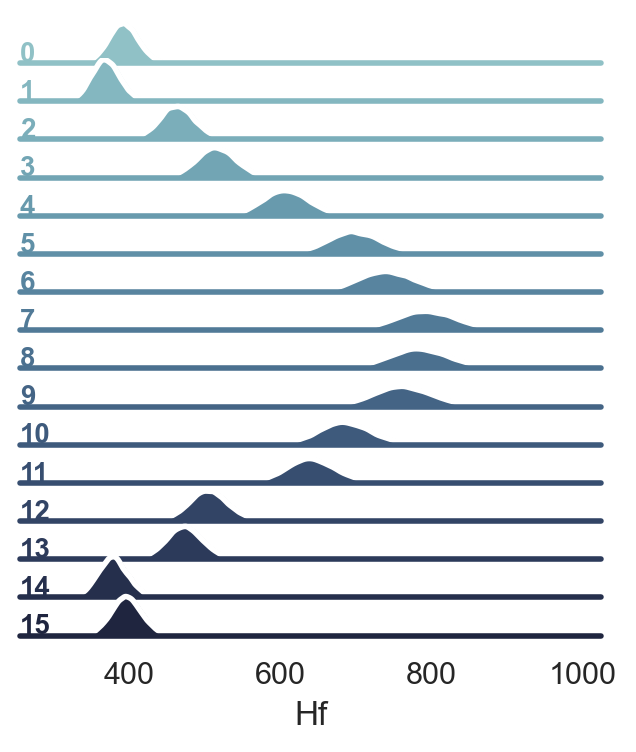

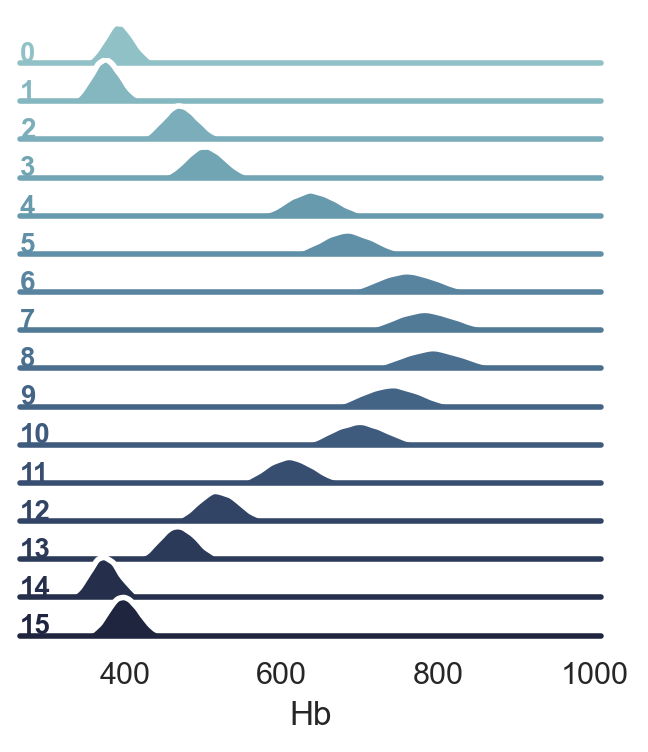

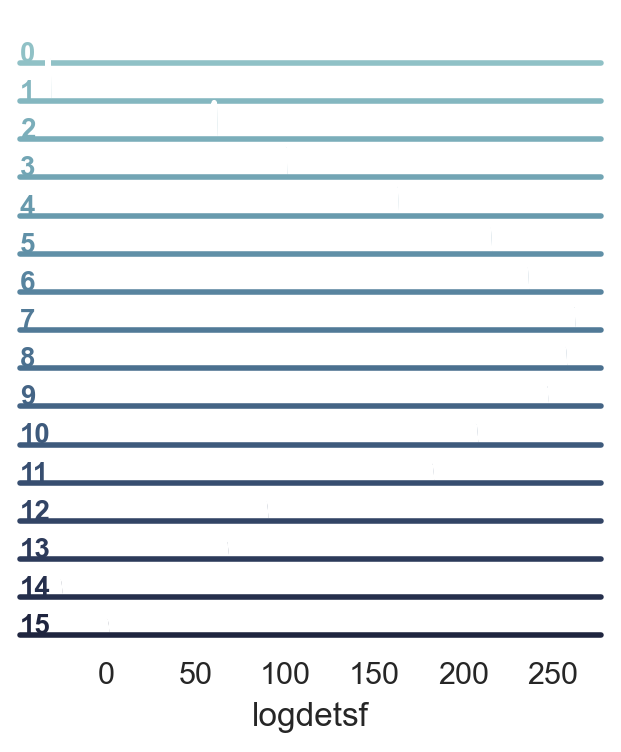

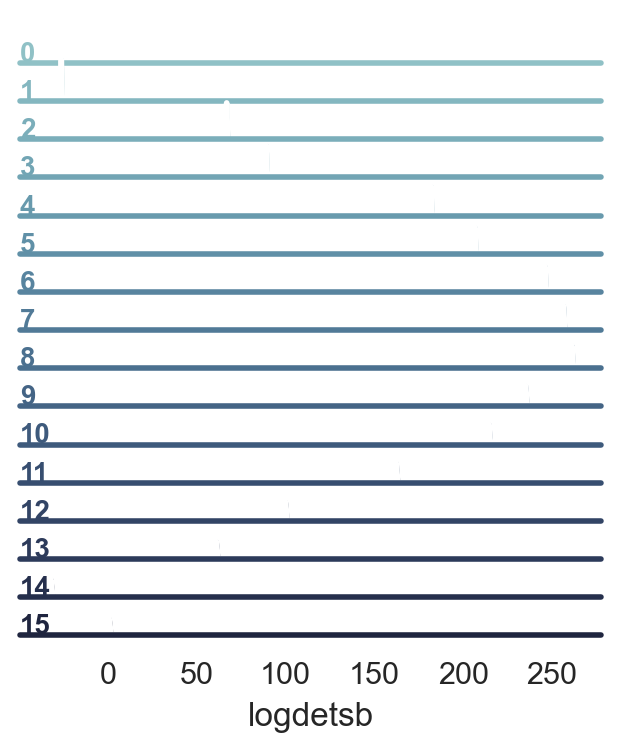

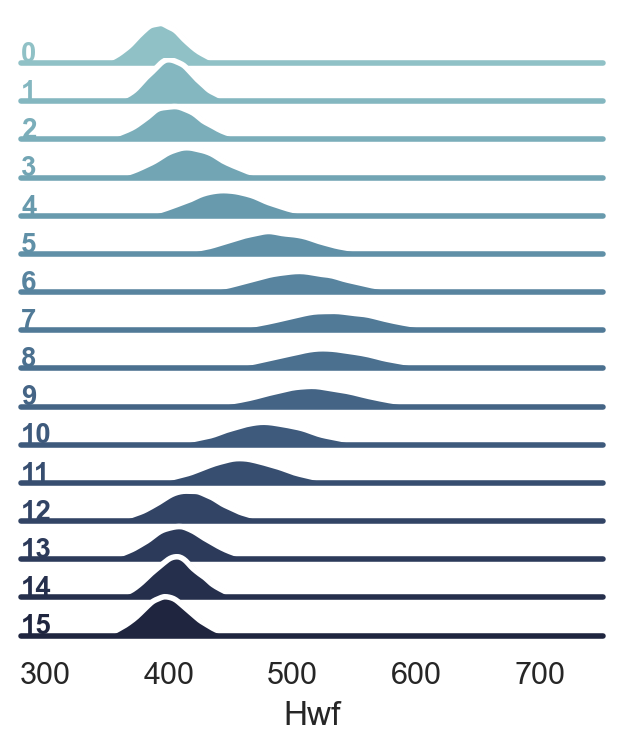

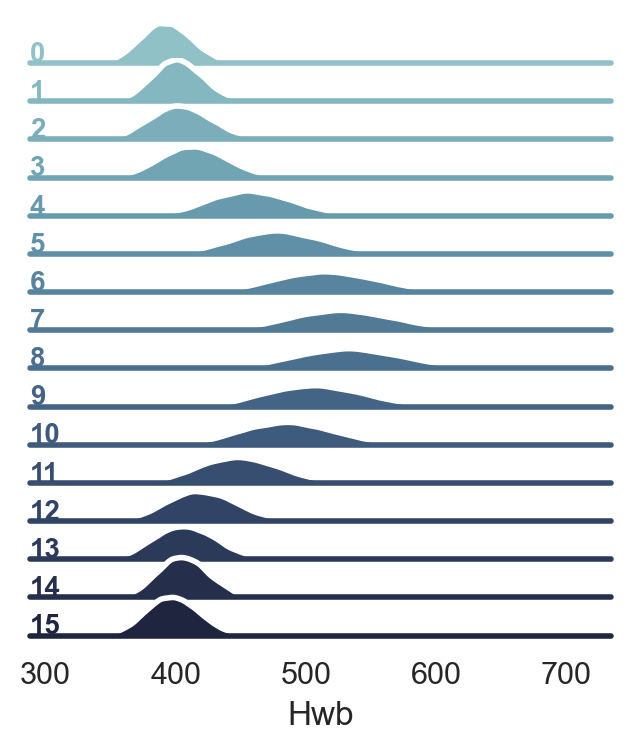

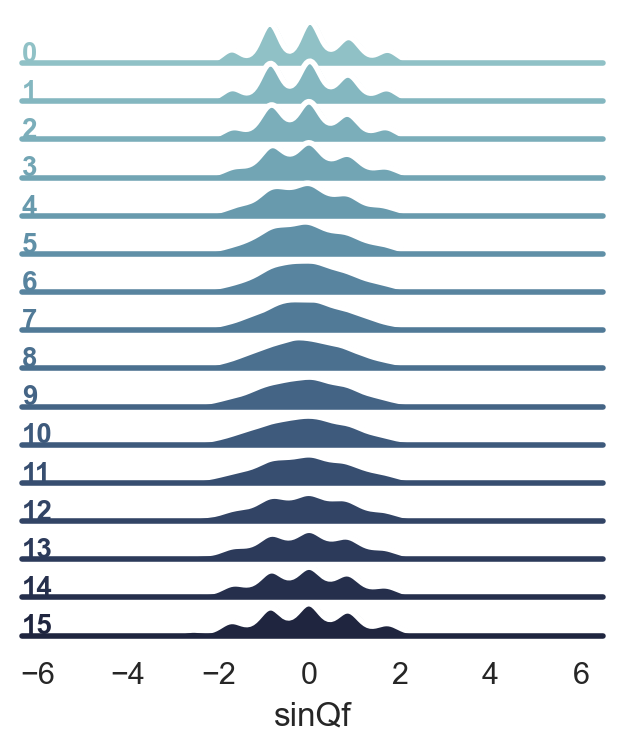

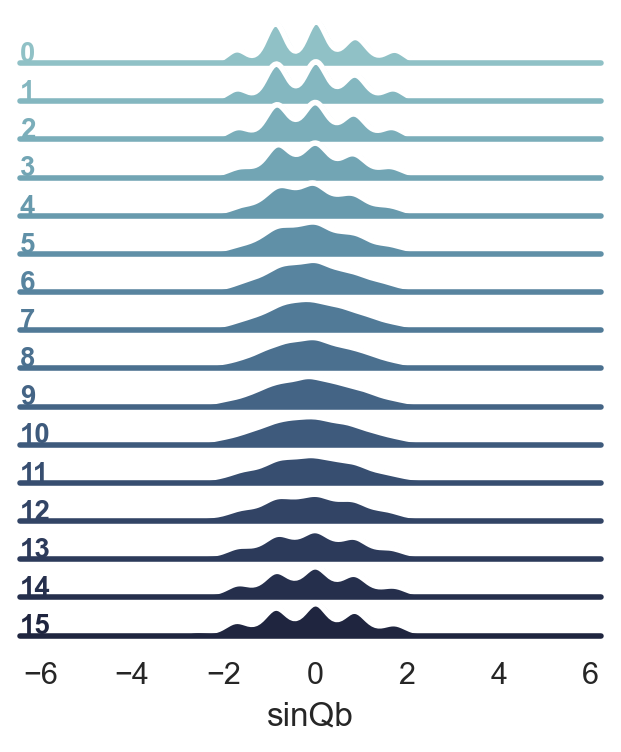

In [36]:
from config import PLOTS_DIR
from utils.plotting_utils import make_ridgeplots
plt.rc('text', usetex=False)
sns.set_context('paper')

timestamp = io.get_timestamp('%Y-%m-%d-%H%M')
outdir = os.path.join(PLOTS_DIR, 'ridgeplots', f'{log_str}-{timestamp}')
make_ridgeplots(dataset, out_dir=outdir)

In [ ]:
plt.text()